# CharBert

In [ ]:
!pip install transformers

## Librarys and configs

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score, roc_curve, RocCurveDisplay
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm, trange
from hashlib import sha256
from transformers import BertTokenizer
from copy import deepcopy
import logging
import tempfile
import shutil
import six
import copy
import collections
import os
import json
import numpy as np
import sys
import io
import os
import requests
import transformers
import torch
import itertools
import unicodedata
import random
import math
import fnmatch
from dataclasses import dataclass
from typing import Optional, List
import dataclasses
try:
    from urllib.parse import urlparse
except ImportError:
    from urlparse import urlparse
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    from tensorboardX import SummaryWriter

## New Dataset


### BertTokenizer

In [ ]:
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name

try:
    from torch.hub import _get_torch_home
    torch_cache_home = _get_torch_home()
except ImportError:
    torch_cache_home = os.path.expanduser(
        os.getenv('TORCH_HOME', os.path.join(
            os.getenv('XDG_CACHE_HOME', '~/.cache'), 'torch')))
default_cache_path = os.path.join(torch_cache_home, 'transformers')

try:
    from pathlib import Path
    PYTORCH_PRETRAINED_BERT_CACHE = Path(
        os.getenv('PYTORCH_TRANSFORMERS_CACHE', os.getenv('PYTORCH_PRETRAINED_BERT_CACHE', default_cache_path)))
except (AttributeError, ImportError):
    PYTORCH_PRETRAINED_BERT_CACHE = os.getenv('PYTORCH_TRANSFORMERS_CACHE',
                                              os.getenv('PYTORCH_PRETRAINED_BERT_CACHE',
                                                        default_cache_path))

PYTORCH_TRANSFORMERS_CACHE = PYTORCH_PRETRAINED_BERT_CACHE  # Kept for backward compatibility
TRANSFORMERS_CACHE = PYTORCH_PRETRAINED_BERT_CACHE  # Kept for backward compatibility

In [ ]:
def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens

In [ ]:
def _is_whitespace(char):
    """Checks whether `chars` is a whitespace character."""
    # \t, \n, and \r are technically contorl characters but we treat them
    # as whitespace since they are generally considered as such.
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    cat = unicodedata.category(char)
    if cat == "Zs":
        return True
    return False

In [ ]:
def is_remote_url(url_or_filename):
    parsed = urlparse(url_or_filename)
    return parsed.scheme in ('http', 'https', 's3')

In [ ]:
def cached_path(url_or_filename, cache_dir=None, force_download=False, proxies=None, resume_download=False, user_agent=None):
    """
    Given something that might be a URL (or might be a local path),
    determine which. If it's a URL, download the file and cache it, and
    return the path to the cached file. If it's already a local path,
    make sure the file exists and then return the path.
    Args:
        cache_dir: specify a cache directory to save the file to (overwrite the default cache dir).
        force_download: if True, re-dowload the file even if it's already cached in the cache dir.
        resume_download: if True, resume the download if incompletly recieved file is found.
        user_agent: Optional string or dict that will be appended to the user-agent on remote requests.
    """
    if cache_dir is None:
        cache_dir = TRANSFORMERS_CACHE
    if sys.version_info[0] == 3 and isinstance(url_or_filename, Path):
        url_or_filename = str(url_or_filename)
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    if is_remote_url(url_or_filename):
        # URL, so get it from the cache (downloading if necessary)
        return get_from_cache(url_or_filename, cache_dir=cache_dir,
            force_download=force_download, proxies=proxies,
            resume_download=resume_download, user_agent=user_agent)
    elif os.path.exists(url_or_filename):
        # File, and it exists.
        return url_or_filename
    elif urlparse(url_or_filename).scheme == '':
        # File, but it doesn't exist.
        raise EnvironmentError("file {} not found".format(url_or_filename))
    else:
        # Something unknown
        raise ValueError("unable to parse {} as a URL or as a local path".format(url_or_filename))

In [ ]:
def get_from_cache(url, cache_dir=None, force_download=False, proxies=None, etag_timeout=10, resume_download=False, user_agent=None):
    """
    Given a URL, look for the corresponding dataset in the local cache.
    If it's not there, download it. Then return the path to the cached file.
    """
    if cache_dir is None:
        cache_dir = TRANSFORMERS_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)
    if sys.version_info[0] == 2 and not isinstance(cache_dir, str):
        cache_dir = str(cache_dir)

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # Get eTag to add to filename, if it exists.
    if url.startswith("s3://"):
        etag = s3_etag(url, proxies=proxies)
    else:
        try:
            response = requests.head(url, allow_redirects=True, proxies=proxies, timeout=etag_timeout)
            if response.status_code != 200:
                etag = None
            else:
                etag = response.headers.get("ETag")
        except (EnvironmentError, requests.exceptions.Timeout):
            etag = None

    if sys.version_info[0] == 2 and etag is not None:
        etag = etag.decode('utf-8')
    filename = url_to_filename(url, etag)

    # get cache path to put the file
    cache_path = os.path.join(cache_dir, filename)

    # If we don't have a connection (etag is None) and can't identify the file
    # try to get the last downloaded one
    if not os.path.exists(cache_path) and etag is None:
        matching_files = fnmatch.filter(os.listdir(cache_dir), filename + '.*')
        matching_files = list(filter(lambda s: not s.endswith('.json'), matching_files))
        if matching_files:
            cache_path = os.path.join(cache_dir, matching_files[-1])

    if resume_download:
        incomplete_path = cache_path + '.incomplete'
        @contextmanager
        def _resumable_file_manager():
            with open(incomplete_path,'a+b') as f:
                yield f
            os.remove(incomplete_path)
        temp_file_manager = _resumable_file_manager
        if os.path.exists(incomplete_path):
            resume_size = os.stat(incomplete_path).st_size
        else:
            resume_size = 0
    else:
        temp_file_manager = tempfile.NamedTemporaryFile
        resume_size = 0

    if etag is not None and (not os.path.exists(cache_path) or force_download):
        # Download to temporary file, then copy to cache dir once finished.
        # Otherwise you get corrupt cache entries if the download gets interrupted.
        with temp_file_manager() as temp_file:
            logger.info("%s not found in cache or force_download set to True, downloading to %s", url, temp_file.name)

            # GET file object
            if url.startswith("s3://"):
                if resume_download:
                    logger.warn('Warning: resumable downloads are not implemented for "s3://" urls')
                s3_get(url, temp_file, proxies=proxies)
            else:
                http_get(url, temp_file, proxies=proxies, resume_size=resume_size, user_agent=user_agent)

            # we are copying the file before closing it, so flush to avoid truncation
            temp_file.flush()
            # shutil.copyfileobj() starts at the current position, so go to the start
            temp_file.seek(0)

            logger.info("copying %s to cache at %s", temp_file.name, cache_path)
            with open(cache_path, 'wb') as cache_file:
                shutil.copyfileobj(temp_file, cache_file)

            logger.info("creating metadata file for %s", cache_path)
            meta = {'url': url, 'etag': etag}
            meta_path = cache_path + '.json'
            with open(meta_path, 'w') as meta_file:
                output_string = json.dumps(meta)
                if sys.version_info[0] == 2 and isinstance(output_string, str):
                    output_string = unicode(output_string, 'utf-8')  # The beauty of python 2
                meta_file.write(output_string)

            logger.info("removing temp file %s", temp_file.name)

    return cache_path

In [ ]:
def url_to_filename(url, etag=None):
    """
    Convert `url` into a hashed filename in a repeatable way.
    If `etag` is specified, append its hash to the url's, delimited
    by a period.
    If the url ends with .h5 (Keras HDF5 weights) adds '.h5' to the name
    so that TF 2.0 can identify it as a HDF5 file
    (see https://github.com/tensorflow/tensorflow/blob/00fad90125b18b80fe054de1055770cfb8fe4ba3/tensorflow/python/keras/engine/network.py#L1380)
    """
    url_bytes = url.encode('utf-8')
    url_hash = sha256(url_bytes)
    filename = url_hash.hexdigest()

    if etag:
        etag_bytes = etag.encode('utf-8')
        etag_hash = sha256(etag_bytes)
        filename += '.' + etag_hash.hexdigest()

    if url.endswith('.h5'):
        filename += '.h5'

    return filename


In [ ]:
def http_get(url, temp_file, proxies=None, resume_size=0, user_agent=None):
    ua = "transformers/{}; python/{}".format(transformers.__version__, sys.version.split()[0])
    if isinstance(user_agent, dict):
        ua += "; " + "; ".join(
            "{}/{}".format(k, v) for k, v in user_agent.items()
        )
    elif isinstance(user_agent, six.string_types):
        ua += "; "+ user_agent
    headers = {
        "user-agent": ua
    }
    if resume_size > 0:
        headers['Range'] = 'bytes=%d-' % (resume_size,)
    response = requests.get(url, stream=True, proxies=proxies, headers=headers)
    if response.status_code == 416:  # Range not satisfiable
        return
    content_length = response.headers.get('Content-Length')
    total = resume_size + int(content_length) if content_length is not None else None
    progress = tqdm(unit="B", unit_scale=True, total=total, initial=resume_size,
                    desc="Downloading", disable=bool(logger.level<=logging.INFO))
    for chunk in response.iter_content(chunk_size=1024):
        if chunk: # filter out keep-alive new chunks
            progress.update(len(chunk))
            temp_file.write(chunk)
    progress.close()

In [ ]:
def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False

In [ ]:
def _is_control(char):
    """Checks whether `chars` is a control character."""
    # These are technically control characters but we count them as whitespace
    # characters.
    if char == "\t" or char == "\n" or char == "\r":
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        return True
    return False

In [ ]:
def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip('\n')
        vocab[token] = index
    return vocab


In [ ]:
class BasicTokenizer(object):
    """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

    def __init__(self, do_lower_case=True, never_split=None, tokenize_chinese_chars=True):
        """ Constructs a BasicTokenizer.

        Args:
            **do_lower_case**: Whether to lower case the input.
            **never_split**: (`optional`) list of str
                Kept for backward compatibility purposes.
                Now implemented directly at the base class level (see :func:`PreTrainedTokenizer.tokenize`)
                List of token not to split.
            **tokenize_chinese_chars**: (`optional`) boolean (default True)
                Whether to tokenize Chinese characters.
                This should likely be deactivated for Japanese:
                see: https://github.com/huggingface/pytorch-pretrained-BERT/issues/328
        """
        if never_split is None:
            never_split = []
        self.do_lower_case = do_lower_case
        self.never_split = never_split
        self.tokenize_chinese_chars = tokenize_chinese_chars

    def tokenize(self, text, never_split=None):
        """ Basic Tokenization of a piece of text.
            Split on "white spaces" only, for sub-word tokenization, see WordPieceTokenizer.

        Args:
            **never_split**: (`optional`) list of str
                Kept for backward compatibility purposes.
                Now implemented directly at the base class level (see :func:`PreTrainedTokenizer.tokenize`)
                List of token not to split.
        """
        never_split = self.never_split + (never_split if never_split is not None else [])
        text = self._clean_text(text)
        # This was added on November 1st, 2018 for the multilingual and Chinese
        # models. This is also applied to the English models now, but it doesn't
        # matter since the English models were not trained on any Chinese data
        # and generally don't have any Chinese data in them (there are Chinese
        # characters in the vocabulary because Wikipedia does have some Chinese
        # words in the English Wikipedia.).
        if self.tokenize_chinese_chars:
            text = self._tokenize_chinese_chars(text)
        orig_tokens = whitespace_tokenize(text)
        split_tokens = []
        for token in orig_tokens:
            if self.do_lower_case and token not in never_split:
                token = token.lower()
                token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token))

        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text, never_split=None):
        """Splits punctuation on a piece of text."""
        if never_split is not None and text in never_split:
            return [text]
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]

    def _tokenize_chinese_chars(self, text):
        """Adds whitespace around any CJK character."""
        output = []
        for char in text:
            cp = ord(char)
            if self._is_chinese_char(cp):
                output.append(" ")
                output.append(char)
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

    def _is_chinese_char(self, cp):
        """Checks whether CP is the codepoint of a CJK character."""
        # This defines a "chinese character" as anything in the CJK Unicode block:
        #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
        #
        # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
        # despite its name. The modern Korean Hangul alphabet is a different block,
        # as is Japanese Hiragana and Katakana. Those alphabets are used to write
        # space-separated words, so they are not treated specially and handled
        # like the all of the other languages.
        if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
                (cp >= 0x3400 and cp <= 0x4DBF) or  #
                (cp >= 0x20000 and cp <= 0x2A6DF) or  #
                (cp >= 0x2A700 and cp <= 0x2B73F) or  #
                (cp >= 0x2B740 and cp <= 0x2B81F) or  #
                (cp >= 0x2B820 and cp <= 0x2CEAF) or
                (cp >= 0xF900 and cp <= 0xFAFF) or  #
                (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
            return True

        return False

    def _clean_text(self, text):
        """Performs invalid character removal and whitespace cleanup on text."""
        output = []
        for char in text:
            cp = ord(char)
            if cp == 0 or cp == 0xfffd or _is_control(char):
                continue
            if _is_whitespace(char):
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

In [ ]:
class WordpieceTokenizer(object):
    """Runs WordPiece tokenization."""

    def __init__(self, vocab, unk_token, max_input_chars_per_word=100):
        self.vocab = vocab
        self.unk_token = unk_token
        self.max_input_chars_per_word = max_input_chars_per_word

    def tokenize(self, text):
        """Tokenizes a piece of text into its word pieces.

        This uses a greedy longest-match-first algorithm to perform tokenization
        using the given vocabulary.

        For example:
          input = "unaffable"
          output = ["un", "##aff", "##able"]

        Args:
          text: A single token or whitespace separated tokens. This should have
            already been passed through `BasicTokenizer`.

        Returns:
          A list of wordpiece tokens.
        """

        output_tokens = []
        for token in whitespace_tokenize(text):
            chars = list(token)
            if len(chars) > self.max_input_chars_per_word:
                output_tokens.append(self.unk_token)
                continue

            is_bad = False
            start = 0
            sub_tokens = []
            while start < len(chars):
                end = len(chars)
                cur_substr = None
                while start < end:
                    substr = "".join(chars[start:end])
                    if start > 0:
                        substr = "##" + substr
                    if substr in self.vocab:
                        cur_substr = substr
                        break
                    end -= 1
                if cur_substr is None:
                    is_bad = True
                    break
                sub_tokens.append(cur_substr)
                start = end

            if is_bad:
                output_tokens.append(self.unk_token)
            else:
                output_tokens.extend(sub_tokens)
        return output_tokens


In [ ]:
class PreTrainedTokenizer(object):
    """ Base class for all tokenizers.
    Handle all the shared methods for tokenization and special tokens as well as methods dowloading/caching/loading pretrained tokenizers as well as adding tokens to the vocabulary.

    This class also contain the added tokens in a unified way on top of all tokenizers so we don't have to handle the specific vocabulary augmentation methods of the various underlying dictionary structures (BPE, sentencepiece...).

    Class attributes (overridden by derived classes):

        - ``vocab_files_names``: a python ``dict`` with, as keys, the ``__init__`` keyword name of each vocabulary file required by the model, and as associated values, the filename for saving the associated file (string).
        - ``pretrained_vocab_files_map``: a python ``dict of dict`` the high-level keys being the ``__init__`` keyword name of each vocabulary file required by the model, the low-level being the `short-cut-names` (string) of the pretrained models with, as associated values, the `url` (string) to the associated pretrained vocabulary file.
        - ``max_model_input_sizes``: a python ``dict`` with, as keys, the `short-cut-names` (string) of the pretrained models, and as associated values, the maximum length of the sequence inputs of this model, or None if the model has no maximum input size.
        - ``pretrained_init_configuration``: a python ``dict`` with, as keys, the `short-cut-names` (string) of the pretrained models, and as associated values, a dictionnary of specific arguments to pass to the ``__init__``method of the tokenizer class for this pretrained model when loading the tokenizer with the ``from_pretrained()`` method.

    Parameters:

        - ``bos_token``: (`Optional`) string: a beginning of sentence token. Will be associated to ``self.bos_token`` and ``self.bos_token_id``

        - ``eos_token``: (`Optional`) string: an end of sentence token. Will be associated to ``self.eos_token`` and ``self.eos_token_id``

        - ``unk_token``: (`Optional`) string: an unknown token. Will be associated to ``self.unk_token`` and ``self.unk_token_id``

        - ``sep_token``: (`Optional`) string: a separation token (e.g. to separate context and query in an input sequence). Will be associated to ``self.sep_token`` and ``self.sep_token_id``

        - ``pad_token``: (`Optional`) string: a padding token. Will be associated to ``self.pad_token`` and ``self.pad_token_id``

        - ``cls_token``: (`Optional`) string: a classification token (e.g. to extract a summary of an input sequence leveraging self-attention along the full depth of the model). Will be associated to ``self.cls_token`` and ``self.cls_token_id``

        - ``mask_token``: (`Optional`) string: a masking token (e.g. when training a model with masked-language modeling). Will be associated to ``self.mask_token`` and ``self.mask_token_id``

        - ``additional_special_tokens``: (`Optional`) list: a list of additional special tokens. Adding all special tokens here ensure they won't be split by the tokenization process. Will be associated to ``self.additional_special_tokens`` and ``self.additional_special_tokens_ids``
    """
    vocab_files_names = {}
    pretrained_vocab_files_map = {}
    pretrained_init_configuration = {}
    max_model_input_sizes = {}

    SPECIAL_TOKENS_ATTRIBUTES = ["bos_token", "eos_token", "unk_token", "sep_token",
                                 "pad_token", "cls_token", "mask_token",
                                 "additional_special_tokens"]

    padding_side = "right"

    @property
    def bos_token(self):
        """ Beginning of sentence token (string). Log an error if used while not having been set. """
        if self._bos_token is None:
            logger.error("Using bos_token, but it is not set yet.")
        return self._bos_token

    @property
    def eos_token(self):
        """ End of sentence token (string). Log an error if used while not having been set. """
        if self._eos_token is None:
            logger.error("Using eos_token, but it is not set yet.")
        return self._eos_token

    @property
    def unk_token(self):
        """ Unknown token (string). Log an error if used while not having been set. """
        if self._unk_token is None:
            logger.error("Using unk_token, but it is not set yet.")
        return self._unk_token

    @property
    def sep_token(self):
        """ Separation token (string). E.g. separate context and query in an input sequence. Log an error if used while not having been set. """
        if self._sep_token is None:
            logger.error("Using sep_token, but it is not set yet.")
        return self._sep_token

    @property
    def pad_token(self):
        """ Padding token (string). Log an error if used while not having been set. """
        if self._pad_token is None:
            logger.error("Using pad_token, but it is not set yet.")
        return self._pad_token

    @property
    def cls_token(self):
        """ Classification token (string). E.g. to extract a summary of an input sequence leveraging self-attention along the full depth of the model. Log an error if used while not having been set. """
        if self._cls_token is None:
            logger.error("Using cls_token, but it is not set yet.")
        return self._cls_token

    @property
    def mask_token(self):
        """ Mask token (string). E.g. when training a model with masked-language modeling. Log an error if used while not having been set. """
        if self._mask_token is None:
            logger.error("Using mask_token, but it is not set yet.")
        return self._mask_token

    @property
    def additional_special_tokens(self):
        """ All the additional special tokens you may want to use (list of strings). Log an error if used while not having been set. """
        if self._additional_special_tokens is None:
            logger.error("Using additional_special_tokens, but it is not set yet.")
        return self._additional_special_tokens

    @bos_token.setter
    def bos_token(self, value):
        self._bos_token = value

    @eos_token.setter
    def eos_token(self, value):
        self._eos_token = value

    @unk_token.setter
    def unk_token(self, value):
        self._unk_token = value

    @sep_token.setter
    def sep_token(self, value):
        self._sep_token = value

    @pad_token.setter
    def pad_token(self, value):
        self._pad_token = value

    @cls_token.setter
    def cls_token(self, value):
        self._cls_token = value

    @mask_token.setter
    def mask_token(self, value):
        self._mask_token = value

    @additional_special_tokens.setter
    def additional_special_tokens(self, value):
        self._additional_special_tokens = value

    @property
    def bos_token_id(self):
        """ Id of the beginning of sentence token in the vocabulary. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.bos_token)

    @property
    def eos_token_id(self):
        """ Id of the end of sentence token in the vocabulary. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.eos_token)

    @property
    def unk_token_id(self):
        """ Id of the unknown token in the vocabulary. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.unk_token)

    @property
    def sep_token_id(self):
        """ Id of the separation token in the vocabulary. E.g. separate context and query in an input sequence. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.sep_token)

    @property
    def pad_token_id(self):
        """ Id of the padding token in the vocabulary. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.pad_token)

    @property
    def pad_token_type_id(self):
        """ Id of the padding token type in the vocabulary."""
        return self._pad_token_type_id

    @property
    def cls_token_id(self):
        """ Id of the classification token in the vocabulary. E.g. to extract a summary of an input sequence leveraging self-attention along the full depth of the model. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.cls_token)

    @property
    def mask_token_id(self):
        """ Id of the mask token in the vocabulary. E.g. when training a model with masked-language modeling. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.mask_token)

    @property
    def additional_special_tokens_ids(self):
        """ Ids of all the additional special tokens in the vocabulary (list of integers). Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.additional_special_tokens)

    def __init__(self, max_len=None, **kwargs):
        self._bos_token = None
        self._eos_token = None
        self._unk_token = None
        self._sep_token = None
        self._pad_token = None
        self._cls_token = None
        self._mask_token = None
        self._pad_token_type_id = 0
        self._additional_special_tokens = []

        self.max_len = max_len if max_len is not None else int(1e12)

        # Padding side is right by default and over-riden in subclasses. If specified in the kwargs, it is changed.
        self.padding_side = kwargs.pop('padding_side', self.padding_side)

        # Added tokens
        self.added_tokens_encoder = {}
        self.added_tokens_decoder = {}

        # inputs and kwargs for saving and re-loading (see ``from_pretrained`` and ``save_pretrained``)
        self.init_inputs = ()
        self.init_kwargs = {}

        for key, value in kwargs.items():
            if key in self.SPECIAL_TOKENS_ATTRIBUTES:
                if key == 'additional_special_tokens':
                    assert isinstance(value, (list, tuple)) and all(isinstance(t, str) or (six.PY2 and isinstance(t, unicode)) for t in value)
                else:
                    assert isinstance(value, str) or (six.PY2 and isinstance(value, unicode))
                setattr(self, key, value)


    @classmethod
    def from_pretrained(cls, *inputs, **kwargs):
        r"""
        Instantiate a :class:`~transformers.PreTrainedTokenizer` (or a derived class) from a predefined tokenizer.

        Args:
            pretrained_model_name_or_path: either:

                - a string with the `shortcut name` of a predefined tokenizer to load from cache or download, e.g.: ``bert-base-uncased``.
                - a string with the `identifier name` of a predefined tokenizer that was user-uploaded to our S3, e.g.: ``dbmdz/bert-base-german-cased``.
                - a path to a `directory` containing vocabulary files required by the tokenizer, for instance saved using the :func:`~transformers.PreTrainedTokenizer.save_pretrained` method, e.g.: ``./my_model_directory/``.
                - (not applicable to all derived classes) a path or url to a single saved vocabulary file if and only if the tokenizer only requires a single vocabulary file (e.g. Bert, XLNet), e.g.: ``./my_model_directory/vocab.txt``.

            cache_dir: (`optional`) string:
                Path to a directory in which a downloaded predefined tokenizer vocabulary files should be cached if the standard cache should not be used.

            force_download: (`optional`) boolean, default False:
                Force to (re-)download the vocabulary files and override the cached versions if they exists.

            resume_download: (`optional`) boolean, default False:
                Do not delete incompletely recieved file. Attempt to resume the download if such a file exists.

            proxies: (`optional`) dict, default None:
                A dictionary of proxy servers to use by protocol or endpoint, e.g.: {'http': 'foo.bar:3128', 'http://hostname': 'foo.bar:4012'}.
                The proxies are used on each request.

            inputs: (`optional`) positional arguments: will be passed to the Tokenizer ``__init__`` method.

            kwargs: (`optional`) keyword arguments: will be passed to the Tokenizer ``__init__`` method. Can be used to set special tokens like ``bos_token``, ``eos_token``, ``unk_token``, ``sep_token``, ``pad_token``, ``cls_token``, ``mask_token``, ``additional_special_tokens``. See parameters in the doc string of :class:`~transformers.PreTrainedTokenizer` for details.

        Examples::

            # We can't instantiate directly the base class `PreTrainedTokenizer` so let's show our examples on a derived class: BertTokenizer

            # Download vocabulary from S3 and cache.
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

            # Download vocabulary from S3 (user-uploaded) and cache.
            tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-german-cased')

            # If vocabulary files are in a directory (e.g. tokenizer was saved using `save_pretrained('./test/saved_model/')`)
            tokenizer = BertTokenizer.from_pretrained('./test/saved_model/')

            # If the tokenizer uses a single vocabulary file, you can point directly to this file
            tokenizer = BertTokenizer.from_pretrained('./test/saved_model/my_vocab.txt')

            # You can link tokens to special vocabulary when instantiating
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', unk_token='<unk>')
            # You should be sure '<unk>' is in the vocabulary when doing that.
            # Otherwise use tokenizer.add_special_tokens({'unk_token': '<unk>'}) instead)
            assert tokenizer.unk_token == '<unk>'

        """
        return cls._from_pretrained(*inputs, **kwargs)


    @classmethod
    def _from_pretrained(cls, pretrained_model_name_or_path, *init_inputs, **kwargs):
        cache_dir = kwargs.pop('cache_dir', None)
        force_download = kwargs.pop('force_download', False)
        resume_download = kwargs.pop('resume_download', False)
        proxies = kwargs.pop('proxies', None)

        s3_models = list(cls.max_model_input_sizes.keys())
        vocab_files = {}
        init_configuration = {}
        if pretrained_model_name_or_path in s3_models:
            # Get the vocabulary from AWS S3 bucket
            for file_id, map_list in cls.pretrained_vocab_files_map.items():
                vocab_files[file_id] = map_list[pretrained_model_name_or_path]
            if cls.pretrained_init_configuration and pretrained_model_name_or_path in cls.pretrained_init_configuration:
                init_configuration = cls.pretrained_init_configuration[pretrained_model_name_or_path]
        else:
            # Get the vocabulary from local files
            logger.info(
                "Model name '{}' not found in model shortcut name list ({}). "
                "Assuming '{}' is a path or url to a directory containing tokenizer files.".format(
                    pretrained_model_name_or_path, ', '.join(s3_models),
                    pretrained_model_name_or_path))

            # Look for the tokenizer main vocabulary files
            for file_id, file_name in cls.vocab_files_names.items():
                if os.path.isdir(pretrained_model_name_or_path):
                    # If a directory is provided we look for the standard filenames
                    full_file_name = os.path.join(pretrained_model_name_or_path, file_name)
                    if not os.path.exists(full_file_name):
                        logger.info("Didn't find file {}. We won't load it.".format(full_file_name))
                        full_file_name = None
                elif os.path.isfile(pretrained_model_name_or_path) or is_remote_url(pretrained_model_name_or_path):
                    # If a path to a file is provided we use it (will only work for non-BPE tokenizer using a single vocabulary file)
                    full_file_name = pretrained_model_name_or_path
                else:
                    full_file_name = hf_bucket_url(pretrained_model_name_or_path, postfix=file_name)

                vocab_files[file_id] = full_file_name

            # Look for the additional tokens files
            additional_files_names = {'added_tokens_file': ADDED_TOKENS_FILE,
                                      'special_tokens_map_file': SPECIAL_TOKENS_MAP_FILE,
                                      'tokenizer_config_file': TOKENIZER_CONFIG_FILE,
                                      }

            # If a path to a file was provided, get the parent directory
            saved_directory = pretrained_model_name_or_path
            if os.path.exists(saved_directory) and not os.path.isdir(saved_directory):
                saved_directory = os.path.dirname(saved_directory)

            for file_id, file_name in additional_files_names.items():
                full_file_name = os.path.join(saved_directory, file_name)
                if not os.path.exists(full_file_name):
                    logger.info("Didn't find file {}. We won't load it.".format(full_file_name))
                    full_file_name = None
                vocab_files[file_id] = full_file_name

            if all(full_file_name is None for full_file_name in vocab_files.values()):
                raise EnvironmentError(
                    "Model name '{}' was not found in tokenizers model name list ({}). "
                    "We assumed '{}' was a path or url to a directory containing vocabulary files "
                    "named {} but couldn't find such vocabulary files at this path or url.".format(
                        pretrained_model_name_or_path, ', '.join(s3_models),
                        pretrained_model_name_or_path,
                        list(cls.vocab_files_names.values())))

        # Get files from url, cache, or disk depending on the case
        try:
            resolved_vocab_files = {}
            for file_id, file_path in vocab_files.items():
                if file_path is None:
                    resolved_vocab_files[file_id] = None
                else:
                    resolved_vocab_files[file_id] = cached_path(file_path, cache_dir=cache_dir, force_download=force_download, proxies=proxies, resume_download=resume_download)
        except EnvironmentError:
            if pretrained_model_name_or_path in s3_models:
                msg = "Couldn't reach server at '{}' to download vocabulary files."
            else:
                msg = "Model name '{}' was not found in tokenizers model name list ({}). " \
                    "We assumed '{}' was a path or url to a directory containing vocabulary files " \
                    "named {}, but couldn't find such vocabulary files at this path or url.".format(
                        pretrained_model_name_or_path, ', '.join(s3_models),
                        pretrained_model_name_or_path,
                        list(cls.vocab_files_names.values()))

            raise EnvironmentError(msg)

        for file_id, file_path in vocab_files.items():
            if file_path == resolved_vocab_files[file_id]:
                logger.info("loading file {}".format(file_path))
            else:
                logger.info("loading file {} from cache at {}".format(
                    file_path, resolved_vocab_files[file_id]))

        # Prepare tokenizer initialization kwargs
        # Did we saved some inputs and kwargs to reload ?
        tokenizer_config_file = resolved_vocab_files.pop('tokenizer_config_file', None)
        if tokenizer_config_file is not None:
            with open(tokenizer_config_file, encoding="utf-8") as tokenizer_config_handle:
                init_kwargs = json.load(tokenizer_config_handle)
            saved_init_inputs = init_kwargs.pop('init_inputs', ())
            if not init_inputs:
                init_inputs = saved_init_inputs
        else:
            init_kwargs = init_configuration

        # Update with newly provided kwargs
        init_kwargs.update(kwargs)

        # Set max length if needed
        if pretrained_model_name_or_path in cls.max_model_input_sizes:
            # if we're using a pretrained model, ensure the tokenizer
            # wont index sequences longer than the number of positional embeddings
            max_len = cls.max_model_input_sizes[pretrained_model_name_or_path]
            if max_len is not None and isinstance(max_len, (int, float)):
                init_kwargs['max_len'] = min(init_kwargs.get('max_len', int(1e12)), max_len)

        # Merge resolved_vocab_files arguments in init_kwargs.
        added_tokens_file = resolved_vocab_files.pop('added_tokens_file', None)
        special_tokens_map_file = resolved_vocab_files.pop('special_tokens_map_file', None)
        for args_name, file_path in resolved_vocab_files.items():
            if args_name not in init_kwargs:
                init_kwargs[args_name] = file_path
        if special_tokens_map_file is not None:
            with open(special_tokens_map_file, encoding="utf-8") as special_tokens_map_handle:
                special_tokens_map = json.load(special_tokens_map_handle)
            for key, value in special_tokens_map.items():
                if key not in init_kwargs:
                    init_kwargs[key] = value

        # Instantiate tokenizer.
        try:
            tokenizer = cls(*init_inputs, **init_kwargs)
        except OSError:
            OSError("Unable to load vocabulary from file. "
                    "Please check that the provided vocabulary is accessible and not corrupted.")

        # Save inputs and kwargs for saving and re-loading with ``save_pretrained``
        tokenizer.init_inputs = init_inputs
        tokenizer.init_kwargs = init_kwargs

        # Add supplementary tokens.
        if added_tokens_file is not None:
            with open(added_tokens_file, encoding="utf-8") as added_tokens_handle:
                added_tok_encoder = json.load(added_tokens_handle)
            added_tok_decoder = {v:k for k, v in added_tok_encoder.items()}
            tokenizer.added_tokens_encoder.update(added_tok_encoder)
            tokenizer.added_tokens_decoder.update(added_tok_decoder)

        return tokenizer


    def save_pretrained(self, save_directory):
        """ Save the tokenizer vocabulary files together with:
                - added tokens,
                - special-tokens-to-class-attributes-mapping,
                - tokenizer instantiation positional and keywords inputs (e.g. do_lower_case for Bert).

            This won't save modifications other than (added tokens and special token mapping) you may have
            applied to the tokenizer after the instantiation (e.g. modifying tokenizer.do_lower_case after creation).

            This method make sure the full tokenizer can then be re-loaded using the :func:`~transformers.PreTrainedTokenizer.from_pretrained` class method.
        """
        if not os.path.isdir(save_directory):
            logger.error("Saving directory ({}) should be a directory".format(save_directory))
            return

        special_tokens_map_file = os.path.join(save_directory, SPECIAL_TOKENS_MAP_FILE)
        added_tokens_file = os.path.join(save_directory, ADDED_TOKENS_FILE)
        tokenizer_config_file = os.path.join(save_directory, TOKENIZER_CONFIG_FILE)

        tokenizer_config = copy.deepcopy(self.init_kwargs)
        tokenizer_config['init_inputs'] = copy.deepcopy(self.init_inputs)
        for file_id in self.vocab_files_names.keys():
            tokenizer_config.pop(file_id, None)

        with open(tokenizer_config_file, 'w', encoding='utf-8') as f:
            f.write(json.dumps(tokenizer_config, ensure_ascii=False))

        with open(special_tokens_map_file, 'w', encoding='utf-8') as f:
            f.write(json.dumps(self.special_tokens_map, ensure_ascii=False))

        with open(added_tokens_file, 'w', encoding='utf-8') as f:
            if self.added_tokens_encoder:
                out_str = json.dumps(self.added_tokens_encoder, ensure_ascii=False)
            else:
                out_str = u"{}"
            f.write(out_str)

        vocab_files = self.save_vocabulary(save_directory)

        return vocab_files + (special_tokens_map_file, added_tokens_file)


    def save_vocabulary(self, save_directory):
        """ Save the tokenizer vocabulary to a directory. This method does *NOT* save added tokens
            and special token mappings.

            Please use :func:`~transformers.PreTrainedTokenizer.save_pretrained` `()` to save the full Tokenizer state if you want to reload it using the :func:`~transformers.PreTrainedTokenizer.from_pretrained` class method.
        """
        raise NotImplementedError


    def vocab_size(self):
        """ Size of the base vocabulary (without the added tokens) """
        raise NotImplementedError


    def __len__(self):
        """ Size of the full vocabulary with the added tokens """
        return self.vocab_size + len(self.added_tokens_encoder)


    def add_tokens(self, new_tokens):
        """
        Add a list of new tokens to the tokenizer class. If the new tokens are not in the
        vocabulary, they are added to it with indices starting from length of the current vocabulary.

        Args:
            new_tokens: list of string. Each string is a token to add. Tokens are only added if they are not already in the vocabulary (tested by checking if the tokenizer assign the index of the ``unk_token`` to them).

        Returns:
            Number of tokens added to the vocabulary.

        Examples::

            # Let's see how to increase the vocabulary of Bert model and tokenizer
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            model = BertModel.from_pretrained('bert-base-uncased')

            num_added_toks = tokenizer.add_tokens(['new_tok1', 'my_new-tok2'])
            print('We have added', num_added_toks, 'tokens')
            model.resize_token_embeddings(len(tokenizer))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
        """
        if not new_tokens:
            return 0

        to_add_tokens = []
        for token in new_tokens:
            assert isinstance(token, str) or (six.PY2 and isinstance(token, unicode))
            if self.init_kwargs.get('do_lower_case', False) and token not in self.all_special_tokens:
                token = token.lower()
            if token != self.unk_token and \
                    self.convert_tokens_to_ids(token) == self.convert_tokens_to_ids(self.unk_token) and \
                    token not in to_add_tokens:
                to_add_tokens.append(token)
                logger.info("Adding %s to the vocabulary", token)

        added_tok_encoder = dict((tok, len(self) + i) for i, tok in enumerate(to_add_tokens))
        added_tok_decoder = {v:k for k, v in added_tok_encoder.items()}
        self.added_tokens_encoder.update(added_tok_encoder)
        self.added_tokens_decoder.update(added_tok_decoder)

        return len(to_add_tokens)

    def num_added_tokens(self, pair=False):
        """
        Returns the number of added tokens when encoding a sequence with special tokens.

        Note:
            This encodes inputs and checks the number of added tokens, and is therefore not efficient. Do not put this
            inside your training loop.

        Args:
            pair: Returns the number of added tokens in the case of a sequence pair if set to True, returns the
                number of added tokens in the case of a single sequence if set to False.

        Returns:
            Number of tokens added to sequences
        """
        token_ids_0 = []
        token_ids_1 = []
        return len(self.build_inputs_with_special_tokens(token_ids_0, token_ids_1 if pair else None))

    def add_special_tokens(self, special_tokens_dict):
        """
        Add a dictionary of special tokens (eos, pad, cls...) to the encoder and link them
        to class attributes. If special tokens are NOT in the vocabulary, they are added
        to it (indexed starting from the last index of the current vocabulary).

        Using `add_special_tokens` will ensure your special tokens can be used in several ways:

        - special tokens are carefully handled by the tokenizer (they are never split)
        - you can easily refer to special tokens using tokenizer class attributes like `tokenizer.cls_token`. This makes it easy to develop model-agnostic training and fine-tuning scripts.

        When possible, special tokens are already registered for provided pretrained models (ex: BertTokenizer cls_token is already registered to be '[CLS]' and XLM's one is also registered to be '</s>')

        Args:
            special_tokens_dict: dict of string. Keys should be in the list of predefined special attributes:
                [``bos_token``, ``eos_token``, ``unk_token``, ``sep_token``, ``pad_token``, ``cls_token``, ``mask_token``,
                ``additional_special_tokens``].

                Tokens are only added if they are not already in the vocabulary (tested by checking if the tokenizer assign the index of the ``unk_token`` to them).

        Returns:
            Number of tokens added to the vocabulary.

        Examples::

            # Let's see how to add a new classification token to GPT-2
            tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
            model = GPT2Model.from_pretrained('gpt2')

            special_tokens_dict = {'cls_token': '<CLS>'}

            num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
            print('We have added', num_added_toks, 'tokens')
            model.resize_token_embeddings(len(tokenizer))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.

            assert tokenizer.cls_token == '<CLS>'
        """
        if not special_tokens_dict:
            return 0

        added_tokens = 0
        for key, value in special_tokens_dict.items():
            assert key in self.SPECIAL_TOKENS_ATTRIBUTES
            if key == 'additional_special_tokens':
                assert isinstance(value, (list, tuple)) and all(isinstance(t, str) or (six.PY2 and isinstance(t, unicode)) for t in value)
                added_tokens += self.add_tokens(value)
            else:
                assert isinstance(value, str) or (six.PY2 and isinstance(value, unicode))
                added_tokens += self.add_tokens([value])
            logger.info("Assigning %s to the %s key of the tokenizer", value, key)
            setattr(self, key, value)

        return added_tokens

    def tokenize(self, text, **kwargs):
        """ Converts a string in a sequence of tokens (string), using the tokenizer.
            Split in words for word-based vocabulary or sub-words for sub-word-based
            vocabularies (BPE/SentencePieces/WordPieces).

            Take care of added tokens.

            text: The sequence to be encoded.
            **kwargs: passed to the child `self.tokenize()` method
        """
        all_special_tokens = self.all_special_tokens

        def lowercase_text(t):
            # convert non-special tokens to lowercase
            escaped_special_toks = [re.escape(s_tok) for s_tok in all_special_tokens]
            pattern = r'(' + r'|'.join(escaped_special_toks) + r')|' + \
                      r'(.+?)'
            return re.sub(
                pattern,
                lambda m: m.groups()[0] or m.groups()[1].lower(),
                t)

        if self.init_kwargs.get('do_lower_case', False):
            text = lowercase_text(text)

        def split_on_token(tok, text):
            result = []
            split_text = text.split(tok)
            for i, sub_text in enumerate(split_text):
                sub_text = sub_text.strip()
                if i == 0 and not sub_text:
                    result += [tok]
                elif i == len(split_text) - 1:
                    if sub_text:
                        result += [sub_text]
                    else:
                        pass
                else:
                    if sub_text:
                        result += [sub_text]
                    result += [tok]
            return result

        def split_on_tokens(tok_list, text):
            if not text.strip():
                return []
            if not tok_list:
                return self._tokenize(text, **kwargs)

            tokenized_text = []
            text_list = [text]
            for tok in tok_list:
                tokenized_text = []
                for sub_text in text_list:
                    if sub_text not in self.added_tokens_encoder \
                            and sub_text not in all_special_tokens:
                        tokenized_text += split_on_token(tok, sub_text)
                    else:
                        tokenized_text += [sub_text]
                text_list = tokenized_text

            return list(itertools.chain.from_iterable((self._tokenize(token, **kwargs) if token not \
                    in self.added_tokens_encoder and token not in all_special_tokens \
                    else [token] for token in tokenized_text)))

        added_tokens = list(self.added_tokens_encoder.keys()) + all_special_tokens
        tokenized_text = split_on_tokens(added_tokens, text)
        return tokenized_text

    def _tokenize(self, text, **kwargs):
        """ Converts a string in a sequence of tokens (string), using the tokenizer.
            Split in words for word-based vocabulary or sub-words for sub-word-based
            vocabularies (BPE/SentencePieces/WordPieces).

            Do NOT take care of added tokens.
        """
        raise NotImplementedError

    def convert_tokens_to_ids(self, tokens):
        """ Converts a single token, or a sequence of tokens, (str/unicode) in a single integer id
            (resp. a sequence of ids), using the vocabulary.
        """
        if tokens is None:
            return None

        if isinstance(tokens, str) or (six.PY2 and isinstance(tokens, unicode)):
            return self._convert_token_to_id_with_added_voc(tokens)

        ids = []
        for token in tokens:
            ids.append(self._convert_token_to_id_with_added_voc(token))
        return ids

    def _convert_token_to_id_with_added_voc(self, token):
        if token is None:
            return None

        if token in self.added_tokens_encoder:
            return self.added_tokens_encoder[token]
        return self._convert_token_to_id(token)

    def _convert_token_to_id(self, token):
        raise NotImplementedError

    def encode(self,
               text,
               text_pair=None,
               add_special_tokens=True,
               max_length=None,
               stride=0,
               truncation_strategy='longest_first',
               pad_to_max_length=False,
               return_tensors=None,
               **kwargs):
        """
        Converts a string in a sequence of ids (integer), using the tokenizer and vocabulary.

        Same as doing ``self.convert_tokens_to_ids(self.tokenize(text))``.

        Args:
            text: The first sequence to be encoded. This can be a string, a list of strings (tokenized string using
                the `tokenize` method) or a list of integers (tokenized string ids using the `convert_tokens_to_ids`
                method)
            text_pair: Optional second sequence to be encoded. This can be a string, a list of strings (tokenized
                string using the `tokenize` method) or a list of integers (tokenized string ids using the
                `convert_tokens_to_ids` method)
            add_special_tokens: if set to ``True``, the sequences will be encoded with the special tokens relative
                to their model.
            max_length: if set to a number, will limit the total sequence returned so that it has a maximum length.
                If there are overflowing tokens, those will be added to the returned dictionary
            stride: if set to a number along with max_length, the overflowing tokens returned will contain some tokens
                from the main sequence returned. The value of this argument defines the number of additional tokens.
            truncation_strategy: string selected in the following options:
                - 'longest_first' (default) Iteratively reduce the inputs sequence until the input is under max_length
                    starting from the longest one at each token (when there is a pair of input sequences)
                - 'only_first': Only truncate the first sequence
                - 'only_second': Only truncate the second sequence
                - 'do_not_truncate': Does not truncate (raise an error if the input sequence is longer than max_length)
            pad_to_max_length: if set to True, the returned sequences will be padded according to the model's padding side and
                padding index, up to their max length. If no max length is specified, the padding is done up to the model's max length.
                The tokenizer padding sides are handled by the following strings:
                - 'left': pads on the left of the sequences
                - 'right': pads on the right of the sequences
                Defaults to False: no padding.
            return_tensors: (optional) can be set to 'tf' or 'pt' to return respectively TensorFlow tf.constant
                or PyTorch torch.Tensor instead of a list of python integers.
            **kwargs: passed to the `self.tokenize()` method
        """
        encoded_inputs = self.encode_plus(text,
                                          text_pair=text_pair,
                                          max_length=max_length,
                                          add_special_tokens=add_special_tokens,
                                          stride=stride,
                                          truncation_strategy=truncation_strategy,
                                          pad_to_max_length=pad_to_max_length,
                                          return_tensors=return_tensors,
                                          **kwargs)

        return encoded_inputs["input_ids"]

    def encode_plus(self,
                    text,
                    text_pair=None,
                    add_special_tokens=True,
                    max_length=None,
                    stride=0,
                    truncation_strategy='longest_first',
                    pad_to_max_length=False,
                    return_tensors=None,
                    return_token_type_ids=True,
                    return_attention_mask=True,
                    return_overflowing_tokens=False,
                    return_special_tokens_mask=False,
                    **kwargs):
        """
        Returns a dictionary containing the encoded sequence or sequence pair and additional informations:
        the mask for sequence classification and the overflowing elements if a ``max_length`` is specified.

        Args:
            text: The first sequence to be encoded. This can be a string, a list of strings (tokenized string using
                the `tokenize` method) or a list of integers (tokenized string ids using the `convert_tokens_to_ids`
                method)
            text_pair: Optional second sequence to be encoded. This can be a string, a list of strings (tokenized
                string using the `tokenize` method) or a list of integers (tokenized string ids using the
                `convert_tokens_to_ids` method)
            add_special_tokens: if set to ``True``, the sequences will be encoded with the special tokens relative
                to their model.
            max_length: if set to a number, will limit the total sequence returned so that it has a maximum length.
                If there are overflowing tokens, those will be added to the returned dictionary
            stride: if set to a number along with max_length, the overflowing tokens returned will contain some tokens
                from the main sequence returned. The value of this argument defines the number of additional tokens.
            truncation_strategy: string selected in the following options:
                - 'longest_first' (default) Iteratively reduce the inputs sequence until the input is under max_length
                    starting from the longest one at each token (when there is a pair of input sequences)
                - 'only_first': Only truncate the first sequence
                - 'only_second': Only truncate the second sequence
                - 'do_not_truncate': Does not truncate (raise an error if the input sequence is longer than max_length)
            pad_to_max_length: if set to True, the returned sequences will be padded according to the model's padding side and
                padding index, up to their max length. If no max length is specified, the padding is done up to the model's max length.
                The tokenizer padding sides are handled by the following strings:
                - 'left': pads on the left of the sequences
                - 'right': pads on the right of the sequences
                Defaults to False: no padding.
            return_tensors: (optional) can be set to 'tf' or 'pt' to return respectively TensorFlow tf.constant
                or PyTorch torch.Tensor instead of a list of python integers.
            return_token_type_ids: (optional) Set to False to avoid returning token_type_ids (default True).
            return_attention_mask: (optional) Set to False to avoir returning attention mask (default True)
            return_overflowing_tokens: (optional) Set to True to return overflowing token information (default False).
            return_special_tokens_mask: (optional) Set to True to return special tokens mask information (default False).
            **kwargs: passed to the `self.tokenize()` method

        Return:
            A Dictionary of shape::

                {
                    input_ids: list[int],
                    token_type_ids: list[int] if return_token_type_ids is True (default)
                    attention_mask: list[int] if return_attention_mask is True (default)
                    overflowing_tokens: list[int] if a ``max_length`` is specified and return_overflowing_tokens is True
                    num_truncated_tokens: int if a ``max_length`` is specified and return_overflowing_tokens is True
                    special_tokens_mask: list[int] if ``add_special_tokens`` if set to ``True`` and return_special_tokens_mask is True
                }

            With the fields:
                ``input_ids``: list of token ids to be fed to a model
                ``token_type_ids``: list of token type ids to be fed to a model
                ``attention_mask``: list of indices specifying which tokens should be attended to by the model
                ``overflowing_tokens``: list of overflowing tokens if a max length is specified.
                ``num_truncated_tokens``: number of overflowing tokens a ``max_length`` is specified
                ``special_tokens_mask``: if adding special tokens, this is a list of [0, 1], with 0 specifying special added
                tokens and 1 specifying sequence tokens.
        """

        def get_input_ids(text):
            if isinstance(text, six.string_types):
                return self.convert_tokens_to_ids(self.tokenize(text, **kwargs))
            elif isinstance(text, (list, tuple)) and len(text) > 0 and isinstance(text[0], six.string_types):
                return self.convert_tokens_to_ids(text)
            elif isinstance(text, (list, tuple)) and len(text) > 0 and isinstance(text[0], int):
                return text
            else:
                raise ValueError("Input is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.")

        first_ids = get_input_ids(text)
        second_ids = get_input_ids(text_pair) if text_pair is not None else None

        return self.prepare_for_model(first_ids,
                                      pair_ids=second_ids,
                                      max_length=max_length,
                                      pad_to_max_length=pad_to_max_length,
                                      add_special_tokens=add_special_tokens,
                                      stride=stride,
                                      truncation_strategy=truncation_strategy,
                                      return_tensors=return_tensors,
                                      return_attention_mask=return_attention_mask,
                                      return_token_type_ids=return_token_type_ids,
                                      return_overflowing_tokens=return_overflowing_tokens,
                                      return_special_tokens_mask=return_special_tokens_mask)

    def batch_encode_plus(self,
                          batch_text_or_text_pairs=None,
                          add_special_tokens=False,
                          max_length=None,
                          stride=0,
                          truncation_strategy='longest_first',
                          return_tensors=None,
                          return_input_lengths=False,
                          return_attention_masks=False,
                          **kwargs):
        """
        Returns a dictionary containing the encoded sequence or sequence pair and additional information:
        the mask for sequence classification and the overflowing elements if a ``max_length`` is specified.

        Args:
            batch_text_or_text_pairs: Batch of sequences or pair of sequences to be encoded.
                This can be a list of string/string-sequences/int-sequences or a list of pair of
                string/string-sequences/int-sequence (see details in encode_plus)
            add_special_tokens: if set to ``True``, the sequences will be encoded with the special tokens relative
                to their model.
            max_length: if set to a number, will limit the total sequence returned so that it has a maximum length.
                If there are overflowing tokens, those will be added to the returned dictionary`
            stride: if set to a number along with max_length, the overflowing tokens returned will contain some tokens
                from the main sequence returned. The value of this argument defines the number of additional tokens.
            truncation_strategy: string selected in the following options:
                - 'longest_first' (default) Iteratively reduce the inputs sequence until the input is under max_length
                    starting from the longest one at each token (when there is a pair of input sequences)
                - 'only_first': Only truncate the first sequence
                - 'only_second': Only truncate the second sequence
                - 'do_not_truncate': Does not truncate (raise an error if the input sequence is longer than max_length)
            return_tensors: (optional) can be set to 'tf' or 'pt' to return respectively TensorFlow tf.constant
                or PyTorch torch.Tensor instead of a list of python integers.
            **kwargs: passed to the `self.tokenize()` method
        """
        batch_outputs = {}
        for ids_or_pair_ids in batch_text_or_text_pairs:
            if isinstance(ids_or_pair_ids, (list, tuple)):
                assert len(ids_or_pair_ids) == 2
                ids, pair_ids = ids_or_pair_ids
            else:
                ids, pair_ids = ids_or_pair_ids, None
            outputs = self.encode_plus(ids, pair_ids, add_special_tokens=add_special_tokens, max_length=max_length,
                                       stride=stride, truncation_strategy=truncation_strategy, return_tensors=None)

            # Append the non-padded length to the output
            if return_input_lengths:
                outputs['input_len'] = len(outputs['input_ids'])

            for key, value in outputs.items():
                if key not in batch_outputs:
                    batch_outputs[key] = []
                batch_outputs[key].append(value)

        # Compute longest sequence size
        max_seq_len = max(map(len, batch_outputs['input_ids']))

        if return_attention_masks:
            # Allow the model to not give any special attention to padded input
            batch_outputs['attention_mask'] = [[0] * len(v) for v in batch_outputs['input_ids']]

        if return_tensors is not None:

            # Do the tensor conversion in batch
            for key, value in batch_outputs.items():

                padded_value = value
                if key != 'input_len':
                    # Padding handle
                    padded_value = [v + [self.pad_token_id if key == 'input_ids' else 1] * (max_seq_len - len(v)) for v in padded_value]

                if return_tensors == 'tf' and is_tf_available():
                    batch_outputs[key] = tf.constant(padded_value)
                elif return_tensors == 'pt' and is_torch_available():
                    batch_outputs[key] = torch.tensor(padded_value)
                elif return_tensors is not None:
                    logger.warning("Unable to convert output to tensors format {}, PyTorch or TensorFlow is not available.".format(return_tensors))

        # encoder_attention_mask requires 1 for real token, 0 for padding, just invert value
        if return_attention_masks:
            if is_tf_available():
                batch_outputs['attention_mask'] = tf.abs(batch_outputs['attention_mask'] - 1)
            else:
                batch_outputs['attention_mask'] = torch.abs(batch_outputs['attention_mask'] - 1)

        return batch_outputs

    def prepare_for_model(self, ids, pair_ids=None, max_length=None, add_special_tokens=True, stride=0,
                          truncation_strategy='longest_first',
                          pad_to_max_length=False,
                          return_tensors=None,
                          return_token_type_ids=True,
                          return_attention_mask=True,
                          return_overflowing_tokens=False,
                          return_special_tokens_mask=False):
        """
        Prepares a sequence of input id, or a pair of sequences of inputs ids so that it can be used by the model.
        It adds special tokens, truncates
        sequences if overflowing while taking into account the special tokens and manages a window stride for
        overflowing tokens

        Args:
            ids: list of tokenized input ids. Can be obtained from a string by chaining the
                `tokenize` and `convert_tokens_to_ids` methods.
            pair_ids: Optional second list of input ids. Can be obtained from a string by chaining the
                `tokenize` and `convert_tokens_to_ids` methods.
            max_length: maximum length of the returned list. Will truncate by taking into account the special tokens.
            add_special_tokens: if set to ``True``, the sequences will be encoded with the special tokens relative
                to their model.
            stride: window stride for overflowing tokens. Can be useful for edge effect removal when using sequential
                list of inputs.
            truncation_strategy: string selected in the following options:
                - 'longest_first' (default) Iteratively reduce the inputs sequence until the input is under max_length
                    starting from the longest one at each token (when there is a pair of input sequences)
                - 'only_first': Only truncate the first sequence
                - 'only_second': Only truncate the second sequence
                - 'do_not_truncate': Does not truncate (raise an error if the input sequence is longer than max_length)
            pad_to_max_length: if set to True, the returned sequences will be padded according to the model's padding side and
                padding index, up to their max length. If no max length is specified, the padding is done up to the model's max length.
                The tokenizer padding sides are handled by the following strings:
                - 'left': pads on the left of the sequences
                - 'right': pads on the right of the sequences
                Defaults to False: no padding.
            return_tensors: (optional) can be set to 'tf' or 'pt' to return respectively TensorFlow tf.constant
                or PyTorch torch.Tensor instead of a list of python integers.
            return_token_type_ids: (optional) Set to False to avoid returning token_type_ids (default True).
            return_attention_mask: (optional) Set to False to avoid returning attention mask (default True)
            return_overflowing_tokens: (optional) Set to True to return overflowing token information (default False).
            return_special_tokens_mask: (optional) Set to True to return special tokens mask information (default False).

        Return:
            A Dictionary of shape::

                {
                    input_ids: list[int],
                    token_type_ids: list[int] if return_token_type_ids is True (default)
                    overflowing_tokens: list[int] if a ``max_length`` is specified and return_overflowing_tokens is True
                    num_truncated_tokens: int if a ``max_length`` is specified and return_overflowing_tokens is True
                    special_tokens_mask: list[int] if ``add_special_tokens`` if set to ``True`` and return_special_tokens_mask is True
                }

            With the fields:
                ``input_ids``: list of token ids to be fed to a model
                ``token_type_ids``: list of token type ids to be fed to a model

                ``overflowing_tokens``: list of overflowing tokens if a max length is specified.
                ``num_truncated_tokens``: number of overflowing tokens a ``max_length`` is specified
                ``special_tokens_mask``: if adding special tokens, this is a list of [0, 1], with 0 specifying special added
                tokens and 1 specifying sequence tokens.
        """
        pair = bool(pair_ids is not None)
        len_ids = len(ids)
        len_pair_ids = len(pair_ids) if pair else 0

        encoded_inputs = {}

        # Handle max sequence length
        total_len = len_ids + len_pair_ids + (self.num_added_tokens(pair=pair) if add_special_tokens else 0)
        if max_length and total_len > max_length:
            ids, pair_ids, overflowing_tokens = self.truncate_sequences(ids, pair_ids=pair_ids,
                                                                        num_tokens_to_remove=total_len-max_length,
                                                                        truncation_strategy=truncation_strategy,
                                                                        stride=stride)
            if return_overflowing_tokens:
                encoded_inputs["overflowing_tokens"] = overflowing_tokens
                encoded_inputs["num_truncated_tokens"] = total_len - max_length

        # Handle special_tokens
        if add_special_tokens:
            sequence = self.build_inputs_with_special_tokens(ids, pair_ids)
            token_type_ids = self.create_token_type_ids_from_sequences(ids, pair_ids)
        else:
            sequence = ids + pair_ids if pair else ids
            token_type_ids = [0] * len(ids) + ([1] * len(pair_ids) if pair else [])

        if return_special_tokens_mask:
            encoded_inputs["special_tokens_mask"] = self.get_special_tokens_mask(ids, pair_ids)

        encoded_inputs["input_ids"] = sequence
        if return_token_type_ids:
            encoded_inputs["token_type_ids"] = token_type_ids

        if max_length and len(encoded_inputs["input_ids"]) > max_length:
            encoded_inputs["input_ids"] = encoded_inputs["input_ids"][:max_length]
            if return_token_type_ids:
                encoded_inputs["token_type_ids"] = encoded_inputs["token_type_ids"][:max_length]
            if return_special_tokens_mask:
                encoded_inputs["special_tokens_mask"] = encoded_inputs["special_tokens_mask"][:max_length]

        if max_length is None and len(encoded_inputs["input_ids"]) > self.max_len:
            logger.warning("Token indices sequence length is longer than the specified maximum sequence length "
                           "for this model ({} > {}). Running this sequence through the model will result in "
                           "indexing errors".format(len(ids), self.max_len))

        needs_to_be_padded = pad_to_max_length and (
            max_length and len(encoded_inputs["input_ids"]) < max_length
            or
            max_length is None and len(encoded_inputs["input_ids"]) < self.max_len and self.max_len <= 10000
        )

        if pad_to_max_length and max_length is None and self.max_len > 10000:
            logger.warning("Sequence can't be padded as no maximum length is specified and the model maximum length is too high.")

        if needs_to_be_padded:
            difference = (max_length if max_length is not None else self.max_len) - len(encoded_inputs["input_ids"])

            if self.padding_side == 'right':
                if return_attention_mask:
                    encoded_inputs["attention_mask"] = [1] * len(encoded_inputs["input_ids"]) + [0] * difference
                if return_token_type_ids:
                    encoded_inputs["token_type_ids"] = encoded_inputs["token_type_ids"] + [self.pad_token_type_id] * difference
                if return_special_tokens_mask:
                    encoded_inputs["special_tokens_mask"] = encoded_inputs["special_tokens_mask"] + [1] * difference
                encoded_inputs["input_ids"] = encoded_inputs["input_ids"] + [self.pad_token_id] * difference
            elif self.padding_side == 'left':
                if return_attention_mask:
                    encoded_inputs["attention_mask"] = [0] * difference + [1] * len(encoded_inputs["input_ids"])
                if return_token_type_ids:
                    encoded_inputs["token_type_ids"] = [self.pad_token_type_id] * difference + encoded_inputs["token_type_ids"]
                if return_special_tokens_mask:
                    encoded_inputs["special_tokens_mask"] = [1] * difference + encoded_inputs["special_tokens_mask"]
                encoded_inputs["input_ids"] = [self.pad_token_id] * difference + encoded_inputs["input_ids"]

            else:
                raise ValueError("Invalid padding strategy:" + str(self.padding_side))

        elif return_attention_mask:
            encoded_inputs["attention_mask"] = [1] * len(encoded_inputs["input_ids"])

        # Prepare inputs as tensors if asked
        if return_tensors == 'tf' and is_tf_available():
            encoded_inputs["input_ids"] = tf.constant([encoded_inputs["input_ids"]])
            encoded_inputs["token_type_ids"] = tf.constant([encoded_inputs["token_type_ids"]])

            if "attention_mask" in encoded_inputs:
                encoded_inputs["attention_mask"] = tf.constant([encoded_inputs["attention_mask"]])

        elif return_tensors == 'pt' and is_torch_available():
            encoded_inputs["input_ids"] = torch.tensor([encoded_inputs["input_ids"]])
            encoded_inputs["token_type_ids"] = torch.tensor([encoded_inputs["token_type_ids"]])

            if "attention_mask" in encoded_inputs:
                encoded_inputs["attention_mask"] = torch.tensor([encoded_inputs["attention_mask"]])
        elif return_tensors is not None:
            logger.warning(
                "Unable to convert output to tensors format {}, PyTorch or TensorFlow is not available.".format(
                    return_tensors))

        return encoded_inputs

    def truncate_sequences(self, ids, pair_ids=None, num_tokens_to_remove=0, truncation_strategy='longest_first', stride=0):
        """Truncates a sequence pair in place to the maximum length.
            truncation_strategy: string selected in the following options:
                - 'longest_first' (default) Iteratively reduce the inputs sequence until the input is under max_length
                    starting from the longest one at each token (when there is a pair of input sequences).
                    Overflowing tokens only contains overflow from the first sequence.
                - 'only_first': Only truncate the first sequence. raise an error if the first sequence is shorter or equal to than num_tokens_to_remove.
                - 'only_second': Only truncate the second sequence
                - 'do_not_truncate': Does not truncate (raise an error if the input sequence is longer than max_length)
        """
        if num_tokens_to_remove <= 0:
            return ids, pair_ids, []

        if truncation_strategy == 'longest_first':
            overflowing_tokens = []
            for _ in range(num_tokens_to_remove):
                if pair_ids is None or len(ids) > len(pair_ids):
                    overflowing_tokens = [ids[-1]] + overflowing_tokens
                    ids = ids[:-1]
                else:
                    pair_ids = pair_ids[:-1]
            window_len = min(len(ids), stride)
            if window_len > 0:
                overflowing_tokens = ids[-window_len:] + overflowing_tokens
        elif truncation_strategy == 'only_first':
            assert len(ids) > num_tokens_to_remove
            window_len = min(len(ids), stride + num_tokens_to_remove)
            overflowing_tokens = ids[-window_len:]
            ids = ids[:-num_tokens_to_remove]
        elif truncation_strategy == 'only_second':
            assert pair_ids is not None and len(pair_ids) > num_tokens_to_remove
            window_len = min(len(pair_ids), stride + num_tokens_to_remove)
            overflowing_tokens = pair_ids[-window_len:]
            pair_ids = pair_ids[:-num_tokens_to_remove]
        elif truncation_strategy == 'do_not_truncate':
            raise ValueError("Input sequence are too long for max_length. Please select a truncation strategy.")
        else:
            raise ValueError("Truncation_strategy should be selected in ['longest_first', 'only_first', 'only_second', 'do_not_truncate']")
        return (ids, pair_ids, overflowing_tokens)

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        if token_ids_1 is None:
            return len(token_ids_0) * [0]
        return [0] * len(token_ids_0) + [1] * len(token_ids_1)

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A RoBERTa sequence has the following format:
            single sequence: <s> X </s>
            pair of sequences: <s> A </s></s> B </s>
        """
        if token_ids_1 is None:
            return token_ids_0
        return token_ids_0 + token_ids_1

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.

        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model

        Returns:
            A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """
        return [0] * ((len(token_ids_1) if token_ids_1 else 0) + len(token_ids_0))

    def convert_ids_to_tokens(self, ids, skip_special_tokens=False):
        """ Converts a single index or a sequence of indices (integers) in a token "
            (resp.) a sequence of tokens (str/unicode), using the vocabulary and added tokens.

            Args:
                skip_special_tokens: Don't decode special tokens (self.all_special_tokens). Default: False
        """
        if isinstance(ids, int):
            if ids in self.added_tokens_decoder:
                return self.added_tokens_decoder[ids]
            else:
                return self._convert_id_to_token(ids)
        tokens = []
        for index in ids:
            index = int(index)
            if skip_special_tokens and index in self.all_special_ids:
                continue
            if index in self.added_tokens_decoder:
                tokens.append(self.added_tokens_decoder[index])
            else:
                tokens.append(self._convert_id_to_token(index))
        return tokens

    def _convert_id_to_token(self, index):
        raise NotImplementedError

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string.
            The most simple way to do it is ' '.join(self.convert_ids_to_tokens(token_ids))
            but we often want to remove sub-word tokenization artifacts at the same time.
        """
        return ' '.join(self.convert_ids_to_tokens(tokens))

    def decode(self, token_ids, skip_special_tokens=False, clean_up_tokenization_spaces=True):
        """
        Converts a sequence of ids (integer) in a string, using the tokenizer and vocabulary
        with options to remove special tokens and clean up tokenization spaces.
        Similar to doing ``self.convert_tokens_to_string(self.convert_ids_to_tokens(token_ids))``.

        Args:
            token_ids: list of tokenized input ids. Can be obtained using the `encode` or `encode_plus` methods.
            skip_special_tokens: if set to True, will replace special tokens.
            clean_up_tokenization_spaces: if set to True, will clean up the tokenization spaces.
        """
        filtered_tokens = self.convert_ids_to_tokens(token_ids, skip_special_tokens=skip_special_tokens)

        # To avoid mixing byte-level and unicode for byte-level BPT
        # we need to build string separatly for added tokens and byte-level tokens
        # cf. https://github.com/huggingface/transformers/issues/1133
        sub_texts = []
        current_sub_text = []
        for token in filtered_tokens:
            if skip_special_tokens and token in self.all_special_ids:
                continue
            if token in self.added_tokens_encoder:
                if current_sub_text:
                    sub_texts.append(self.convert_tokens_to_string(current_sub_text))
                    current_sub_text = []
                sub_texts.append(token)
            else:
                current_sub_text.append(token)
        if current_sub_text:
            sub_texts.append(self.convert_tokens_to_string(current_sub_text))
        text = ' '.join(sub_texts)

        if clean_up_tokenization_spaces:
            clean_text = self.clean_up_tokenization(text)
            return clean_text
        else:
            return text

    @property
    def special_tokens_map(self):
        """ A dictionary mapping special token class attribute (cls_token, unk_token...) to their
            values ('<unk>', '<cls>'...)
        """
        set_attr = {}
        for attr in self.SPECIAL_TOKENS_ATTRIBUTES:
            attr_value = getattr(self, "_" + attr)
            if attr_value:
                set_attr[attr] = attr_value
        return set_attr

    @property
    def all_special_tokens(self):
        """ List all the special tokens ('<unk>', '<cls>'...) mapped to class attributes
            (cls_token, unk_token...).
        """
        all_toks = []
        set_attr = self.special_tokens_map
        for attr_value in set_attr.values():
            all_toks = all_toks + (list(attr_value) if isinstance(attr_value, (list, tuple)) else [attr_value])
        all_toks = list(set(all_toks))
        return all_toks

    @property
    def all_special_ids(self):
        """ List the vocabulary indices of the special tokens ('<unk>', '<cls>'...) mapped to
            class attributes (cls_token, unk_token...).
        """
        all_toks = self.all_special_tokens
        all_ids = self.convert_tokens_to_ids(all_toks)
        return all_ids

    @staticmethod
    def clean_up_tokenization(out_string):
        """ Clean up a list of simple English tokenization artifacts like spaces before punctuations and abreviated forms.
        """
        out_string = out_string.replace(' .', '.').replace(' ?', '?').replace(' !', '!').replace(' ,', ','
                        ).replace(" ' ", "'").replace(" n't", "n't").replace(" 'm", "'m").replace(" do not", " don't"
                        ).replace(" 's", "'s").replace(" 've", "'ve").replace(" 're", "'re")
        return out_string


In [ ]:
VOCAB_FILES_NAMES = {'vocab_file': 'vocab.txt'}

PRETRAINED_VOCAB_FILES_MAP = {
    'vocab_file':
    {
        'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt",
        'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt",
        'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt",
        'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt",
        'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt",
        'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt",
        'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt",
        'bert-base-german-cased': "https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt",
        'bert-large-uncased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-vocab.txt",
        'bert-large-cased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-vocab.txt",
        'bert-large-uncased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-vocab.txt",
        'bert-large-cased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-vocab.txt",
        'bert-base-cased-finetuned-mrpc': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-vocab.txt",
        'bert-base-german-dbmdz-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-cased-vocab.txt",
        'bert-base-german-dbmdz-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-uncased-vocab.txt",
        'bert-base-finnish-cased-v1': "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-cased-v1/vocab.txt",
        'bert-base-finnish-uncased-v1': "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-uncased-v1/vocab.txt",
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    'bert-base-uncased': 512,
    'bert-large-uncased': 512,
    'bert-base-cased': 512,
    'bert-large-cased': 512,
    'bert-base-multilingual-uncased': 512,
    'bert-base-multilingual-cased': 512,
    'bert-base-chinese': 512,
    'bert-base-german-cased': 512,
    'bert-large-uncased-whole-word-masking': 512,
    'bert-large-cased-whole-word-masking': 512,
    'bert-large-uncased-whole-word-masking-finetuned-squad': 512,
    'bert-large-cased-whole-word-masking-finetuned-squad': 512,
    'bert-base-cased-finetuned-mrpc': 512,
    'bert-base-german-dbmdz-cased': 512,
    'bert-base-german-dbmdz-uncased': 512,
    'bert-base-finnish-cased-v1': 512,
    'bert-base-finnish-uncased-v1': 512,
}

PRETRAINED_INIT_CONFIGURATION = {
    'bert-base-uncased': {'do_lower_case': True},
    'bert-large-uncased': {'do_lower_case': True},
    'bert-base-cased': {'do_lower_case': False},
    'bert-large-cased': {'do_lower_case': False},
    'bert-base-multilingual-uncased': {'do_lower_case': True},
    'bert-base-multilingual-cased': {'do_lower_case': False},
    'bert-base-chinese': {'do_lower_case': False},
    'bert-base-german-cased': {'do_lower_case': False},
    'bert-large-uncased-whole-word-masking': {'do_lower_case': True},
    'bert-large-cased-whole-word-masking': {'do_lower_case': False},
    'bert-large-uncased-whole-word-masking-finetuned-squad': {'do_lower_case': True},
    'bert-large-cased-whole-word-masking-finetuned-squad': {'do_lower_case': False},
    'bert-base-cased-finetuned-mrpc': {'do_lower_case': False},
    'bert-base-german-dbmdz-cased': {'do_lower_case': False},
    'bert-base-german-dbmdz-uncased': {'do_lower_case': True},
    'bert-base-finnish-cased-v1': {'do_lower_case': False},
    'bert-base-finnish-uncased-v1': {'do_lower_case': True},
}

In [ ]:
class BertTokenizer(PreTrainedTokenizer):
    r"""
    Constructs a BertTokenizer.
    :class:`~transformers.BertTokenizer` runs end-to-end tokenization: punctuation splitting + wordpiece

    Args:
        vocab_file: Path to a one-wordpiece-per-line vocabulary file
        do_lower_case: Whether to lower case the input. Only has an effect when do_basic_tokenize=True
        do_basic_tokenize: Whether to do basic tokenization before wordpiece.
        max_len: An artificial maximum length to truncate tokenized sequences to; Effective maximum length is always the
            minimum of this value (if specified) and the underlying BERT model's sequence length.
        never_split: List of tokens which will never be split during tokenization. Only has an effect when
            do_basic_tokenize=True
    """

    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(self, vocab_file, do_lower_case=True, do_basic_tokenize=True, never_split=None,
                 unk_token="[UNK]", sep_token="[SEP]", pad_token="[PAD]", cls_token="[CLS]",
                 mask_token="[MASK]", tokenize_chinese_chars=True, **kwargs):
        """Constructs a BertTokenizer.

        Args:
            **vocab_file**: Path to a one-wordpiece-per-line vocabulary file
            **do_lower_case**: (`optional`) boolean (default True)
                Whether to lower case the input
                Only has an effect when do_basic_tokenize=True
            **do_basic_tokenize**: (`optional`) boolean (default True)
                Whether to do basic tokenization before wordpiece.
            **never_split**: (`optional`) list of string
                List of tokens which will never be split during tokenization.
                Only has an effect when do_basic_tokenize=True
            **tokenize_chinese_chars**: (`optional`) boolean (default True)
                Whether to tokenize Chinese characters.
                This should likely be deactivated for Japanese:
                see: https://github.com/huggingface/pytorch-pretrained-BERT/issues/328
        """
        super(BertTokenizer, self).__init__(unk_token=unk_token, sep_token=sep_token,
                                            pad_token=pad_token, cls_token=cls_token,
                                            mask_token=mask_token, **kwargs)
        self.max_len_single_sentence = self.max_len - 2  # take into account special tokens
        self.max_len_sentences_pair = self.max_len - 3  # take into account special tokens

        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocabulary file at path '{}'. To load the vocabulary from a Google pretrained "
                "model use `tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)`".format(vocab_file))
        self.vocab = load_vocab(vocab_file)
        self.ids_to_tokens = collections.OrderedDict(
            [(ids, tok) for tok, ids in self.vocab.items()])
        self.do_basic_tokenize = do_basic_tokenize
        if do_basic_tokenize:
            self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case,
                                                  never_split=never_split,
                                                  tokenize_chinese_chars=tokenize_chinese_chars)
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab, unk_token=self.unk_token)

    @property
    def vocab_size(self):
        return len(self.vocab)

    def _tokenize(self, text):
        split_tokens = []
        if self.do_basic_tokenize:
            for token in self.basic_tokenizer.tokenize(text, never_split=self.all_special_tokens):
                for sub_token in self.wordpiece_tokenizer.tokenize(token):
                    split_tokens.append(sub_token)
        else:
            split_tokens = self.wordpiece_tokenizer.tokenize(text)
        return split_tokens

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.ids_to_tokens.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string. """
        out_string = ' '.join(tokens).replace(' ##', '').strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A BERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.

        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model

        Returns:
            A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError("You should not supply a second sequence if the provided sequence of "
                                 "ids is already formated with special tokens for the model.")
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence

        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, vocab_path):
        """Save the tokenizer vocabulary to a directory or file."""
        index = 0
        if os.path.isdir(vocab_path):
            vocab_file = os.path.join(vocab_path, VOCAB_FILES_NAMES['vocab_file'])
        else:
            vocab_file = vocab_path
        with open(vocab_file, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.vocab.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning("Saving vocabulary to {}: vocabulary indices are not consecutive."
                                   " Please check that the vocabulary is not corrupted!".format(vocab_file))
                    index = token_index
                writer.write(token + u'\n')
                index += 1
        return (vocab_file,)

### Load Dataset

In [ ]:
def load_char_to_ids_dict(char_vocab_file="/content/drive/MyDrive/keystroke_dataset.csv"):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(char_vocab_file, "r", encoding="utf-8") as reader:
        chars = reader.readlines()
    for index, char in enumerate(chars):
        char = char.rstrip('\n')
        vocab[char] = index
    return vocab

In [ ]:
@dataclass
class InputExample:
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
    """

    guid: str
    text: str
    ht: List
    ft: List
    label: Optional[str] = None

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"

In [ ]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, char_input_ids, start_ids, end_ids, input_ids, attention_mask, token_type_ids, label, hold_time, flight_time):
        self.char_input_ids = char_input_ids
        self.start_ids = start_ids
        self.end_ids = end_ids
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label = label
        self.hold_time = hold_time
        self.flight_time = flight_time


In [ ]:
def convert_examples_to_features(examples, tokenizer,
                                 max_length=512,
                                 label_list=None,
                                 output_mode=None,
                                 pad_on_left=False,
                                 pad_token=0,
                                 pad_token_segment_id=0,
                                 mask_padding_with_zero=True,
                                 char_vocab_file="/content/bert_char_vocab",
                                 model_type='bert'):

    label_map = {label: i for i, label in enumerate(label_list)}
    char2ids_dict = load_char_to_ids_dict(char_vocab_file=char_vocab_file)

    features = []
    for (ex_index, example) in enumerate(examples):
        inputs = tokenizer.encode_plus(
            example.text,
            # example.ft,
            add_special_tokens=True,
            max_length=max_length,
        )
        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
            token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_length, "Error with input length {} vs {}".format(len(input_ids), max_length)
        assert len(attention_mask) == max_length, "Error with input length {} vs {}".format(len(attention_mask), max_length)
        assert len(token_type_ids) == max_length, "Error with input length {} vs {}".format(len(token_type_ids), max_length)

        # add char level information
        all_seq_tokens = tokenizer.convert_ids_to_tokens(input_ids)
        print(f'all_seq_tokens: {" ".join(all_seq_tokens)}')
        char_ids = []
        start_ids = []
        end_ids = []
        char_maxlen = max_length * 6
        for idx, token in enumerate(all_seq_tokens):
            token = token.strip("##")
            if len(char_ids) >= char_maxlen:
                break
            if token in [tokenizer.unk_token, tokenizer.sep_token, tokenizer.pad_token, tokenizer.cls_token, tokenizer.mask_token]:
                start_ids.append(len(char_ids))
                end_ids.append(len(char_ids))
                char_ids.append(0)
            else:
                for char_idx, c in enumerate(token):
                    if len(char_ids) >= char_maxlen:
                        break

                    if char_idx == 0:
                        start_ids.append(len(char_ids))
                    if char_idx == len(token) - 1:
                        end_ids.append(len(char_ids))

                    if c in char2ids_dict:
                        cid = char2ids_dict[c]
                    else:
                        cid = char2ids_dict["<unk>"]
                    char_ids.append(cid)

            if len(char_ids) < char_maxlen:
                char_ids.append(0)
            #print(f'token[{token}]: {" ".join(map(str, char_ids[-1*(len(token)+2):]))}')

        if len(char_ids) > char_maxlen:
            char_ids = char_ids[:char_maxlen]
        else:
            pad_len = char_maxlen - len(char_ids)
            char_ids = char_ids + [0] * pad_len
        while len(start_ids) < max_length:
            start_ids.append(char_maxlen-1)
        while len(end_ids) < max_length:
            end_ids.append(char_maxlen-1)

        if False:
            print(f'char_ids : {" ".join(map(str, char_ids))}')
            print(f'start_ids: {" ".join(map(str, start_ids))}')
            print(f'end_ids  : {" ".join(map(str, end_ids))}')

        if output_mode == "classification":
            label = label_map[example.label]
        elif output_mode == "regression":
            label = float(example.label)
        else:
            raise KeyError(output_mode)

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
            logger.info("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label))

        features.append(
                InputFeatures(char_input_ids=char_ids,
                              start_ids=start_ids,
                              end_ids=end_ids,
                              input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids,
                              label=label,
                              hold_time=example.ht,
                              flight_time=example.ft))

    return features

In [ ]:
def load_and_cache_examples(
        args,
        examples,
        labels_list,
        tokenizer,
        evaluate=False,
        output_mode='classification'
):
    if args.local_rank not in [-1, 0] and not evaluate:
        torch.distributed.barrier()

    # logger.info("Creating features from dataset file at %s", args.data_dir)
    # cached_features_file = os.path.join(args.data_dir, 'cached_{}_{}_{}'.format(
    #     'dev' if evaluate else 'train',
    #     list(filter(None, args.model_name_or_path.split('/'))).pop(),
    #     str(args.max_seq_length)))

    print(f"Begin to convert_examples_to_features...")
    features = convert_examples_to_features(examples=examples,
                                            label_list=labels_list,
                                            tokenizer=tokenizer,
                                            max_length=args.max_seq_length,
                                            output_mode=output_mode)
    # if args.local_rank in [-1, 0]:
    #     logger.info("Saving features into cached file %s", cached_features_file)
    #     torch.save(features, cached_features_file)

    if args.local_rank == 0 and not evaluate:
        torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

    # Convert to Tensors and build dataset
    all_char_ids = torch.tensor([f.char_input_ids for f in features], dtype=torch.long)
    all_start_ids = torch.tensor([f.start_ids for f in features], dtype=torch.long)
    all_end_ids = torch.tensor([f.end_ids for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_hold_time_list = torch.tensor([f.hold_time for f in features], dtype=torch.long)
    all_flight_time_list = torch.tensor([f.flight_time for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_labels = torch.tensor([f.label for f in features], dtype=torch.float)

    dataset = TensorDataset(all_char_ids, all_start_ids, all_end_ids, all_input_ids, all_attention_mask,
                            all_token_type_ids, all_labels, all_hold_time_list, all_flight_time_list)
    return dataset

In [ ]:
def safe_list_get(l, idx, default):
    try:
        return l[idx]
    except IndexError:
        return default

In [ ]:
def get_examples(path='/content/drive/MyDrive/keystroke_dataset_train.csv', desired_length=2304, user='LSIA-222894'):
    dataset = pd.read_csv(path)
    dataset.loc[dataset['user_id'] != user, 'user_id'] = 'impostor'
    dataset.loc[dataset['user_id'] == user, 'user_id'] = 'user'
    examples = []

    for row in dataset.values:
        hold_time = [int(value) for value in row[2][1:-1].split(', ')]
        flight_time = [int(value) for value in row[3][1:-1].split(', ')]

        if flight_time[0] == -1:
            flight_time[0] = 0

        if len(hold_time) < desired_length:
            hold_time = np.pad(hold_time, (0, desired_length - len(hold_time)), mode='constant').tolist()
        if len(flight_time) < desired_length:
            flight_time = np.pad(flight_time, (0, desired_length - len(flight_time)), mode='constant').tolist()

        examples.append(
            InputExample(
                row[0],
                row[1],
                hold_time[:desired_length],
                flight_time[:desired_length],
                row[0],
            )
        )
    return examples, np.unique(dataset[['user_id']].values)

## CharBert

In [ ]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

### PreTrainedConfig

In [ ]:
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name

try:
    from torch.hub import _get_torch_home
    torch_cache_home = _get_torch_home()
except ImportError:
    torch_cache_home = os.path.expanduser(
        os.getenv('TORCH_HOME', os.path.join(
            os.getenv('XDG_CACHE_HOME', '~/.cache'), 'torch')))
default_cache_path = os.path.join(torch_cache_home, 'transformers')

try:
    from pathlib import Path
    PYTORCH_PRETRAINED_BERT_CACHE = Path(
        os.getenv('PYTORCH_TRANSFORMERS_CACHE', os.getenv('PYTORCH_PRETRAINED_BERT_CACHE', default_cache_path)))
except (AttributeError, ImportError):
    PYTORCH_PRETRAINED_BERT_CACHE = os.getenv('PYTORCH_TRANSFORMERS_CACHE',
                                              os.getenv('PYTORCH_PRETRAINED_BERT_CACHE',
                                                        default_cache_path))

PYTORCH_TRANSFORMERS_CACHE = PYTORCH_PRETRAINED_BERT_CACHE  # Kept for backward compatibility
TRANSFORMERS_CACHE = PYTORCH_PRETRAINED_BERT_CACHE  # Kept for backward compatibility

In [ ]:
def http_get(url, temp_file, proxies=None, resume_size=0, user_agent=None):
    ua = "transformers/{}; python/{}".format(transformers.__version__, sys.version.split()[0])
    if isinstance(user_agent, dict):
        ua += "; " + "; ".join(
            "{}/{}".format(k, v) for k, v in user_agent.items()
        )
    elif isinstance(user_agent, six.string_types):
        ua += "; "+ user_agent
    headers = {
        "user-agent": ua
    }
    if resume_size > 0:
        headers['Range'] = 'bytes=%d-' % (resume_size,)
    response = requests.get(url, stream=True, proxies=proxies, headers=headers)
    if response.status_code == 416:  # Range not satisfiable
        return
    content_length = response.headers.get('Content-Length')
    total = resume_size + int(content_length) if content_length is not None else None
    progress = tqdm(unit="B", unit_scale=True, total=total, initial=resume_size,
                    desc="Downloading", disable=bool(logger.level<=logging.INFO))
    for chunk in response.iter_content(chunk_size=1024):
        if chunk: # filter out keep-alive new chunks
            progress.update(len(chunk))
            temp_file.write(chunk)
    progress.close()

In [ ]:
def url_to_filename(url, etag=None):
    """
    Convert `url` into a hashed filename in a repeatable way.
    If `etag` is specified, append its hash to the url's, delimited
    by a period.
    If the url ends with .h5 (Keras HDF5 weights) adds '.h5' to the name
    so that TF 2.0 can identify it as a HDF5 file
    (see https://github.com/tensorflow/tensorflow/blob/00fad90125b18b80fe054de1055770cfb8fe4ba3/tensorflow/python/keras/engine/network.py#L1380)
    """
    url_bytes = url.encode('utf-8')
    url_hash = sha256(url_bytes)
    filename = url_hash.hexdigest()

    if etag:
        etag_bytes = etag.encode('utf-8')
        etag_hash = sha256(etag_bytes)
        filename += '.' + etag_hash.hexdigest()

    if url.endswith('.h5'):
        filename += '.h5'

    return filename


In [ ]:
def get_from_cache(url, cache_dir=None, force_download=False, proxies=None, etag_timeout=10, resume_download=False, user_agent=None):
    """
    Given a URL, look for the corresponding dataset in the local cache.
    If it's not there, download it. Then return the path to the cached file.
    """
    if cache_dir is None:
        cache_dir = TRANSFORMERS_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)
    if sys.version_info[0] == 2 and not isinstance(cache_dir, str):
        cache_dir = str(cache_dir)

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # Get eTag to add to filename, if it exists.
    if url.startswith("s3://"):
        etag = s3_etag(url, proxies=proxies)
    else:
        try:
            response = requests.head(url, allow_redirects=True, proxies=proxies, timeout=etag_timeout)
            if response.status_code != 200:
                etag = None
            else:
                etag = response.headers.get("ETag")
        except (EnvironmentError, requests.exceptions.Timeout):
            etag = None

    if sys.version_info[0] == 2 and etag is not None:
        etag = etag.decode('utf-8')
    filename = url_to_filename(url, etag)

    # get cache path to put the file
    cache_path = os.path.join(cache_dir, filename)

    # If we don't have a connection (etag is None) and can't identify the file
    # try to get the last downloaded one
    if not os.path.exists(cache_path) and etag is None:
        matching_files = fnmatch.filter(os.listdir(cache_dir), filename + '.*')
        matching_files = list(filter(lambda s: not s.endswith('.json'), matching_files))
        if matching_files:
            cache_path = os.path.join(cache_dir, matching_files[-1])

    if resume_download:
        incomplete_path = cache_path + '.incomplete'
        @contextmanager
        def _resumable_file_manager():
            with open(incomplete_path,'a+b') as f:
                yield f
            os.remove(incomplete_path)
        temp_file_manager = _resumable_file_manager
        if os.path.exists(incomplete_path):
            resume_size = os.stat(incomplete_path).st_size
        else:
            resume_size = 0
    else:
        temp_file_manager = tempfile.NamedTemporaryFile
        resume_size = 0

    if etag is not None and (not os.path.exists(cache_path) or force_download):
        # Download to temporary file, then copy to cache dir once finished.
        # Otherwise you get corrupt cache entries if the download gets interrupted.
        with temp_file_manager() as temp_file:
            logger.info("%s not found in cache or force_download set to True, downloading to %s", url, temp_file.name)

            # GET file object
            if url.startswith("s3://"):
                if resume_download:
                    logger.warn('Warning: resumable downloads are not implemented for "s3://" urls')
                s3_get(url, temp_file, proxies=proxies)
            else:
                http_get(url, temp_file, proxies=proxies, resume_size=resume_size, user_agent=user_agent)

            # we are copying the file before closing it, so flush to avoid truncation
            temp_file.flush()
            # shutil.copyfileobj() starts at the current position, so go to the start
            temp_file.seek(0)

            logger.info("copying %s to cache at %s", temp_file.name, cache_path)
            with open(cache_path, 'wb') as cache_file:
                shutil.copyfileobj(temp_file, cache_file)

            logger.info("creating metadata file for %s", cache_path)
            meta = {'url': url, 'etag': etag}
            meta_path = cache_path + '.json'
            with open(meta_path, 'w') as meta_file:
                output_string = json.dumps(meta)
                if sys.version_info[0] == 2 and isinstance(output_string, str):
                    output_string = unicode(output_string, 'utf-8')  # The beauty of python 2
                meta_file.write(output_string)

            logger.info("removing temp file %s", temp_file.name)

    return cache_path


In [ ]:
def is_remote_url(url_or_filename):
    parsed = urlparse(url_or_filename)
    return parsed.scheme in ('http', 'https', 's3')

In [ ]:
def cached_path(url_or_filename, cache_dir=None, force_download=False, proxies=None, resume_download=False, user_agent=None):
    """
    Given something that might be a URL (or might be a local path),
    determine which. If it's a URL, download the file and cache it, and
    return the path to the cached file. If it's already a local path,
    make sure the file exists and then return the path.
    Args:
        cache_dir: specify a cache directory to save the file to (overwrite the default cache dir).
        force_download: if True, re-dowload the file even if it's already cached in the cache dir.
        resume_download: if True, resume the download if incompletly recieved file is found.
        user_agent: Optional string or dict that will be appended to the user-agent on remote requests.
    """
    if cache_dir is None:
        cache_dir = TRANSFORMERS_CACHE
    if sys.version_info[0] == 3 and isinstance(url_or_filename, Path):
        url_or_filename = str(url_or_filename)
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    if is_remote_url(url_or_filename):
        # URL, so get it from the cache (downloading if necessary)
        return get_from_cache(url_or_filename, cache_dir=cache_dir,
            force_download=force_download, proxies=proxies,
            resume_download=resume_download, user_agent=user_agent)
    elif os.path.exists(url_or_filename):
        # File, and it exists.
        return url_or_filename
    elif urlparse(url_or_filename).scheme == '':
        # File, but it doesn't exist.
        raise EnvironmentError("file {} not found".format(url_or_filename))
    else:
        # Something unknown
        raise ValueError("unable to parse {} as a URL or as a local path".format(url_or_filename))

In [ ]:
from tensorflow.python.framework.ops import reset_default_graph
class PretrainedConfig(object):
    r""" Base class for all configuration classes.
        Handles a few parameters common to all models' configurations as well as methods for loading/downloading/saving configurations.

        Note:
            A configuration file can be loaded and saved to disk. Loading the configuration file and using this file to initialize a model does **not** load the model weights.
            It only affects the model's configuration.

        Class attributes (overridden by derived classes):
            - ``pretrained_config_archive_map``: a python ``dict`` of with `short-cut-names` (string) as keys and `url` (string) of associated pretrained model configurations as values.

        Parameters:
            ``finetuning_task``: string, default `None`. Name of the task used to fine-tune the model. This can be used when converting from an original (TensorFlow or PyTorch) checkpoint.
            ``num_labels``: integer, default `2`. Number of classes to use when the model is a classification model (sequences/tokens)
            ``output_attentions``: boolean, default `False`. Should the model returns attentions weights.
            ``output_hidden_states``: string, default `False`. Should the model returns all hidden-states.
            ``torchscript``: string, default `False`. Is the model used with Torchscript.
    """
    pretrained_config_archive_map = {}

    def __init__(self, **kwargs):
        # Attributes with defaults
        self.output_attentions = kwargs.pop('output_attentions', False)
        self.output_hidden_states = kwargs.pop('output_hidden_states', False)
        self.output_past = kwargs.pop('output_past', True)  # Not used by all models
        self.torchscript = kwargs.pop('torchscript', False)  # Only used by PyTorch models
        self.use_bfloat16 = kwargs.pop('use_bfloat16', False)
        self.pruned_heads = kwargs.pop('pruned_heads', {})
        self.is_decoder = kwargs.pop('is_decoder', False)

        # Fine-tuning task arguments
        self.finetuning_task = kwargs.pop('finetuning_task', None)
        self.num_labels = kwargs.pop('num_labels', 2)
        self.id2label = kwargs.pop('id2label', {i: 'LABEL_{}'.format(i) for i in range(self.num_labels)})
        self.id2label = dict((int(key), value) for key, value in self.id2label.items())
        self.label2id = kwargs.pop('label2id', dict(zip(self.id2label.values(), self.id2label.keys())))
        self.label2id = dict((key, int(value)) for key, value in self.label2id.items())

        # Additional attributes without default values
        for key, value in kwargs.items():
            try:
                setattr(self, key, value)
            except AttributeError as err:
                logger.error("Can't set {} with value {} for {}".format(key, value, self))
                raise err

    def save_pretrained(self, save_directory):
        """ Save a configuration object to the directory `save_directory`, so that it
            can be re-loaded using the :func:`~transformers.PretrainedConfig.from_pretrained` class method.
        """
        assert os.path.isdir(save_directory), "Saving path should be a directory where the model and configuration can be saved"

        # If we save using the predefined names, we can load using `from_pretrained`
        output_config_file = os.path.join(save_directory, CONFIG_NAME)

        self.to_json_file(output_config_file)
        logger.info("Configuration saved in {}".format(output_config_file))

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, **kwargs):
        print(f'cls: {cls}')
        print(f'pretrained_model_name_or_path: {pretrained_model_name_or_path}')
        r""" Instantiate a :class:`~transformers.PretrainedConfig` (or a derived class) from a pre-trained model configuration.

        Parameters:
            pretrained_model_name_or_path: either:

                - a string with the `shortcut name` of a pre-trained model configuration to load from cache or download, e.g.: ``bert-base-uncased``.
                - a string with the `identifier name` of a pre-trained model configuration that was user-uploaded to our S3, e.g.: ``dbmdz/bert-base-german-cased``.
                - a path to a `directory` containing a configuration file saved using the :func:`~transformers.PretrainedConfig.save_pretrained` method, e.g.: ``./my_model_directory/``.
                - a path or url to a saved configuration JSON `file`, e.g.: ``./my_model_directory/configuration.json``.

            cache_dir: (`optional`) string:
                Path to a directory in which a downloaded pre-trained model
                configuration should be cached if the standard cache should not be used.

            kwargs: (`optional`) dict: key/value pairs with which to update the configuration object after loading.

                - The values in kwargs of any keys which are configuration attributes will be used to override the loaded values.
                - Behavior concerning key/value pairs whose keys are *not* configuration attributes is controlled by the `return_unused_kwargs` keyword parameter.

            force_download: (`optional`) boolean, default False:
                Force to (re-)download the model weights and configuration files and override the cached versions if they exists.

            resume_download: (`optional`) boolean, default False:
                Do not delete incompletely recieved file. Attempt to resume the download if such a file exists.

            proxies: (`optional`) dict, default None:
                A dictionary of proxy servers to use by protocol or endpoint, e.g.: {'http': 'foo.bar:3128', 'http://hostname': 'foo.bar:4012'}.
                The proxies are used on each request.

            return_unused_kwargs: (`optional`) bool:

                - If False, then this function returns just the final configuration object.
                - If True, then this functions returns a tuple `(config, unused_kwargs)` where `unused_kwargs` is a dictionary consisting of the key/value pairs whose keys are not configuration attributes: ie the part of kwargs which has not been used to update `config` and is otherwise ignored.

        Examples::

            # We can't instantiate directly the base class `PretrainedConfig` so let's show the examples on a
            # derived class: BertConfig
            config = BertConfig.from_pretrained('bert-base-uncased')    # Download configuration from S3 and cache.
            config = BertConfig.from_pretrained('./test/saved_model/')  # E.g. config (or model) was saved using `save_pretrained('./test/saved_model/')`
            config = BertConfig.from_pretrained('./test/saved_model/my_configuration.json')
            config = BertConfig.from_pretrained('bert-base-uncased', output_attention=True, foo=False)
            assert config.output_attention == True
            config, unused_kwargs = BertConfig.from_pretrained('bert-base-uncased', output_attention=True,
                                                               foo=False, return_unused_kwargs=True)
            assert config.output_attention == True
            assert unused_kwargs == {'foo': False}

        """
        cache_dir = kwargs.pop('cache_dir', None)
        force_download = kwargs.pop('force_download', False)
        resume_download = kwargs.pop('resume_download', False)
        proxies = kwargs.pop('proxies', None)
        return_unused_kwargs = kwargs.pop('return_unused_kwargs', False)

        print(f'pretrained_model_name_or_path: {pretrained_model_name_or_path}')
        print(f'cls.pretrained_config_archive_map: {cls.pretrained_config_archive_map}')
        if pretrained_model_name_or_path in cls.pretrained_config_archive_map:
            config_file = cls.pretrained_config_archive_map[pretrained_model_name_or_path]
        elif os.path.isdir(pretrained_model_name_or_path):
            config_file = os.path.join(pretrained_model_name_or_path, CONFIG_NAME)
        elif os.path.isfile(pretrained_model_name_or_path) or is_remote_url(pretrained_model_name_or_path):
            config_file = pretrained_model_name_or_path
        else:
            config_file = hf_bucket_url(pretrained_model_name_or_path, postfix=CONFIG_NAME)

        try:
            # Load from URL or cache if already cached
            resolved_config_file = cached_path(config_file, cache_dir=cache_dir, force_download=force_download,
                                               proxies=proxies, resume_download=resume_download)
            # Load config
            config = cls.from_json_file(resolved_config_file)

        except EnvironmentError:
            if pretrained_model_name_or_path in cls.pretrained_config_archive_map:
                msg = "Couldn't reach server at '{}' to download pretrained model configuration file.".format(
                        config_file)
            else:
                msg = "Model name '{}' was not found in model name list ({}). " \
                      "We assumed '{}' was a path or url to a configuration file named {} or " \
                      "a directory containing such a file but couldn't find any such file at this path or url.".format(
                        pretrained_model_name_or_path,
                        ', '.join(cls.pretrained_config_archive_map.keys()),
                        config_file, CONFIG_NAME)
            raise EnvironmentError(msg)

        except json.JSONDecodeError:
            msg = "Couldn't reach server at '{}' to download configuration file or " \
                  "configuration file is not a valid JSON file. " \
                  "Please check network or file content here: {}.".format(config_file, resolved_config_file)
            raise EnvironmentError(msg)

        if resolved_config_file == config_file:
            logger.info("loading configuration file {}".format(config_file))
        else:
            logger.info("loading configuration file {} from cache at {}".format(
                config_file, resolved_config_file))

        if hasattr(config, 'pruned_heads'):
            config.pruned_heads = dict((int(key), value) for key, value in config.pruned_heads.items())

        # Update config with kwargs if needed
        to_remove = []
        for key, value in kwargs.items():
            if hasattr(config, key):
                setattr(config, key, value)
                to_remove.append(key)
        for key in to_remove:
            kwargs.pop(key, None)

        logger.info("Model config %s", str(config))
        if return_unused_kwargs:
            return config, kwargs
        else:
            return config

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `Config` from a Python dictionary of parameters."""
        return cls(**json_object)

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `Config` from a json file of parameters."""
        with open(json_file, "r", encoding='utf-8') as reader:
            text = reader.read()
        dict_obj = json.loads(text)
        return cls(**dict_obj)

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

    def to_json_file(self, json_file_path):
        """ Save this instance to a json file."""
        with open(json_file_path, "w", encoding='utf-8') as writer:
            writer.write(self.to_json_string())


### BertConfig

In [ ]:
BERT_PRETRAINED_CONFIG_ARCHIVE_MAP = {
    'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json",
    'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json",
    'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json",
    'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json",
    'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json",
    'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json",
    'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json",
    'bert-base-german-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-cased-config.json",
    'bert-large-uncased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-config.json",
    'bert-large-cased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-config.json",
    'bert-large-uncased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-config.json",
    'bert-large-cased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-config.json",
    'bert-base-cased-finetuned-mrpc': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-config.json",
    'bert-base-german-dbmdz-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-cased-config.json",
    'bert-base-german-dbmdz-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-uncased-config.json",
    'bert-base-japanese': "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-config.json",
    'bert-base-japanese-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-config.json",
    'bert-base-japanese-char': "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-config.json",
    'bert-base-japanese-char-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-whole-word-masking-config.json",
    'bert-base-finnish-cased-v1': "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-cased-v1/config.json",
    'bert-base-finnish-uncased-v1': "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-uncased-v1/config.json",
}

In [ ]:
class BertConfig(PretrainedConfig):
    r"""
        :class:`~transformers.BertConfig` is the configuration class to store the configuration of a
        `BertModel`.


        Arguments:
            vocab_size: Vocabulary size of `inputs_ids` in `BertModel`.
            hidden_size: Size of the encoder layers and the pooler layer.
            num_hidden_layers: Number of hidden layers in the Transformer encoder.
            num_attention_heads: Number of attention heads for each attention layer in
                the Transformer encoder.
            intermediate_size: The size of the "intermediate" (i.e., feed-forward)
                layer in the Transformer encoder.
            hidden_act: The non-linear activation function (function or string) in the
                encoder and pooler. If string, "gelu", "relu", "swish" and "gelu_new" are supported.
            hidden_dropout_prob: The dropout probabilitiy for all fully connected
                layers in the embeddings, encoder, and pooler.
            attention_probs_dropout_prob: The dropout ratio for the attention
                probabilities.
            max_position_embeddings: The maximum sequence length that this model might
                ever be used with. Typically set this to something large just in case
                (e.g., 512 or 1024 or 2048).
            type_vocab_size: The vocabulary size of the `token_type_ids` passed into
                `BertModel`.
            initializer_range: The sttdev of the truncated_normal_initializer for
                initializing all weight matrices.
            layer_norm_eps: The epsilon used by LayerNorm.
    """
    pretrained_config_archive_map = BERT_PRETRAINED_CONFIG_ARCHIVE_MAP

    def __init__(self,
                 vocab_size=30522,
                 hidden_size=768,
                 num_hidden_layers=12,
                 num_attention_heads=12,
                 intermediate_size=3072,
                 hidden_act="gelu",
                 hidden_dropout_prob=0.1,
                 attention_probs_dropout_prob=0.1,
                 max_position_embeddings=512,
                 type_vocab_size=2,
                 initializer_range=0.02,
                 layer_norm_eps=1e-12,
                 **kwargs):
        super(BertConfig, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.hidden_act = hidden_act
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range
        self.layer_norm_eps = layer_norm_eps

### PreTrainedModel

In [ ]:
S3_BUCKET_PREFIX = "https://s3.amazonaws.com/models.huggingface.co/bert"
CLOUDFRONT_DISTRIB_PREFIX = "https://d2ws9o8vfrpkyk.cloudfront.net"

In [ ]:
def hf_bucket_url(identifier, postfix=None, cdn=False):
    endpoint = CLOUDFRONT_DISTRIB_PREFIX if cdn else S3_BUCKET_PREFIX
    if postfix is None:
        return "/".join((endpoint, identifier))
    else:
        return "/".join((endpoint, identifier, postfix))

In [ ]:
class PreTrainedModel(nn.Module):
    r""" Base class for all models.

        :class:`~transformers.PreTrainedModel` takes care of storing the configuration of the models and handles methods for loading/downloading/saving models
        as well as a few methods common to all models to (i) resize the input embeddings and (ii) prune heads in the self-attention heads.

        Class attributes (overridden by derived classes):
            - ``config_class``: a class derived from :class:`~transformers.PretrainedConfig` to use as configuration class for this model architecture.
            - ``pretrained_model_archive_map``: a python ``dict`` of with `short-cut-names` (string) as keys and `url` (string) of associated pretrained weights as values.
            - ``load_tf_weights``: a python ``method`` for loading a TensorFlow checkpoint in a PyTorch model, taking as arguments:

                - ``model``: an instance of the relevant subclass of :class:`~transformers.PreTrainedModel`,
                - ``config``: an instance of the relevant subclass of :class:`~transformers.PretrainedConfig`,
                - ``path``: a path (string) to the TensorFlow checkpoint.

            - ``base_model_prefix``: a string indicating the attribute associated to the base model in derived classes of the same architecture adding modules on top of the base model.
    """
    config_class = None
    pretrained_model_archive_map = {}
    load_tf_weights = lambda model, config, path: None
    base_model_prefix = ""

    @property
    def dummy_inputs(self):
        """ Dummy inputs to do a forward pass in the network.

        Returns:
            torch.Tensor with dummy inputs
        """
        return {'input_ids': torch.tensor(DUMMY_INPUTS)}

    def __init__(self, config, *inputs, **kwargs):
        super(PreTrainedModel, self).__init__()
        if not isinstance(config, PretrainedConfig):
            raise ValueError(
                "Parameter config in `{}(config)` should be an instance of class `PretrainedConfig`. "
                "To create a model from a pretrained model use "
                "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    self.__class__.__name__, self.__class__.__name__
                ))
        # Save config in model
        self.config = config

    @property
    def base_model(self):
        return getattr(self, self.base_model_prefix, self)

    def get_input_embeddings(self):
        """ Get model's input embeddings
        """
        base_model = getattr(self, self.base_model_prefix, self)
        if base_model is not self:
            return base_model.get_input_embeddings()
        else:
            raise NotImplementedError

    def set_input_embeddings(self, value):
        """ Set model's input embeddings
        """
        base_model = getattr(self, self.base_model_prefix, self)
        if base_model is not self:
            base_model.set_input_embeddings(value)
        else:
            raise NotImplementedError

    def get_output_embeddings(self):
        """ Get model's output embeddings
            Return None if the model doesn't have output embeddings
        """
        return None  # Overwrite for models with output embeddings

    def tie_weights(self):
        """ Make sure we are sharing the input and output embeddings.
            Export to TorchScript can't handle parameter sharing so we are cloning them instead.
        """
        output_embeddings = self.get_output_embeddings()
        if output_embeddings is not None:
            self._tie_or_clone_weights(output_embeddings, self.get_input_embeddings())

    def _tie_or_clone_weights(self, output_embeddings, input_embeddings):
        """ Tie or clone module weights depending of weither we are using TorchScript or not
        """
        if self.config.torchscript:
            output_embeddings.weight = nn.Parameter(input_embeddings.weight.clone())
        else:
            output_embeddings.weight = input_embeddings.weight

        if hasattr(output_embeddings, 'bias') and output_embeddings.bias is not None:
            output_embeddings.bias.data = torch.nn.functional.pad(
                output_embeddings.bias.data,
                (0, output_embeddings.weight.shape[0] - output_embeddings.bias.shape[0]),
                'constant',
                0
            )
        if hasattr(output_embeddings, 'out_features') and hasattr(input_embeddings, 'num_embeddings'):
            output_embeddings.out_features = input_embeddings.num_embeddings

    def resize_token_embeddings(self, new_num_tokens=None):
        """ Resize input token embeddings matrix of the model if new_num_tokens != config.vocab_size.
        Take care of tying weights embeddings afterwards if the model class has a `tie_weights()` method.

        Arguments:

            new_num_tokens: (`optional`) int:
                New number of tokens in the embedding matrix. Increasing the size will add newly initialized vectors at the end. Reducing the size will remove vectors from the end.
                If not provided or None: does nothing and just returns a pointer to the input tokens ``torch.nn.Embeddings`` Module of the model.

        Return: ``torch.nn.Embeddings``
            Pointer to the input tokens Embeddings Module of the model
        """
        base_model = getattr(self, self.base_model_prefix, self)  # get the base model if needed
        model_embeds = base_model._resize_token_embeddings(new_num_tokens)
        if new_num_tokens is None:
            return model_embeds

        # Update base model and current model config
        self.config.vocab_size = new_num_tokens
        base_model.vocab_size = new_num_tokens

        # Tie weights again if needed
        self.tie_weights()

        return model_embeds

    def _resize_token_embeddings(self, new_num_tokens):
        old_embeddings = self.get_input_embeddings()
        new_embeddings = self._get_resized_embeddings(old_embeddings, new_num_tokens)
        self.set_input_embeddings(new_embeddings)
        return self.get_input_embeddings()

    def _get_resized_embeddings(self, old_embeddings, new_num_tokens=None):
        """ Build a resized Embedding Module from a provided token Embedding Module.
            Increasing the size will add newly initialized vectors at the end
            Reducing the size will remove vectors from the end

        Args:
            new_num_tokens: (`optional`) int
                New number of tokens in the embedding matrix.
                Increasing the size will add newly initialized vectors at the end
                Reducing the size will remove vectors from the end
                If not provided or None: return the provided token Embedding Module.
        Return: ``torch.nn.Embeddings``
            Pointer to the resized Embedding Module or the old Embedding Module if new_num_tokens is None
        """
        if new_num_tokens is None:
            return old_embeddings

        old_num_tokens, old_embedding_dim = old_embeddings.weight.size()
        if old_num_tokens == new_num_tokens:
            return old_embeddings

        # Build new embeddings
        new_embeddings = nn.Embedding(new_num_tokens, old_embedding_dim)
        new_embeddings.to(old_embeddings.weight.device)

        # initialize all new embeddings (in particular added tokens)
        self._init_weights(new_embeddings)

        # Copy word embeddings from the previous weights
        num_tokens_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_tokens_to_copy, :] = old_embeddings.weight.data[:num_tokens_to_copy, :]

        return new_embeddings

    def init_weights(self):
        """ Initialize and prunes weights if needed. """
        # Initialize weights
        self.apply(self._init_weights)

        # Prune heads if needed
        if self.config.pruned_heads:
            self.prune_heads(self.config.pruned_heads)

        # Tie weights if needed
        self.tie_weights()

    def prune_heads(self, heads_to_prune):
        """ Prunes heads of the base model.

            Arguments:

                heads_to_prune: dict with keys being selected layer indices (`int`) and associated values being the list of heads to prune in said layer (list of `int`).
                E.g. {1: [0, 2], 2: [2, 3]} will prune heads 0 and 2 on layer 1 and heads 2 and 3 on layer 2.
        """
        # save new sets of pruned heads as union of previously stored pruned heads and newly pruned heads
        for layer, heads in heads_to_prune.items():
            union_heads = set(self.config.pruned_heads.get(layer, [])) | set(heads)
            self.config.pruned_heads[layer] = list(union_heads)  # Unfortunately we have to store it as list for JSON

        self.base_model._prune_heads(heads_to_prune)

    def save_pretrained(self, save_directory):
        """ Save a model and its configuration file to a directory, so that it
            can be re-loaded using the `:func:`~transformers.PreTrainedModel.from_pretrained`` class method.
        """
        assert os.path.isdir(save_directory), "Saving path should be a directory where the model and configuration can be saved"

        # Only save the model itself if we are using distributed training
        model_to_save = self.module if hasattr(self, 'module') else self

        # Save configuration file
        model_to_save.config.save_pretrained(save_directory)

        # If we save using the predefined names, we can load using `from_pretrained`
        output_model_file = os.path.join(save_directory, WEIGHTS_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
        logger.info("Model weights saved in {}".format(output_model_file))

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *model_args, **kwargs):
        r"""Instantiate a pretrained pytorch model from a pre-trained model configuration.

        The model is set in evaluation mode by default using ``model.eval()`` (Dropout modules are deactivated)
        To train the model, you should first set it back in training mode with ``model.train()``

        The warning ``Weights from XXX not initialized from pretrained model`` means that the weights of XXX do not come pre-trained with the rest of the model.
        It is up to you to train those weights with a downstream fine-tuning task.

        The warning ``Weights from XXX not used in YYY`` means that the layer XXX is not used by YYY, therefore those weights are discarded.

        Parameters:
            pretrained_model_name_or_path: either:

                - a string with the `shortcut name` of a pre-trained model to load from cache or download, e.g.: ``bert-base-uncased``.
                - a string with the `identifier name` of a pre-trained model that was user-uploaded to our S3, e.g.: ``dbmdz/bert-base-german-cased``.
                - a path to a `directory` containing model weights saved using :func:`~transformers.PreTrainedModel.save_pretrained`, e.g.: ``./my_model_directory/``.
                - a path or url to a `tensorflow index checkpoint file` (e.g. `./tf_model/model.ckpt.index`). In this case, ``from_tf`` should be set to True and a configuration object should be provided as ``config`` argument. This loading path is slower than converting the TensorFlow checkpoint in a PyTorch model using the provided conversion scripts and loading the PyTorch model afterwards.
                - None if you are both providing the configuration and state dictionary (resp. with keyword arguments ``config`` and ``state_dict``)

            model_args: (`optional`) Sequence of positional arguments:
                All remaning positional arguments will be passed to the underlying model's ``__init__`` method

            config: (`optional`) one of:
                    - an instance of a class derived from :class:`~transformers.PretrainedConfig`, or
                    - a string valid as input to :func:`~transformers.PretrainedConfig.from_pretrained()`
                Configuration for the model to use instead of an automatically loaded configuation. Configuration can be automatically loaded when:

                - the model is a model provided by the library (loaded with the ``shortcut-name`` string of a pretrained model), or
                - the model was saved using :func:`~transformers.PreTrainedModel.save_pretrained` and is reloaded by suppling the save directory.
                - the model is loaded by suppling a local directory as ``pretrained_model_name_or_path`` and a configuration JSON file named `config.json` is found in the directory.

            state_dict: (`optional`) dict:
                an optional state dictionnary for the model to use instead of a state dictionary loaded from saved weights file.
                This option can be used if you want to create a model from a pretrained configuration but load your own weights.
                In this case though, you should check if using :func:`~transformers.PreTrainedModel.save_pretrained` and :func:`~transformers.PreTrainedModel.from_pretrained` is not a simpler option.

            cache_dir: (`optional`) string:
                Path to a directory in which a downloaded pre-trained model
                configuration should be cached if the standard cache should not be used.

            force_download: (`optional`) boolean, default False:
                Force to (re-)download the model weights and configuration files and override the cached versions if they exists.

            resume_download: (`optional`) boolean, default False:
                Do not delete incompletely recieved file. Attempt to resume the download if such a file exists.

            proxies: (`optional`) dict, default None:
                A dictionary of proxy servers to use by protocol or endpoint, e.g.: {'http': 'foo.bar:3128', 'http://hostname': 'foo.bar:4012'}.
                The proxies are used on each request.

            output_loading_info: (`optional`) boolean:
                Set to ``True`` to also return a dictionnary containing missing keys, unexpected keys and error messages.

            kwargs: (`optional`) Remaining dictionary of keyword arguments:
                Can be used to update the configuration object (after it being loaded) and initiate the model. (e.g. ``output_attention=True``). Behave differently depending on whether a `config` is provided or automatically loaded:

                - If a configuration is provided with ``config``, ``**kwargs`` will be directly passed to the underlying model's ``__init__`` method (we assume all relevant updates to the configuration have already been done)
                - If a configuration is not provided, ``kwargs`` will be first passed to the configuration class initialization function (:func:`~transformers.PretrainedConfig.from_pretrained`). Each key of ``kwargs`` that corresponds to a configuration attribute will be used to override said attribute with the supplied ``kwargs`` value. Remaining keys that do not correspond to any configuration attribute will be passed to the underlying model's ``__init__`` function.

        Examples::

            model = BertModel.from_pretrained('bert-base-uncased')    # Download model and configuration from S3 and cache.
            model = BertModel.from_pretrained('./test/saved_model/')  # E.g. model was saved using `save_pretrained('./test/saved_model/')`
            model = BertModel.from_pretrained('bert-base-uncased', output_attention=True)  # Update configuration during loading
            assert model.config.output_attention == True
            # Loading from a TF checkpoint file instead of a PyTorch model (slower)
            config = BertConfig.from_json_file('./tf_model/my_tf_model_config.json')
            model = BertModel.from_pretrained('./tf_model/my_tf_checkpoint.ckpt.index', from_tf=True, config=config)

        """
        config = kwargs.pop('config', None)
        state_dict = kwargs.pop('state_dict', None)
        cache_dir = kwargs.pop('cache_dir', None)
        from_tf = kwargs.pop('from_tf', False)
        force_download = kwargs.pop('force_download', False)
        resume_download = kwargs.pop('resume_download', False)
        proxies = kwargs.pop('proxies', None)
        output_loading_info = kwargs.pop('output_loading_info', False)

        # Load config if we don't provide a configuration
        if not isinstance(config, PretrainedConfig):
            #add by wtma
            config_path = config if config is not None else pretrained_model_name_or_path
            #config_path = pretrained_model_name_or_path
            #print(f'config_path in PretrainedModel class: {config_path}')
            config, model_kwargs = cls.config_class.from_pretrained(
                config_path, *model_args,
                cache_dir=cache_dir, return_unused_kwargs=True,
                force_download=force_download,
                resume_download=resume_download,
                proxies=proxies,
                **kwargs
            )
        else:
            model_kwargs = kwargs

        # Load model
        if pretrained_model_name_or_path is not None:
            if pretrained_model_name_or_path in cls.pretrained_model_archive_map:
                archive_file = cls.pretrained_model_archive_map[pretrained_model_name_or_path]
            elif os.path.isdir(pretrained_model_name_or_path):
                if from_tf and os.path.isfile(os.path.join(pretrained_model_name_or_path, TF_WEIGHTS_NAME + ".index")):
                    # Load from a TF 1.0 checkpoint
                    archive_file = os.path.join(pretrained_model_name_or_path, TF_WEIGHTS_NAME + ".index")
                elif from_tf and os.path.isfile(os.path.join(pretrained_model_name_or_path, TF2_WEIGHTS_NAME)):
                    # Load from a TF 2.0 checkpoint
                    archive_file = os.path.join(pretrained_model_name_or_path, TF2_WEIGHTS_NAME)
                elif os.path.isfile(os.path.join(pretrained_model_name_or_path, WEIGHTS_NAME)):
                    # Load from a PyTorch checkpoint
                    archive_file = os.path.join(pretrained_model_name_or_path, WEIGHTS_NAME)
                else:
                    raise EnvironmentError("Error no file named {} found in directory {} or `from_tf` set to False".format(
                        [WEIGHTS_NAME, TF2_WEIGHTS_NAME, TF_WEIGHTS_NAME + ".index"],
                        pretrained_model_name_or_path))
            elif os.path.isfile(pretrained_model_name_or_path) or is_remote_url(pretrained_model_name_or_path):
                archive_file = pretrained_model_name_or_path
            elif os.path.isfile(pretrained_model_name_or_path + ".index"):
                assert from_tf, "We found a TensorFlow checkpoint at {}, please set from_tf to True to load from this checkpoint".format(
                    pretrained_model_name_or_path + ".index")
                archive_file = pretrained_model_name_or_path + ".index"
            else:
                archive_file = hf_bucket_url(pretrained_model_name_or_path, postfix=WEIGHTS_NAME)
                if from_tf:
                    raise EnvironmentError("Loading a PyTorch model from a TF checkpoint is not supported when using a model identifier name.")

            # redirect to the cache, if necessary
            try:
                resolved_archive_file = cached_path(archive_file, cache_dir=cache_dir, force_download=force_download,
                                                    proxies=proxies, resume_download=resume_download)
            except EnvironmentError:
                if pretrained_model_name_or_path in cls.pretrained_model_archive_map:
                    msg = "Couldn't reach server at '{}' to download pretrained weights.".format(
                            archive_file)
                else:
                    msg = "Model name '{}' was not found in model name list ({}). " \
                        "We assumed '{}' was a path or url to model weight files named one of {} but " \
                        "couldn't find any such file at this path or url.".format(
                            pretrained_model_name_or_path,
                            ', '.join(cls.pretrained_model_archive_map.keys()),
                            archive_file,
                            [WEIGHTS_NAME, TF2_WEIGHTS_NAME, TF_WEIGHTS_NAME])
                raise EnvironmentError(msg)

            if resolved_archive_file == archive_file:
                logger.info("loading weights file {}".format(archive_file))
            else:
                logger.info("loading weights file {} from cache at {}".format(
                    archive_file, resolved_archive_file))
        else:
            resolved_archive_file = None

        # Instantiate model.
        model = cls(config, *model_args, **model_kwargs)

        if state_dict is None and not from_tf:
            try:
                state_dict = torch.load(resolved_archive_file, map_location='cpu')
            except:
                raise OSError("Unable to load weights from pytorch checkpoint file. "
                              "If you tried to load a PyTorch model from a TF 2.0 checkpoint, please set from_tf=True. ")

        missing_keys = []
        unexpected_keys = []
        error_msgs = []

        if from_tf:
            if resolved_archive_file.endswith('.index'):
                # Load from a TensorFlow 1.X checkpoint - provided by original authors
                model = cls.load_tf_weights(model, config, resolved_archive_file[:-6])  # Remove the '.index'
            else:
                # Load from our TensorFlow 2.0 checkpoints
                try:
                    from transformers import load_tf2_checkpoint_in_pytorch_model
                    model = load_tf2_checkpoint_in_pytorch_model(model, resolved_archive_file, allow_missing_keys=True)
                except ImportError as e:
                    logger.error("Loading a TensorFlow model in PyTorch, requires both PyTorch and TensorFlow to be installed. Please see "
                        "https://pytorch.org/ and https://www.tensorflow.org/install/ for installation instructions.")
                    raise e
        else:
            # Convert old format to new format if needed from a PyTorch state_dict
            old_keys = []
            new_keys = []
            for key in state_dict.keys():
                new_key = None
                if 'gamma' in key:
                    new_key = key.replace('gamma', 'weight')
                if 'beta' in key:
                    new_key = key.replace('beta', 'bias')
                if new_key:
                    old_keys.append(key)
                    new_keys.append(new_key)
            for old_key, new_key in zip(old_keys, new_keys):
                state_dict[new_key] = state_dict.pop(old_key)

            # copy state_dict so _load_from_state_dict can modify it
            metadata = getattr(state_dict, '_metadata', None)
            state_dict = state_dict.copy()
            if metadata is not None:
                state_dict._metadata = metadata

            # PyTorch's `_load_from_state_dict` does not copy parameters in a module's descendants
            # so we need to apply the function recursively.
            def load(module, prefix=''):
                local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
                module._load_from_state_dict(
                    state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
                for name, child in module._modules.items():
                    if child is not None:
                        load(child, prefix + name + '.')

            # Make sure we are able to load base models as well as derived models (with heads)
            start_prefix = ''
            model_to_load = model
            if not hasattr(model, cls.base_model_prefix) and any(s.startswith(cls.base_model_prefix) for s in state_dict.keys()):
                start_prefix = cls.base_model_prefix + '.'
            if hasattr(model, cls.base_model_prefix) and not any(s.startswith(cls.base_model_prefix) for s in state_dict.keys()):
                model_to_load = getattr(model, cls.base_model_prefix)

            load(model_to_load, prefix=start_prefix)
            if len(missing_keys) > 0:
                logger.info("Weights of {} not initialized from pretrained model: {}".format(
                    model.__class__.__name__, missing_keys))
            if len(unexpected_keys) > 0:
                logger.info("Weights from pretrained model not used in {}: {}".format(
                    model.__class__.__name__, unexpected_keys))
            if len(error_msgs) > 0:
                raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
                                model.__class__.__name__, "\n\t".join(error_msgs)))

        model.tie_weights()  # make sure word embedding weights are still tied if needed

        # Set model in evaluation mode to desactivate DropOut modules by default
        model.eval()

        if output_loading_info:
            loading_info = {"missing_keys": missing_keys, "unexpected_keys": unexpected_keys, "error_msgs": error_msgs}
            return model, loading_info

        return model


### BertPreTrainedModel

In [ ]:
BERT_PRETRAINED_MODEL_ARCHIVE_MAP = {
    'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin",
    'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin",
    'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-pytorch_model.bin",
    'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-pytorch_model.bin",
    'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-pytorch_model.bin",
    'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-pytorch_model.bin",
    'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-pytorch_model.bin",
    'bert-base-german-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-cased-pytorch_model.bin",
    'bert-large-uncased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-pytorch_model.bin",
    'bert-large-cased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-pytorch_model.bin",
    'bert-large-uncased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-pytorch_model.bin",
    'bert-large-cased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-pytorch_model.bin",
    'bert-base-cased-finetuned-mrpc': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-pytorch_model.bin",
    'bert-base-german-dbmdz-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-cased-pytorch_model.bin",
    'bert-base-german-dbmdz-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-uncased-pytorch_model.bin",
    'bert-base-japanese': "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-pytorch_model.bin",
    'bert-base-japanese-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-pytorch_model.bin",
    'bert-base-japanese-char': "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-pytorch_model.bin",
    'bert-base-japanese-char-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-whole-word-masking-pytorch_model.bin",
    'bert-base-finnish-cased-v1': "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-cased-v1/pytorch_model.bin",
    'bert-base-finnish-uncased-v1': "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-uncased-v1/pytorch_model.bin",
}

In [ ]:
def load_tf_weights_in_bert(model, config, tf_checkpoint_path):
    """ Load tf checkpoints in a pytorch model.
    """
    try:
        import re
        import numpy as np
        import tensorflow as tf
    except ImportError:
        logger.error("Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions.")
        raise
    tf_path = os.path.abspath(tf_checkpoint_path)
    logger.info("Converting TensorFlow checkpoint from {}".format(tf_path))
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []
    for name, shape in init_vars:
        logger.info("Loading TF weight {} with shape {}".format(name, shape))
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array)

    for name, array in zip(names, arrays):
        name = name.split('/')
        # adam_v and adam_m are variables used in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(n in ["adam_v", "adam_m", "global_step"] for n in name):
            logger.info("Skipping {}".format("/".join(name)))
            continue
        pointer = model
        for m_name in name:
            if re.fullmatch(r'[A-Za-z]+_\d+', m_name):
                l = re.split(r'_(\d+)', m_name)
            else:
                l = [m_name]
            if l[0] == 'kernel' or l[0] == 'gamma':
                pointer = getattr(pointer, 'weight')
            elif l[0] == 'output_bias' or l[0] == 'beta':
                pointer = getattr(pointer, 'bias')
            elif l[0] == 'output_weights':
                pointer = getattr(pointer, 'weight')
            elif l[0] == 'squad':
                pointer = getattr(pointer, 'classifier')
            else:
                try:
                    pointer = getattr(pointer, l[0])
                except AttributeError:
                    logger.info("Skipping {}".format("/".join(name)))
                    continue
            if len(l) >= 2:
                num = int(l[1])
                pointer = pointer[num]
        if m_name[-11:] == '_embeddings':
            pointer = getattr(pointer, 'weight')
        elif m_name == 'kernel':
            array = np.transpose(array)
        try:
            assert pointer.shape == array.shape
        except AssertionError as e:
            e.args += (pointer.shape, array.shape)
            raise
        logger.info("Initialize PyTorch weight {}".format(name))
        pointer.data = torch.from_numpy(array)
    return model


In [ ]:
class BertPreTrainedModel(PreTrainedModel):
    """ An abstract class to handle weights initialization and
        a simple interface for dowloading and loading pretrained models.
    """
    config_class = BertConfig
    pretrained_model_archive_map = BERT_PRETRAINED_MODEL_ARCHIVE_MAP
    load_tf_weights = load_tf_weights_in_bert
    base_model_prefix = "bert"

    def _init_weights(self, module):
        """ Initialize the weights """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()


### BertTokenizer

In [ ]:
def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False

In [ ]:
def _is_control(char):
    """Checks whether `chars` is a control character."""
    # These are technically control characters but we count them as whitespace
    # characters.
    if char == "\t" or char == "\n" or char == "\r":
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        return True
    return False

In [ ]:
def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip('\n')
        vocab[token] = index
    return vocab


In [ ]:
class BasicTokenizer(object):
    """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

    def __init__(self, do_lower_case=True, never_split=None, tokenize_chinese_chars=True):
        """ Constructs a BasicTokenizer.

        Args:
            **do_lower_case**: Whether to lower case the input.
            **never_split**: (`optional`) list of str
                Kept for backward compatibility purposes.
                Now implemented directly at the base class level (see :func:`PreTrainedTokenizer.tokenize`)
                List of token not to split.
            **tokenize_chinese_chars**: (`optional`) boolean (default True)
                Whether to tokenize Chinese characters.
                This should likely be deactivated for Japanese:
                see: https://github.com/huggingface/pytorch-pretrained-BERT/issues/328
        """
        if never_split is None:
            never_split = []
        self.do_lower_case = do_lower_case
        self.never_split = never_split
        self.tokenize_chinese_chars = tokenize_chinese_chars

    def tokenize(self, text, never_split=None):
        """ Basic Tokenization of a piece of text.
            Split on "white spaces" only, for sub-word tokenization, see WordPieceTokenizer.

        Args:
            **never_split**: (`optional`) list of str
                Kept for backward compatibility purposes.
                Now implemented directly at the base class level (see :func:`PreTrainedTokenizer.tokenize`)
                List of token not to split.
        """
        never_split = self.never_split + (never_split if never_split is not None else [])
        text = self._clean_text(text)
        # This was added on November 1st, 2018 for the multilingual and Chinese
        # models. This is also applied to the English models now, but it doesn't
        # matter since the English models were not trained on any Chinese data
        # and generally don't have any Chinese data in them (there are Chinese
        # characters in the vocabulary because Wikipedia does have some Chinese
        # words in the English Wikipedia.).
        if self.tokenize_chinese_chars:
            text = self._tokenize_chinese_chars(text)
        orig_tokens = whitespace_tokenize(text)
        split_tokens = []
        for token in orig_tokens:
            if self.do_lower_case and token not in never_split:
                token = token.lower()
                token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token))

        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text, never_split=None):
        """Splits punctuation on a piece of text."""
        if never_split is not None and text in never_split:
            return [text]
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]

    def _tokenize_chinese_chars(self, text):
        """Adds whitespace around any CJK character."""
        output = []
        for char in text:
            cp = ord(char)
            if self._is_chinese_char(cp):
                output.append(" ")
                output.append(char)
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

    def _is_chinese_char(self, cp):
        """Checks whether CP is the codepoint of a CJK character."""
        # This defines a "chinese character" as anything in the CJK Unicode block:
        #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
        #
        # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
        # despite its name. The modern Korean Hangul alphabet is a different block,
        # as is Japanese Hiragana and Katakana. Those alphabets are used to write
        # space-separated words, so they are not treated specially and handled
        # like the all of the other languages.
        if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
                (cp >= 0x3400 and cp <= 0x4DBF) or  #
                (cp >= 0x20000 and cp <= 0x2A6DF) or  #
                (cp >= 0x2A700 and cp <= 0x2B73F) or  #
                (cp >= 0x2B740 and cp <= 0x2B81F) or  #
                (cp >= 0x2B820 and cp <= 0x2CEAF) or
                (cp >= 0xF900 and cp <= 0xFAFF) or  #
                (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
            return True

        return False

    def _clean_text(self, text):
        """Performs invalid character removal and whitespace cleanup on text."""
        output = []
        for char in text:
            cp = ord(char)
            if cp == 0 or cp == 0xfffd or _is_control(char):
                continue
            if _is_whitespace(char):
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

In [ ]:
class WordpieceTokenizer(object):
    """Runs WordPiece tokenization."""

    def __init__(self, vocab, unk_token, max_input_chars_per_word=100):
        self.vocab = vocab
        self.unk_token = unk_token
        self.max_input_chars_per_word = max_input_chars_per_word

    def tokenize(self, text):
        """Tokenizes a piece of text into its word pieces.

        This uses a greedy longest-match-first algorithm to perform tokenization
        using the given vocabulary.

        For example:
          input = "unaffable"
          output = ["un", "##aff", "##able"]

        Args:
          text: A single token or whitespace separated tokens. This should have
            already been passed through `BasicTokenizer`.

        Returns:
          A list of wordpiece tokens.
        """

        output_tokens = []
        for token in whitespace_tokenize(text):
            chars = list(token)
            if len(chars) > self.max_input_chars_per_word:
                output_tokens.append(self.unk_token)
                continue

            is_bad = False
            start = 0
            sub_tokens = []
            while start < len(chars):
                end = len(chars)
                cur_substr = None
                while start < end:
                    substr = "".join(chars[start:end])
                    if start > 0:
                        substr = "##" + substr
                    if substr in self.vocab:
                        cur_substr = substr
                        break
                    end -= 1
                if cur_substr is None:
                    is_bad = True
                    break
                sub_tokens.append(cur_substr)
                start = end

            if is_bad:
                output_tokens.append(self.unk_token)
            else:
                output_tokens.extend(sub_tokens)
        return output_tokens


In [ ]:
class PreTrainedTokenizer(object):
    """ Base class for all tokenizers.
    Handle all the shared methods for tokenization and special tokens as well as methods dowloading/caching/loading pretrained tokenizers as well as adding tokens to the vocabulary.

    This class also contain the added tokens in a unified way on top of all tokenizers so we don't have to handle the specific vocabulary augmentation methods of the various underlying dictionary structures (BPE, sentencepiece...).

    Class attributes (overridden by derived classes):

        - ``vocab_files_names``: a python ``dict`` with, as keys, the ``__init__`` keyword name of each vocabulary file required by the model, and as associated values, the filename for saving the associated file (string).
        - ``pretrained_vocab_files_map``: a python ``dict of dict`` the high-level keys being the ``__init__`` keyword name of each vocabulary file required by the model, the low-level being the `short-cut-names` (string) of the pretrained models with, as associated values, the `url` (string) to the associated pretrained vocabulary file.
        - ``max_model_input_sizes``: a python ``dict`` with, as keys, the `short-cut-names` (string) of the pretrained models, and as associated values, the maximum length of the sequence inputs of this model, or None if the model has no maximum input size.
        - ``pretrained_init_configuration``: a python ``dict`` with, as keys, the `short-cut-names` (string) of the pretrained models, and as associated values, a dictionnary of specific arguments to pass to the ``__init__``method of the tokenizer class for this pretrained model when loading the tokenizer with the ``from_pretrained()`` method.

    Parameters:

        - ``bos_token``: (`Optional`) string: a beginning of sentence token. Will be associated to ``self.bos_token`` and ``self.bos_token_id``

        - ``eos_token``: (`Optional`) string: an end of sentence token. Will be associated to ``self.eos_token`` and ``self.eos_token_id``

        - ``unk_token``: (`Optional`) string: an unknown token. Will be associated to ``self.unk_token`` and ``self.unk_token_id``

        - ``sep_token``: (`Optional`) string: a separation token (e.g. to separate context and query in an input sequence). Will be associated to ``self.sep_token`` and ``self.sep_token_id``

        - ``pad_token``: (`Optional`) string: a padding token. Will be associated to ``self.pad_token`` and ``self.pad_token_id``

        - ``cls_token``: (`Optional`) string: a classification token (e.g. to extract a summary of an input sequence leveraging self-attention along the full depth of the model). Will be associated to ``self.cls_token`` and ``self.cls_token_id``

        - ``mask_token``: (`Optional`) string: a masking token (e.g. when training a model with masked-language modeling). Will be associated to ``self.mask_token`` and ``self.mask_token_id``

        - ``additional_special_tokens``: (`Optional`) list: a list of additional special tokens. Adding all special tokens here ensure they won't be split by the tokenization process. Will be associated to ``self.additional_special_tokens`` and ``self.additional_special_tokens_ids``
    """
    vocab_files_names = {}
    pretrained_vocab_files_map = {}
    pretrained_init_configuration = {}
    max_model_input_sizes = {}

    SPECIAL_TOKENS_ATTRIBUTES = ["bos_token", "eos_token", "unk_token", "sep_token",
                                 "pad_token", "cls_token", "mask_token",
                                 "additional_special_tokens"]

    padding_side = "right"

    @property
    def bos_token(self):
        """ Beginning of sentence token (string). Log an error if used while not having been set. """
        if self._bos_token is None:
            logger.error("Using bos_token, but it is not set yet.")
        return self._bos_token

    @property
    def eos_token(self):
        """ End of sentence token (string). Log an error if used while not having been set. """
        if self._eos_token is None:
            logger.error("Using eos_token, but it is not set yet.")
        return self._eos_token

    @property
    def unk_token(self):
        """ Unknown token (string). Log an error if used while not having been set. """
        if self._unk_token is None:
            logger.error("Using unk_token, but it is not set yet.")
        return self._unk_token

    @property
    def sep_token(self):
        """ Separation token (string). E.g. separate context and query in an input sequence. Log an error if used while not having been set. """
        if self._sep_token is None:
            logger.error("Using sep_token, but it is not set yet.")
        return self._sep_token

    @property
    def pad_token(self):
        """ Padding token (string). Log an error if used while not having been set. """
        if self._pad_token is None:
            logger.error("Using pad_token, but it is not set yet.")
        return self._pad_token

    @property
    def cls_token(self):
        """ Classification token (string). E.g. to extract a summary of an input sequence leveraging self-attention along the full depth of the model. Log an error if used while not having been set. """
        if self._cls_token is None:
            logger.error("Using cls_token, but it is not set yet.")
        return self._cls_token

    @property
    def mask_token(self):
        """ Mask token (string). E.g. when training a model with masked-language modeling. Log an error if used while not having been set. """
        if self._mask_token is None:
            logger.error("Using mask_token, but it is not set yet.")
        return self._mask_token

    @property
    def additional_special_tokens(self):
        """ All the additional special tokens you may want to use (list of strings). Log an error if used while not having been set. """
        if self._additional_special_tokens is None:
            logger.error("Using additional_special_tokens, but it is not set yet.")
        return self._additional_special_tokens

    @bos_token.setter
    def bos_token(self, value):
        self._bos_token = value

    @eos_token.setter
    def eos_token(self, value):
        self._eos_token = value

    @unk_token.setter
    def unk_token(self, value):
        self._unk_token = value

    @sep_token.setter
    def sep_token(self, value):
        self._sep_token = value

    @pad_token.setter
    def pad_token(self, value):
        self._pad_token = value

    @cls_token.setter
    def cls_token(self, value):
        self._cls_token = value

    @mask_token.setter
    def mask_token(self, value):
        self._mask_token = value

    @additional_special_tokens.setter
    def additional_special_tokens(self, value):
        self._additional_special_tokens = value

    @property
    def bos_token_id(self):
        """ Id of the beginning of sentence token in the vocabulary. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.bos_token)

    @property
    def eos_token_id(self):
        """ Id of the end of sentence token in the vocabulary. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.eos_token)

    @property
    def unk_token_id(self):
        """ Id of the unknown token in the vocabulary. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.unk_token)

    @property
    def sep_token_id(self):
        """ Id of the separation token in the vocabulary. E.g. separate context and query in an input sequence. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.sep_token)

    @property
    def pad_token_id(self):
        """ Id of the padding token in the vocabulary. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.pad_token)

    @property
    def pad_token_type_id(self):
        """ Id of the padding token type in the vocabulary."""
        return self._pad_token_type_id

    @property
    def cls_token_id(self):
        """ Id of the classification token in the vocabulary. E.g. to extract a summary of an input sequence leveraging self-attention along the full depth of the model. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.cls_token)

    @property
    def mask_token_id(self):
        """ Id of the mask token in the vocabulary. E.g. when training a model with masked-language modeling. Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.mask_token)

    @property
    def additional_special_tokens_ids(self):
        """ Ids of all the additional special tokens in the vocabulary (list of integers). Log an error if used while not having been set. """
        return self.convert_tokens_to_ids(self.additional_special_tokens)

    def __init__(self, max_len=None, **kwargs):
        self._bos_token = None
        self._eos_token = None
        self._unk_token = None
        self._sep_token = None
        self._pad_token = None
        self._cls_token = None
        self._mask_token = None
        self._pad_token_type_id = 0
        self._additional_special_tokens = []

        self.max_len = max_len if max_len is not None else int(1e12)

        # Padding side is right by default and over-riden in subclasses. If specified in the kwargs, it is changed.
        self.padding_side = kwargs.pop('padding_side', self.padding_side)

        # Added tokens
        self.added_tokens_encoder = {}
        self.added_tokens_decoder = {}

        # inputs and kwargs for saving and re-loading (see ``from_pretrained`` and ``save_pretrained``)
        self.init_inputs = ()
        self.init_kwargs = {}

        for key, value in kwargs.items():
            if key in self.SPECIAL_TOKENS_ATTRIBUTES:
                if key == 'additional_special_tokens':
                    assert isinstance(value, (list, tuple)) and all(isinstance(t, str) or (six.PY2 and isinstance(t, unicode)) for t in value)
                else:
                    assert isinstance(value, str) or (six.PY2 and isinstance(value, unicode))
                setattr(self, key, value)


    @classmethod
    def from_pretrained(cls, *inputs, **kwargs):
        r"""
        Instantiate a :class:`~transformers.PreTrainedTokenizer` (or a derived class) from a predefined tokenizer.

        Args:
            pretrained_model_name_or_path: either:

                - a string with the `shortcut name` of a predefined tokenizer to load from cache or download, e.g.: ``bert-base-uncased``.
                - a string with the `identifier name` of a predefined tokenizer that was user-uploaded to our S3, e.g.: ``dbmdz/bert-base-german-cased``.
                - a path to a `directory` containing vocabulary files required by the tokenizer, for instance saved using the :func:`~transformers.PreTrainedTokenizer.save_pretrained` method, e.g.: ``./my_model_directory/``.
                - (not applicable to all derived classes) a path or url to a single saved vocabulary file if and only if the tokenizer only requires a single vocabulary file (e.g. Bert, XLNet), e.g.: ``./my_model_directory/vocab.txt``.

            cache_dir: (`optional`) string:
                Path to a directory in which a downloaded predefined tokenizer vocabulary files should be cached if the standard cache should not be used.

            force_download: (`optional`) boolean, default False:
                Force to (re-)download the vocabulary files and override the cached versions if they exists.

            resume_download: (`optional`) boolean, default False:
                Do not delete incompletely recieved file. Attempt to resume the download if such a file exists.

            proxies: (`optional`) dict, default None:
                A dictionary of proxy servers to use by protocol or endpoint, e.g.: {'http': 'foo.bar:3128', 'http://hostname': 'foo.bar:4012'}.
                The proxies are used on each request.

            inputs: (`optional`) positional arguments: will be passed to the Tokenizer ``__init__`` method.

            kwargs: (`optional`) keyword arguments: will be passed to the Tokenizer ``__init__`` method. Can be used to set special tokens like ``bos_token``, ``eos_token``, ``unk_token``, ``sep_token``, ``pad_token``, ``cls_token``, ``mask_token``, ``additional_special_tokens``. See parameters in the doc string of :class:`~transformers.PreTrainedTokenizer` for details.

        Examples::

            # We can't instantiate directly the base class `PreTrainedTokenizer` so let's show our examples on a derived class: BertTokenizer

            # Download vocabulary from S3 and cache.
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

            # Download vocabulary from S3 (user-uploaded) and cache.
            tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-german-cased')

            # If vocabulary files are in a directory (e.g. tokenizer was saved using `save_pretrained('./test/saved_model/')`)
            tokenizer = BertTokenizer.from_pretrained('./test/saved_model/')

            # If the tokenizer uses a single vocabulary file, you can point directly to this file
            tokenizer = BertTokenizer.from_pretrained('./test/saved_model/my_vocab.txt')

            # You can link tokens to special vocabulary when instantiating
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', unk_token='<unk>')
            # You should be sure '<unk>' is in the vocabulary when doing that.
            # Otherwise use tokenizer.add_special_tokens({'unk_token': '<unk>'}) instead)
            assert tokenizer.unk_token == '<unk>'

        """
        return cls._from_pretrained(*inputs, **kwargs)


    @classmethod
    def _from_pretrained(cls, pretrained_model_name_or_path, *init_inputs, **kwargs):
        cache_dir = kwargs.pop('cache_dir', None)
        force_download = kwargs.pop('force_download', False)
        resume_download = kwargs.pop('resume_download', False)
        proxies = kwargs.pop('proxies', None)

        s3_models = list(cls.max_model_input_sizes.keys())
        vocab_files = {}
        init_configuration = {}
        if pretrained_model_name_or_path in s3_models:
            # Get the vocabulary from AWS S3 bucket
            for file_id, map_list in cls.pretrained_vocab_files_map.items():
                vocab_files[file_id] = map_list[pretrained_model_name_or_path]
            if cls.pretrained_init_configuration and pretrained_model_name_or_path in cls.pretrained_init_configuration:
                init_configuration = cls.pretrained_init_configuration[pretrained_model_name_or_path]
        else:
            # Get the vocabulary from local files
            logger.info(
                "Model name '{}' not found in model shortcut name list ({}). "
                "Assuming '{}' is a path or url to a directory containing tokenizer files.".format(
                    pretrained_model_name_or_path, ', '.join(s3_models),
                    pretrained_model_name_or_path))

            # Look for the tokenizer main vocabulary files
            for file_id, file_name in cls.vocab_files_names.items():
                if os.path.isdir(pretrained_model_name_or_path):
                    # If a directory is provided we look for the standard filenames
                    full_file_name = os.path.join(pretrained_model_name_or_path, file_name)
                    if not os.path.exists(full_file_name):
                        logger.info("Didn't find file {}. We won't load it.".format(full_file_name))
                        full_file_name = None
                elif os.path.isfile(pretrained_model_name_or_path) or is_remote_url(pretrained_model_name_or_path):
                    # If a path to a file is provided we use it (will only work for non-BPE tokenizer using a single vocabulary file)
                    full_file_name = pretrained_model_name_or_path
                else:
                    full_file_name = hf_bucket_url(pretrained_model_name_or_path, postfix=file_name)

                vocab_files[file_id] = full_file_name

            # Look for the additional tokens files
            additional_files_names = {'added_tokens_file': ADDED_TOKENS_FILE,
                                      'special_tokens_map_file': SPECIAL_TOKENS_MAP_FILE,
                                      'tokenizer_config_file': TOKENIZER_CONFIG_FILE,
                                      }

            # If a path to a file was provided, get the parent directory
            saved_directory = pretrained_model_name_or_path
            if os.path.exists(saved_directory) and not os.path.isdir(saved_directory):
                saved_directory = os.path.dirname(saved_directory)

            for file_id, file_name in additional_files_names.items():
                full_file_name = os.path.join(saved_directory, file_name)
                if not os.path.exists(full_file_name):
                    logger.info("Didn't find file {}. We won't load it.".format(full_file_name))
                    full_file_name = None
                vocab_files[file_id] = full_file_name

            if all(full_file_name is None for full_file_name in vocab_files.values()):
                raise EnvironmentError(
                    "Model name '{}' was not found in tokenizers model name list ({}). "
                    "We assumed '{}' was a path or url to a directory containing vocabulary files "
                    "named {} but couldn't find such vocabulary files at this path or url.".format(
                        pretrained_model_name_or_path, ', '.join(s3_models),
                        pretrained_model_name_or_path,
                        list(cls.vocab_files_names.values())))

        # Get files from url, cache, or disk depending on the case
        try:
            resolved_vocab_files = {}
            for file_id, file_path in vocab_files.items():
                if file_path is None:
                    resolved_vocab_files[file_id] = None
                else:
                    resolved_vocab_files[file_id] = cached_path(file_path, cache_dir=cache_dir, force_download=force_download, proxies=proxies, resume_download=resume_download)
        except EnvironmentError:
            if pretrained_model_name_or_path in s3_models:
                msg = "Couldn't reach server at '{}' to download vocabulary files."
            else:
                msg = "Model name '{}' was not found in tokenizers model name list ({}). " \
                    "We assumed '{}' was a path or url to a directory containing vocabulary files " \
                    "named {}, but couldn't find such vocabulary files at this path or url.".format(
                        pretrained_model_name_or_path, ', '.join(s3_models),
                        pretrained_model_name_or_path,
                        list(cls.vocab_files_names.values()))

            raise EnvironmentError(msg)

        for file_id, file_path in vocab_files.items():
            if file_path == resolved_vocab_files[file_id]:
                logger.info("loading file {}".format(file_path))
            else:
                logger.info("loading file {} from cache at {}".format(
                    file_path, resolved_vocab_files[file_id]))

        # Prepare tokenizer initialization kwargs
        # Did we saved some inputs and kwargs to reload ?
        tokenizer_config_file = resolved_vocab_files.pop('tokenizer_config_file', None)
        if tokenizer_config_file is not None:
            with open(tokenizer_config_file, encoding="utf-8") as tokenizer_config_handle:
                init_kwargs = json.load(tokenizer_config_handle)
            saved_init_inputs = init_kwargs.pop('init_inputs', ())
            if not init_inputs:
                init_inputs = saved_init_inputs
        else:
            init_kwargs = init_configuration

        # Update with newly provided kwargs
        init_kwargs.update(kwargs)

        # Set max length if needed
        if pretrained_model_name_or_path in cls.max_model_input_sizes:
            # if we're using a pretrained model, ensure the tokenizer
            # wont index sequences longer than the number of positional embeddings
            max_len = cls.max_model_input_sizes[pretrained_model_name_or_path]
            if max_len is not None and isinstance(max_len, (int, float)):
                init_kwargs['max_len'] = min(init_kwargs.get('max_len', int(1e12)), max_len)

        # Merge resolved_vocab_files arguments in init_kwargs.
        added_tokens_file = resolved_vocab_files.pop('added_tokens_file', None)
        special_tokens_map_file = resolved_vocab_files.pop('special_tokens_map_file', None)
        for args_name, file_path in resolved_vocab_files.items():
            if args_name not in init_kwargs:
                init_kwargs[args_name] = file_path
        if special_tokens_map_file is not None:
            with open(special_tokens_map_file, encoding="utf-8") as special_tokens_map_handle:
                special_tokens_map = json.load(special_tokens_map_handle)
            for key, value in special_tokens_map.items():
                if key not in init_kwargs:
                    init_kwargs[key] = value

        # Instantiate tokenizer.
        try:
            tokenizer = cls(*init_inputs, **init_kwargs)
        except OSError:
            OSError("Unable to load vocabulary from file. "
                    "Please check that the provided vocabulary is accessible and not corrupted.")

        # Save inputs and kwargs for saving and re-loading with ``save_pretrained``
        tokenizer.init_inputs = init_inputs
        tokenizer.init_kwargs = init_kwargs

        # Add supplementary tokens.
        if added_tokens_file is not None:
            with open(added_tokens_file, encoding="utf-8") as added_tokens_handle:
                added_tok_encoder = json.load(added_tokens_handle)
            added_tok_decoder = {v:k for k, v in added_tok_encoder.items()}
            tokenizer.added_tokens_encoder.update(added_tok_encoder)
            tokenizer.added_tokens_decoder.update(added_tok_decoder)

        return tokenizer


    def save_pretrained(self, save_directory):
        """ Save the tokenizer vocabulary files together with:
                - added tokens,
                - special-tokens-to-class-attributes-mapping,
                - tokenizer instantiation positional and keywords inputs (e.g. do_lower_case for Bert).

            This won't save modifications other than (added tokens and special token mapping) you may have
            applied to the tokenizer after the instantiation (e.g. modifying tokenizer.do_lower_case after creation).

            This method make sure the full tokenizer can then be re-loaded using the :func:`~transformers.PreTrainedTokenizer.from_pretrained` class method.
        """
        if not os.path.isdir(save_directory):
            logger.error("Saving directory ({}) should be a directory".format(save_directory))
            return

        special_tokens_map_file = os.path.join(save_directory, SPECIAL_TOKENS_MAP_FILE)
        added_tokens_file = os.path.join(save_directory, ADDED_TOKENS_FILE)
        tokenizer_config_file = os.path.join(save_directory, TOKENIZER_CONFIG_FILE)

        tokenizer_config = copy.deepcopy(self.init_kwargs)
        tokenizer_config['init_inputs'] = copy.deepcopy(self.init_inputs)
        for file_id in self.vocab_files_names.keys():
            tokenizer_config.pop(file_id, None)

        with open(tokenizer_config_file, 'w', encoding='utf-8') as f:
            f.write(json.dumps(tokenizer_config, ensure_ascii=False))

        with open(special_tokens_map_file, 'w', encoding='utf-8') as f:
            f.write(json.dumps(self.special_tokens_map, ensure_ascii=False))

        with open(added_tokens_file, 'w', encoding='utf-8') as f:
            if self.added_tokens_encoder:
                out_str = json.dumps(self.added_tokens_encoder, ensure_ascii=False)
            else:
                out_str = u"{}"
            f.write(out_str)

        vocab_files = self.save_vocabulary(save_directory)

        return vocab_files + (special_tokens_map_file, added_tokens_file)


    def save_vocabulary(self, save_directory):
        """ Save the tokenizer vocabulary to a directory. This method does *NOT* save added tokens
            and special token mappings.

            Please use :func:`~transformers.PreTrainedTokenizer.save_pretrained` `()` to save the full Tokenizer state if you want to reload it using the :func:`~transformers.PreTrainedTokenizer.from_pretrained` class method.
        """
        raise NotImplementedError


    def vocab_size(self):
        """ Size of the base vocabulary (without the added tokens) """
        raise NotImplementedError


    def __len__(self):
        """ Size of the full vocabulary with the added tokens """
        return self.vocab_size + len(self.added_tokens_encoder)


    def add_tokens(self, new_tokens):
        """
        Add a list of new tokens to the tokenizer class. If the new tokens are not in the
        vocabulary, they are added to it with indices starting from length of the current vocabulary.

        Args:
            new_tokens: list of string. Each string is a token to add. Tokens are only added if they are not already in the vocabulary (tested by checking if the tokenizer assign the index of the ``unk_token`` to them).

        Returns:
            Number of tokens added to the vocabulary.

        Examples::

            # Let's see how to increase the vocabulary of Bert model and tokenizer
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            model = BertModel.from_pretrained('bert-base-uncased')

            num_added_toks = tokenizer.add_tokens(['new_tok1', 'my_new-tok2'])
            print('We have added', num_added_toks, 'tokens')
            model.resize_token_embeddings(len(tokenizer))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
        """
        if not new_tokens:
            return 0

        to_add_tokens = []
        for token in new_tokens:
            assert isinstance(token, str) or (six.PY2 and isinstance(token, unicode))
            if self.init_kwargs.get('do_lower_case', False) and token not in self.all_special_tokens:
                token = token.lower()
            if token != self.unk_token and \
                    self.convert_tokens_to_ids(token) == self.convert_tokens_to_ids(self.unk_token) and \
                    token not in to_add_tokens:
                to_add_tokens.append(token)
                logger.info("Adding %s to the vocabulary", token)

        added_tok_encoder = dict((tok, len(self) + i) for i, tok in enumerate(to_add_tokens))
        added_tok_decoder = {v:k for k, v in added_tok_encoder.items()}
        self.added_tokens_encoder.update(added_tok_encoder)
        self.added_tokens_decoder.update(added_tok_decoder)

        return len(to_add_tokens)

    def num_added_tokens(self, pair=False):
        """
        Returns the number of added tokens when encoding a sequence with special tokens.

        Note:
            This encodes inputs and checks the number of added tokens, and is therefore not efficient. Do not put this
            inside your training loop.

        Args:
            pair: Returns the number of added tokens in the case of a sequence pair if set to True, returns the
                number of added tokens in the case of a single sequence if set to False.

        Returns:
            Number of tokens added to sequences
        """
        token_ids_0 = []
        token_ids_1 = []
        return len(self.build_inputs_with_special_tokens(token_ids_0, token_ids_1 if pair else None))

    def add_special_tokens(self, special_tokens_dict):
        """
        Add a dictionary of special tokens (eos, pad, cls...) to the encoder and link them
        to class attributes. If special tokens are NOT in the vocabulary, they are added
        to it (indexed starting from the last index of the current vocabulary).

        Using `add_special_tokens` will ensure your special tokens can be used in several ways:

        - special tokens are carefully handled by the tokenizer (they are never split)
        - you can easily refer to special tokens using tokenizer class attributes like `tokenizer.cls_token`. This makes it easy to develop model-agnostic training and fine-tuning scripts.

        When possible, special tokens are already registered for provided pretrained models (ex: BertTokenizer cls_token is already registered to be '[CLS]' and XLM's one is also registered to be '</s>')

        Args:
            special_tokens_dict: dict of string. Keys should be in the list of predefined special attributes:
                [``bos_token``, ``eos_token``, ``unk_token``, ``sep_token``, ``pad_token``, ``cls_token``, ``mask_token``,
                ``additional_special_tokens``].

                Tokens are only added if they are not already in the vocabulary (tested by checking if the tokenizer assign the index of the ``unk_token`` to them).

        Returns:
            Number of tokens added to the vocabulary.

        Examples::

            # Let's see how to add a new classification token to GPT-2
            tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
            model = GPT2Model.from_pretrained('gpt2')

            special_tokens_dict = {'cls_token': '<CLS>'}

            num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
            print('We have added', num_added_toks, 'tokens')
            model.resize_token_embeddings(len(tokenizer))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.

            assert tokenizer.cls_token == '<CLS>'
        """
        if not special_tokens_dict:
            return 0

        added_tokens = 0
        for key, value in special_tokens_dict.items():
            assert key in self.SPECIAL_TOKENS_ATTRIBUTES
            if key == 'additional_special_tokens':
                assert isinstance(value, (list, tuple)) and all(isinstance(t, str) or (six.PY2 and isinstance(t, unicode)) for t in value)
                added_tokens += self.add_tokens(value)
            else:
                assert isinstance(value, str) or (six.PY2 and isinstance(value, unicode))
                added_tokens += self.add_tokens([value])
            logger.info("Assigning %s to the %s key of the tokenizer", value, key)
            setattr(self, key, value)

        return added_tokens

    def tokenize(self, text, **kwargs):
        """ Converts a string in a sequence of tokens (string), using the tokenizer.
            Split in words for word-based vocabulary or sub-words for sub-word-based
            vocabularies (BPE/SentencePieces/WordPieces).

            Take care of added tokens.

            text: The sequence to be encoded.
            **kwargs: passed to the child `self.tokenize()` method
        """
        all_special_tokens = self.all_special_tokens

        def lowercase_text(t):
            # convert non-special tokens to lowercase
            escaped_special_toks = [re.escape(s_tok) for s_tok in all_special_tokens]
            pattern = r'(' + r'|'.join(escaped_special_toks) + r')|' + \
                      r'(.+?)'
            return re.sub(
                pattern,
                lambda m: m.groups()[0] or m.groups()[1].lower(),
                t)

        if self.init_kwargs.get('do_lower_case', False):
            text = lowercase_text(text)

        def split_on_token(tok, text):
            result = []
            split_text = text.split(tok)
            for i, sub_text in enumerate(split_text):
                sub_text = sub_text.strip()
                if i == 0 and not sub_text:
                    result += [tok]
                elif i == len(split_text) - 1:
                    if sub_text:
                        result += [sub_text]
                    else:
                        pass
                else:
                    if sub_text:
                        result += [sub_text]
                    result += [tok]
            return result

        def split_on_tokens(tok_list, text):
            if not text.strip():
                return []
            if not tok_list:
                return self._tokenize(text, **kwargs)

            tokenized_text = []
            text_list = [text]
            for tok in tok_list:
                tokenized_text = []
                for sub_text in text_list:
                    if sub_text not in self.added_tokens_encoder \
                            and sub_text not in all_special_tokens:
                        tokenized_text += split_on_token(tok, sub_text)
                    else:
                        tokenized_text += [sub_text]
                text_list = tokenized_text

            return list(itertools.chain.from_iterable((self._tokenize(token, **kwargs) if token not \
                    in self.added_tokens_encoder and token not in all_special_tokens \
                    else [token] for token in tokenized_text)))

        added_tokens = list(self.added_tokens_encoder.keys()) + all_special_tokens
        tokenized_text = split_on_tokens(added_tokens, text)
        return tokenized_text

    def _tokenize(self, text, **kwargs):
        """ Converts a string in a sequence of tokens (string), using the tokenizer.
            Split in words for word-based vocabulary or sub-words for sub-word-based
            vocabularies (BPE/SentencePieces/WordPieces).

            Do NOT take care of added tokens.
        """
        raise NotImplementedError

    def convert_tokens_to_ids(self, tokens):
        """ Converts a single token, or a sequence of tokens, (str/unicode) in a single integer id
            (resp. a sequence of ids), using the vocabulary.
        """
        if tokens is None:
            return None

        if isinstance(tokens, str) or (six.PY2 and isinstance(tokens, unicode)):
            return self._convert_token_to_id_with_added_voc(tokens)

        ids = []
        for token in tokens:
            ids.append(self._convert_token_to_id_with_added_voc(token))
        return ids

    def _convert_token_to_id_with_added_voc(self, token):
        if token is None:
            return None

        if token in self.added_tokens_encoder:
            return self.added_tokens_encoder[token]
        return self._convert_token_to_id(token)

    def _convert_token_to_id(self, token):
        raise NotImplementedError

    def encode(self,
               text,
               text_pair=None,
               add_special_tokens=True,
               max_length=None,
               stride=0,
               truncation_strategy='longest_first',
               pad_to_max_length=False,
               return_tensors=None,
               **kwargs):
        """
        Converts a string in a sequence of ids (integer), using the tokenizer and vocabulary.

        Same as doing ``self.convert_tokens_to_ids(self.tokenize(text))``.

        Args:
            text: The first sequence to be encoded. This can be a string, a list of strings (tokenized string using
                the `tokenize` method) or a list of integers (tokenized string ids using the `convert_tokens_to_ids`
                method)
            text_pair: Optional second sequence to be encoded. This can be a string, a list of strings (tokenized
                string using the `tokenize` method) or a list of integers (tokenized string ids using the
                `convert_tokens_to_ids` method)
            add_special_tokens: if set to ``True``, the sequences will be encoded with the special tokens relative
                to their model.
            max_length: if set to a number, will limit the total sequence returned so that it has a maximum length.
                If there are overflowing tokens, those will be added to the returned dictionary
            stride: if set to a number along with max_length, the overflowing tokens returned will contain some tokens
                from the main sequence returned. The value of this argument defines the number of additional tokens.
            truncation_strategy: string selected in the following options:
                - 'longest_first' (default) Iteratively reduce the inputs sequence until the input is under max_length
                    starting from the longest one at each token (when there is a pair of input sequences)
                - 'only_first': Only truncate the first sequence
                - 'only_second': Only truncate the second sequence
                - 'do_not_truncate': Does not truncate (raise an error if the input sequence is longer than max_length)
            pad_to_max_length: if set to True, the returned sequences will be padded according to the model's padding side and
                padding index, up to their max length. If no max length is specified, the padding is done up to the model's max length.
                The tokenizer padding sides are handled by the following strings:
                - 'left': pads on the left of the sequences
                - 'right': pads on the right of the sequences
                Defaults to False: no padding.
            return_tensors: (optional) can be set to 'tf' or 'pt' to return respectively TensorFlow tf.constant
                or PyTorch torch.Tensor instead of a list of python integers.
            **kwargs: passed to the `self.tokenize()` method
        """
        encoded_inputs = self.encode_plus(text,
                                          text_pair=text_pair,
                                          max_length=max_length,
                                          add_special_tokens=add_special_tokens,
                                          stride=stride,
                                          truncation_strategy=truncation_strategy,
                                          pad_to_max_length=pad_to_max_length,
                                          return_tensors=return_tensors,
                                          **kwargs)

        return encoded_inputs["input_ids"]

    def encode_plus(self,
                    text,
                    text_pair=None,
                    add_special_tokens=True,
                    max_length=None,
                    stride=0,
                    truncation_strategy='longest_first',
                    pad_to_max_length=False,
                    return_tensors=None,
                    return_token_type_ids=True,
                    return_attention_mask=True,
                    return_overflowing_tokens=False,
                    return_special_tokens_mask=False,
                    **kwargs):
        """
        Returns a dictionary containing the encoded sequence or sequence pair and additional informations:
        the mask for sequence classification and the overflowing elements if a ``max_length`` is specified.

        Args:
            text: The first sequence to be encoded. This can be a string, a list of strings (tokenized string using
                the `tokenize` method) or a list of integers (tokenized string ids using the `convert_tokens_to_ids`
                method)
            text_pair: Optional second sequence to be encoded. This can be a string, a list of strings (tokenized
                string using the `tokenize` method) or a list of integers (tokenized string ids using the
                `convert_tokens_to_ids` method)
            add_special_tokens: if set to ``True``, the sequences will be encoded with the special tokens relative
                to their model.
            max_length: if set to a number, will limit the total sequence returned so that it has a maximum length.
                If there are overflowing tokens, those will be added to the returned dictionary
            stride: if set to a number along with max_length, the overflowing tokens returned will contain some tokens
                from the main sequence returned. The value of this argument defines the number of additional tokens.
            truncation_strategy: string selected in the following options:
                - 'longest_first' (default) Iteratively reduce the inputs sequence until the input is under max_length
                    starting from the longest one at each token (when there is a pair of input sequences)
                - 'only_first': Only truncate the first sequence
                - 'only_second': Only truncate the second sequence
                - 'do_not_truncate': Does not truncate (raise an error if the input sequence is longer than max_length)
            pad_to_max_length: if set to True, the returned sequences will be padded according to the model's padding side and
                padding index, up to their max length. If no max length is specified, the padding is done up to the model's max length.
                The tokenizer padding sides are handled by the following strings:
                - 'left': pads on the left of the sequences
                - 'right': pads on the right of the sequences
                Defaults to False: no padding.
            return_tensors: (optional) can be set to 'tf' or 'pt' to return respectively TensorFlow tf.constant
                or PyTorch torch.Tensor instead of a list of python integers.
            return_token_type_ids: (optional) Set to False to avoid returning token_type_ids (default True).
            return_attention_mask: (optional) Set to False to avoir returning attention mask (default True)
            return_overflowing_tokens: (optional) Set to True to return overflowing token information (default False).
            return_special_tokens_mask: (optional) Set to True to return special tokens mask information (default False).
            **kwargs: passed to the `self.tokenize()` method

        Return:
            A Dictionary of shape::

                {
                    input_ids: list[int],
                    token_type_ids: list[int] if return_token_type_ids is True (default)
                    attention_mask: list[int] if return_attention_mask is True (default)
                    overflowing_tokens: list[int] if a ``max_length`` is specified and return_overflowing_tokens is True
                    num_truncated_tokens: int if a ``max_length`` is specified and return_overflowing_tokens is True
                    special_tokens_mask: list[int] if ``add_special_tokens`` if set to ``True`` and return_special_tokens_mask is True
                }

            With the fields:
                ``input_ids``: list of token ids to be fed to a model
                ``token_type_ids``: list of token type ids to be fed to a model
                ``attention_mask``: list of indices specifying which tokens should be attended to by the model
                ``overflowing_tokens``: list of overflowing tokens if a max length is specified.
                ``num_truncated_tokens``: number of overflowing tokens a ``max_length`` is specified
                ``special_tokens_mask``: if adding special tokens, this is a list of [0, 1], with 0 specifying special added
                tokens and 1 specifying sequence tokens.
        """

        def get_input_ids(text):
            if isinstance(text, six.string_types):
                return self.convert_tokens_to_ids(self.tokenize(text, **kwargs))
            elif isinstance(text, (list, tuple)) and len(text) > 0 and isinstance(text[0], six.string_types):
                return self.convert_tokens_to_ids(text)
            elif isinstance(text, (list, tuple)) and len(text) > 0 and isinstance(text[0], int):
                return text
            else:
                raise ValueError("Input is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.")

        first_ids = get_input_ids(text)
        second_ids = get_input_ids(text_pair) if text_pair is not None else None

        return self.prepare_for_model(first_ids,
                                      pair_ids=second_ids,
                                      max_length=max_length,
                                      pad_to_max_length=pad_to_max_length,
                                      add_special_tokens=add_special_tokens,
                                      stride=stride,
                                      truncation_strategy=truncation_strategy,
                                      return_tensors=return_tensors,
                                      return_attention_mask=return_attention_mask,
                                      return_token_type_ids=return_token_type_ids,
                                      return_overflowing_tokens=return_overflowing_tokens,
                                      return_special_tokens_mask=return_special_tokens_mask)

    def batch_encode_plus(self,
                          batch_text_or_text_pairs=None,
                          add_special_tokens=False,
                          max_length=None,
                          stride=0,
                          truncation_strategy='longest_first',
                          return_tensors=None,
                          return_input_lengths=False,
                          return_attention_masks=False,
                          **kwargs):
        """
        Returns a dictionary containing the encoded sequence or sequence pair and additional information:
        the mask for sequence classification and the overflowing elements if a ``max_length`` is specified.

        Args:
            batch_text_or_text_pairs: Batch of sequences or pair of sequences to be encoded.
                This can be a list of string/string-sequences/int-sequences or a list of pair of
                string/string-sequences/int-sequence (see details in encode_plus)
            add_special_tokens: if set to ``True``, the sequences will be encoded with the special tokens relative
                to their model.
            max_length: if set to a number, will limit the total sequence returned so that it has a maximum length.
                If there are overflowing tokens, those will be added to the returned dictionary`
            stride: if set to a number along with max_length, the overflowing tokens returned will contain some tokens
                from the main sequence returned. The value of this argument defines the number of additional tokens.
            truncation_strategy: string selected in the following options:
                - 'longest_first' (default) Iteratively reduce the inputs sequence until the input is under max_length
                    starting from the longest one at each token (when there is a pair of input sequences)
                - 'only_first': Only truncate the first sequence
                - 'only_second': Only truncate the second sequence
                - 'do_not_truncate': Does not truncate (raise an error if the input sequence is longer than max_length)
            return_tensors: (optional) can be set to 'tf' or 'pt' to return respectively TensorFlow tf.constant
                or PyTorch torch.Tensor instead of a list of python integers.
            **kwargs: passed to the `self.tokenize()` method
        """
        batch_outputs = {}
        for ids_or_pair_ids in batch_text_or_text_pairs:
            if isinstance(ids_or_pair_ids, (list, tuple)):
                assert len(ids_or_pair_ids) == 2
                ids, pair_ids = ids_or_pair_ids
            else:
                ids, pair_ids = ids_or_pair_ids, None
            outputs = self.encode_plus(ids, pair_ids, add_special_tokens=add_special_tokens, max_length=max_length,
                                       stride=stride, truncation_strategy=truncation_strategy, return_tensors=None)

            # Append the non-padded length to the output
            if return_input_lengths:
                outputs['input_len'] = len(outputs['input_ids'])

            for key, value in outputs.items():
                if key not in batch_outputs:
                    batch_outputs[key] = []
                batch_outputs[key].append(value)

        # Compute longest sequence size
        max_seq_len = max(map(len, batch_outputs['input_ids']))

        if return_attention_masks:
            # Allow the model to not give any special attention to padded input
            batch_outputs['attention_mask'] = [[0] * len(v) for v in batch_outputs['input_ids']]

        if return_tensors is not None:

            # Do the tensor conversion in batch
            for key, value in batch_outputs.items():

                padded_value = value
                if key != 'input_len':
                    # Padding handle
                    padded_value = [v + [self.pad_token_id if key == 'input_ids' else 1] * (max_seq_len - len(v)) for v in padded_value]

                if return_tensors == 'tf' and is_tf_available():
                    batch_outputs[key] = tf.constant(padded_value)
                elif return_tensors == 'pt' and is_torch_available():
                    batch_outputs[key] = torch.tensor(padded_value)
                elif return_tensors is not None:
                    logger.warning("Unable to convert output to tensors format {}, PyTorch or TensorFlow is not available.".format(return_tensors))

        # encoder_attention_mask requires 1 for real token, 0 for padding, just invert value
        if return_attention_masks:
            if is_tf_available():
                batch_outputs['attention_mask'] = tf.abs(batch_outputs['attention_mask'] - 1)
            else:
                batch_outputs['attention_mask'] = torch.abs(batch_outputs['attention_mask'] - 1)

        return batch_outputs

    def prepare_for_model(self, ids, pair_ids=None, max_length=None, add_special_tokens=True, stride=0,
                          truncation_strategy='longest_first',
                          pad_to_max_length=False,
                          return_tensors=None,
                          return_token_type_ids=True,
                          return_attention_mask=True,
                          return_overflowing_tokens=False,
                          return_special_tokens_mask=False):
        """
        Prepares a sequence of input id, or a pair of sequences of inputs ids so that it can be used by the model.
        It adds special tokens, truncates
        sequences if overflowing while taking into account the special tokens and manages a window stride for
        overflowing tokens

        Args:
            ids: list of tokenized input ids. Can be obtained from a string by chaining the
                `tokenize` and `convert_tokens_to_ids` methods.
            pair_ids: Optional second list of input ids. Can be obtained from a string by chaining the
                `tokenize` and `convert_tokens_to_ids` methods.
            max_length: maximum length of the returned list. Will truncate by taking into account the special tokens.
            add_special_tokens: if set to ``True``, the sequences will be encoded with the special tokens relative
                to their model.
            stride: window stride for overflowing tokens. Can be useful for edge effect removal when using sequential
                list of inputs.
            truncation_strategy: string selected in the following options:
                - 'longest_first' (default) Iteratively reduce the inputs sequence until the input is under max_length
                    starting from the longest one at each token (when there is a pair of input sequences)
                - 'only_first': Only truncate the first sequence
                - 'only_second': Only truncate the second sequence
                - 'do_not_truncate': Does not truncate (raise an error if the input sequence is longer than max_length)
            pad_to_max_length: if set to True, the returned sequences will be padded according to the model's padding side and
                padding index, up to their max length. If no max length is specified, the padding is done up to the model's max length.
                The tokenizer padding sides are handled by the following strings:
                - 'left': pads on the left of the sequences
                - 'right': pads on the right of the sequences
                Defaults to False: no padding.
            return_tensors: (optional) can be set to 'tf' or 'pt' to return respectively TensorFlow tf.constant
                or PyTorch torch.Tensor instead of a list of python integers.
            return_token_type_ids: (optional) Set to False to avoid returning token_type_ids (default True).
            return_attention_mask: (optional) Set to False to avoid returning attention mask (default True)
            return_overflowing_tokens: (optional) Set to True to return overflowing token information (default False).
            return_special_tokens_mask: (optional) Set to True to return special tokens mask information (default False).

        Return:
            A Dictionary of shape::

                {
                    input_ids: list[int],
                    token_type_ids: list[int] if return_token_type_ids is True (default)
                    overflowing_tokens: list[int] if a ``max_length`` is specified and return_overflowing_tokens is True
                    num_truncated_tokens: int if a ``max_length`` is specified and return_overflowing_tokens is True
                    special_tokens_mask: list[int] if ``add_special_tokens`` if set to ``True`` and return_special_tokens_mask is True
                }

            With the fields:
                ``input_ids``: list of token ids to be fed to a model
                ``token_type_ids``: list of token type ids to be fed to a model

                ``overflowing_tokens``: list of overflowing tokens if a max length is specified.
                ``num_truncated_tokens``: number of overflowing tokens a ``max_length`` is specified
                ``special_tokens_mask``: if adding special tokens, this is a list of [0, 1], with 0 specifying special added
                tokens and 1 specifying sequence tokens.
        """
        pair = bool(pair_ids is not None)
        len_ids = len(ids)
        len_pair_ids = len(pair_ids) if pair else 0

        encoded_inputs = {}

        # Handle max sequence length
        total_len = len_ids + len_pair_ids + (self.num_added_tokens(pair=pair) if add_special_tokens else 0)
        if max_length and total_len > max_length:
            ids, pair_ids, overflowing_tokens = self.truncate_sequences(ids, pair_ids=pair_ids,
                                                                        num_tokens_to_remove=total_len-max_length,
                                                                        truncation_strategy=truncation_strategy,
                                                                        stride=stride)
            if return_overflowing_tokens:
                encoded_inputs["overflowing_tokens"] = overflowing_tokens
                encoded_inputs["num_truncated_tokens"] = total_len - max_length

        # Handle special_tokens
        if add_special_tokens:
            sequence = self.build_inputs_with_special_tokens(ids, pair_ids)
            token_type_ids = self.create_token_type_ids_from_sequences(ids, pair_ids)
        else:
            sequence = ids + pair_ids if pair else ids
            token_type_ids = [0] * len(ids) + ([1] * len(pair_ids) if pair else [])

        if return_special_tokens_mask:
            encoded_inputs["special_tokens_mask"] = self.get_special_tokens_mask(ids, pair_ids)

        encoded_inputs["input_ids"] = sequence
        if return_token_type_ids:
            encoded_inputs["token_type_ids"] = token_type_ids

        if max_length and len(encoded_inputs["input_ids"]) > max_length:
            encoded_inputs["input_ids"] = encoded_inputs["input_ids"][:max_length]
            if return_token_type_ids:
                encoded_inputs["token_type_ids"] = encoded_inputs["token_type_ids"][:max_length]
            if return_special_tokens_mask:
                encoded_inputs["special_tokens_mask"] = encoded_inputs["special_tokens_mask"][:max_length]

        if max_length is None and len(encoded_inputs["input_ids"]) > self.max_len:
            logger.warning("Token indices sequence length is longer than the specified maximum sequence length "
                           "for this model ({} > {}). Running this sequence through the model will result in "
                           "indexing errors".format(len(ids), self.max_len))

        needs_to_be_padded = pad_to_max_length and (
            max_length and len(encoded_inputs["input_ids"]) < max_length
            or
            max_length is None and len(encoded_inputs["input_ids"]) < self.max_len and self.max_len <= 10000
        )

        if pad_to_max_length and max_length is None and self.max_len > 10000:
            logger.warning("Sequence can't be padded as no maximum length is specified and the model maximum length is too high.")

        if needs_to_be_padded:
            difference = (max_length if max_length is not None else self.max_len) - len(encoded_inputs["input_ids"])

            if self.padding_side == 'right':
                if return_attention_mask:
                    encoded_inputs["attention_mask"] = [1] * len(encoded_inputs["input_ids"]) + [0] * difference
                if return_token_type_ids:
                    encoded_inputs["token_type_ids"] = encoded_inputs["token_type_ids"] + [self.pad_token_type_id] * difference
                if return_special_tokens_mask:
                    encoded_inputs["special_tokens_mask"] = encoded_inputs["special_tokens_mask"] + [1] * difference
                encoded_inputs["input_ids"] = encoded_inputs["input_ids"] + [self.pad_token_id] * difference
            elif self.padding_side == 'left':
                if return_attention_mask:
                    encoded_inputs["attention_mask"] = [0] * difference + [1] * len(encoded_inputs["input_ids"])
                if return_token_type_ids:
                    encoded_inputs["token_type_ids"] = [self.pad_token_type_id] * difference + encoded_inputs["token_type_ids"]
                if return_special_tokens_mask:
                    encoded_inputs["special_tokens_mask"] = [1] * difference + encoded_inputs["special_tokens_mask"]
                encoded_inputs["input_ids"] = [self.pad_token_id] * difference + encoded_inputs["input_ids"]

            else:
                raise ValueError("Invalid padding strategy:" + str(self.padding_side))

        elif return_attention_mask:
            encoded_inputs["attention_mask"] = [1] * len(encoded_inputs["input_ids"])

        # Prepare inputs as tensors if asked
        if return_tensors == 'tf' and is_tf_available():
            encoded_inputs["input_ids"] = tf.constant([encoded_inputs["input_ids"]])
            encoded_inputs["token_type_ids"] = tf.constant([encoded_inputs["token_type_ids"]])

            if "attention_mask" in encoded_inputs:
                encoded_inputs["attention_mask"] = tf.constant([encoded_inputs["attention_mask"]])

        elif return_tensors == 'pt' and is_torch_available():
            encoded_inputs["input_ids"] = torch.tensor([encoded_inputs["input_ids"]])
            encoded_inputs["token_type_ids"] = torch.tensor([encoded_inputs["token_type_ids"]])

            if "attention_mask" in encoded_inputs:
                encoded_inputs["attention_mask"] = torch.tensor([encoded_inputs["attention_mask"]])
        elif return_tensors is not None:
            logger.warning(
                "Unable to convert output to tensors format {}, PyTorch or TensorFlow is not available.".format(
                    return_tensors))

        return encoded_inputs

    def truncate_sequences(self, ids, pair_ids=None, num_tokens_to_remove=0, truncation_strategy='longest_first', stride=0):
        """Truncates a sequence pair in place to the maximum length.
            truncation_strategy: string selected in the following options:
                - 'longest_first' (default) Iteratively reduce the inputs sequence until the input is under max_length
                    starting from the longest one at each token (when there is a pair of input sequences).
                    Overflowing tokens only contains overflow from the first sequence.
                - 'only_first': Only truncate the first sequence. raise an error if the first sequence is shorter or equal to than num_tokens_to_remove.
                - 'only_second': Only truncate the second sequence
                - 'do_not_truncate': Does not truncate (raise an error if the input sequence is longer than max_length)
        """
        if num_tokens_to_remove <= 0:
            return ids, pair_ids, []

        if truncation_strategy == 'longest_first':
            overflowing_tokens = []
            for _ in range(num_tokens_to_remove):
                if pair_ids is None or len(ids) > len(pair_ids):
                    overflowing_tokens = [ids[-1]] + overflowing_tokens
                    ids = ids[:-1]
                else:
                    pair_ids = pair_ids[:-1]
            window_len = min(len(ids), stride)
            if window_len > 0:
                overflowing_tokens = ids[-window_len:] + overflowing_tokens
        elif truncation_strategy == 'only_first':
            assert len(ids) > num_tokens_to_remove
            window_len = min(len(ids), stride + num_tokens_to_remove)
            overflowing_tokens = ids[-window_len:]
            ids = ids[:-num_tokens_to_remove]
        elif truncation_strategy == 'only_second':
            assert pair_ids is not None and len(pair_ids) > num_tokens_to_remove
            window_len = min(len(pair_ids), stride + num_tokens_to_remove)
            overflowing_tokens = pair_ids[-window_len:]
            pair_ids = pair_ids[:-num_tokens_to_remove]
        elif truncation_strategy == 'do_not_truncate':
            raise ValueError("Input sequence are too long for max_length. Please select a truncation strategy.")
        else:
            raise ValueError("Truncation_strategy should be selected in ['longest_first', 'only_first', 'only_second', 'do_not_truncate']")
        return (ids, pair_ids, overflowing_tokens)

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        if token_ids_1 is None:
            return len(token_ids_0) * [0]
        return [0] * len(token_ids_0) + [1] * len(token_ids_1)

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A RoBERTa sequence has the following format:
            single sequence: <s> X </s>
            pair of sequences: <s> A </s></s> B </s>
        """
        if token_ids_1 is None:
            return token_ids_0
        return token_ids_0 + token_ids_1

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.

        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model

        Returns:
            A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """
        return [0] * ((len(token_ids_1) if token_ids_1 else 0) + len(token_ids_0))

    def convert_ids_to_tokens(self, ids, skip_special_tokens=False):
        """ Converts a single index or a sequence of indices (integers) in a token "
            (resp.) a sequence of tokens (str/unicode), using the vocabulary and added tokens.

            Args:
                skip_special_tokens: Don't decode special tokens (self.all_special_tokens). Default: False
        """
        if isinstance(ids, int):
            if ids in self.added_tokens_decoder:
                return self.added_tokens_decoder[ids]
            else:
                return self._convert_id_to_token(ids)
        tokens = []
        for index in ids:
            index = int(index)
            if skip_special_tokens and index in self.all_special_ids:
                continue
            if index in self.added_tokens_decoder:
                tokens.append(self.added_tokens_decoder[index])
            else:
                tokens.append(self._convert_id_to_token(index))
        return tokens

    def _convert_id_to_token(self, index):
        raise NotImplementedError

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string.
            The most simple way to do it is ' '.join(self.convert_ids_to_tokens(token_ids))
            but we often want to remove sub-word tokenization artifacts at the same time.
        """
        return ' '.join(self.convert_ids_to_tokens(tokens))

    def decode(self, token_ids, skip_special_tokens=False, clean_up_tokenization_spaces=True):
        """
        Converts a sequence of ids (integer) in a string, using the tokenizer and vocabulary
        with options to remove special tokens and clean up tokenization spaces.
        Similar to doing ``self.convert_tokens_to_string(self.convert_ids_to_tokens(token_ids))``.

        Args:
            token_ids: list of tokenized input ids. Can be obtained using the `encode` or `encode_plus` methods.
            skip_special_tokens: if set to True, will replace special tokens.
            clean_up_tokenization_spaces: if set to True, will clean up the tokenization spaces.
        """
        filtered_tokens = self.convert_ids_to_tokens(token_ids, skip_special_tokens=skip_special_tokens)

        # To avoid mixing byte-level and unicode for byte-level BPT
        # we need to build string separatly for added tokens and byte-level tokens
        # cf. https://github.com/huggingface/transformers/issues/1133
        sub_texts = []
        current_sub_text = []
        for token in filtered_tokens:
            if skip_special_tokens and token in self.all_special_ids:
                continue
            if token in self.added_tokens_encoder:
                if current_sub_text:
                    sub_texts.append(self.convert_tokens_to_string(current_sub_text))
                    current_sub_text = []
                sub_texts.append(token)
            else:
                current_sub_text.append(token)
        if current_sub_text:
            sub_texts.append(self.convert_tokens_to_string(current_sub_text))
        text = ' '.join(sub_texts)

        if clean_up_tokenization_spaces:
            clean_text = self.clean_up_tokenization(text)
            return clean_text
        else:
            return text

    @property
    def special_tokens_map(self):
        """ A dictionary mapping special token class attribute (cls_token, unk_token...) to their
            values ('<unk>', '<cls>'...)
        """
        set_attr = {}
        for attr in self.SPECIAL_TOKENS_ATTRIBUTES:
            attr_value = getattr(self, "_" + attr)
            if attr_value:
                set_attr[attr] = attr_value
        return set_attr

    @property
    def all_special_tokens(self):
        """ List all the special tokens ('<unk>', '<cls>'...) mapped to class attributes
            (cls_token, unk_token...).
        """
        all_toks = []
        set_attr = self.special_tokens_map
        for attr_value in set_attr.values():
            all_toks = all_toks + (list(attr_value) if isinstance(attr_value, (list, tuple)) else [attr_value])
        all_toks = list(set(all_toks))
        return all_toks

    @property
    def all_special_ids(self):
        """ List the vocabulary indices of the special tokens ('<unk>', '<cls>'...) mapped to
            class attributes (cls_token, unk_token...).
        """
        all_toks = self.all_special_tokens
        all_ids = self.convert_tokens_to_ids(all_toks)
        return all_ids

    @staticmethod
    def clean_up_tokenization(out_string):
        """ Clean up a list of simple English tokenization artifacts like spaces before punctuations and abreviated forms.
        """
        out_string = out_string.replace(' .', '.').replace(' ?', '?').replace(' !', '!').replace(' ,', ','
                        ).replace(" ' ", "'").replace(" n't", "n't").replace(" 'm", "'m").replace(" do not", " don't"
                        ).replace(" 's", "'s").replace(" 've", "'ve").replace(" 're", "'re")
        return out_string


In [ ]:
VOCAB_FILES_NAMES = {'vocab_file': 'vocab.txt'}

PRETRAINED_VOCAB_FILES_MAP = {
    'vocab_file':
    {
        'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt",
        'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt",
        'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt",
        'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt",
        'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt",
        'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt",
        'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt",
        'bert-base-german-cased': "https://int-deepset-models-bert.s3.eu-central-1.amazonaws.com/pytorch/bert-base-german-cased-vocab.txt",
        'bert-large-uncased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-vocab.txt",
        'bert-large-cased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-vocab.txt",
        'bert-large-uncased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-vocab.txt",
        'bert-large-cased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-vocab.txt",
        'bert-base-cased-finetuned-mrpc': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-vocab.txt",
        'bert-base-german-dbmdz-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-cased-vocab.txt",
        'bert-base-german-dbmdz-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-uncased-vocab.txt",
        'bert-base-finnish-cased-v1': "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-cased-v1/vocab.txt",
        'bert-base-finnish-uncased-v1': "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-uncased-v1/vocab.txt",
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    'bert-base-uncased': 512,
    'bert-large-uncased': 512,
    'bert-base-cased': 512,
    'bert-large-cased': 512,
    'bert-base-multilingual-uncased': 512,
    'bert-base-multilingual-cased': 512,
    'bert-base-chinese': 512,
    'bert-base-german-cased': 512,
    'bert-large-uncased-whole-word-masking': 512,
    'bert-large-cased-whole-word-masking': 512,
    'bert-large-uncased-whole-word-masking-finetuned-squad': 512,
    'bert-large-cased-whole-word-masking-finetuned-squad': 512,
    'bert-base-cased-finetuned-mrpc': 512,
    'bert-base-german-dbmdz-cased': 512,
    'bert-base-german-dbmdz-uncased': 512,
    'bert-base-finnish-cased-v1': 512,
    'bert-base-finnish-uncased-v1': 512,
}

PRETRAINED_INIT_CONFIGURATION = {
    'bert-base-uncased': {'do_lower_case': True},
    'bert-large-uncased': {'do_lower_case': True},
    'bert-base-cased': {'do_lower_case': False},
    'bert-large-cased': {'do_lower_case': False},
    'bert-base-multilingual-uncased': {'do_lower_case': True},
    'bert-base-multilingual-cased': {'do_lower_case': False},
    'bert-base-chinese': {'do_lower_case': False},
    'bert-base-german-cased': {'do_lower_case': False},
    'bert-large-uncased-whole-word-masking': {'do_lower_case': True},
    'bert-large-cased-whole-word-masking': {'do_lower_case': False},
    'bert-large-uncased-whole-word-masking-finetuned-squad': {'do_lower_case': True},
    'bert-large-cased-whole-word-masking-finetuned-squad': {'do_lower_case': False},
    'bert-base-cased-finetuned-mrpc': {'do_lower_case': False},
    'bert-base-german-dbmdz-cased': {'do_lower_case': False},
    'bert-base-german-dbmdz-uncased': {'do_lower_case': True},
    'bert-base-finnish-cased-v1': {'do_lower_case': False},
    'bert-base-finnish-uncased-v1': {'do_lower_case': True},
}

In [ ]:
class BertTokenizer(PreTrainedTokenizer):
    r"""
    Constructs a BertTokenizer.
    :class:`~transformers.BertTokenizer` runs end-to-end tokenization: punctuation splitting + wordpiece

    Args:
        vocab_file: Path to a one-wordpiece-per-line vocabulary file
        do_lower_case: Whether to lower case the input. Only has an effect when do_basic_tokenize=True
        do_basic_tokenize: Whether to do basic tokenization before wordpiece.
        max_len: An artificial maximum length to truncate tokenized sequences to; Effective maximum length is always the
            minimum of this value (if specified) and the underlying BERT model's sequence length.
        never_split: List of tokens which will never be split during tokenization. Only has an effect when
            do_basic_tokenize=True
    """

    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(self, vocab_file, do_lower_case=True, do_basic_tokenize=True, never_split=None,
                 unk_token="[UNK]", sep_token="[SEP]", pad_token="[PAD]", cls_token="[CLS]",
                 mask_token="[MASK]", tokenize_chinese_chars=True, **kwargs):
        """Constructs a BertTokenizer.

        Args:
            **vocab_file**: Path to a one-wordpiece-per-line vocabulary file
            **do_lower_case**: (`optional`) boolean (default True)
                Whether to lower case the input
                Only has an effect when do_basic_tokenize=True
            **do_basic_tokenize**: (`optional`) boolean (default True)
                Whether to do basic tokenization before wordpiece.
            **never_split**: (`optional`) list of string
                List of tokens which will never be split during tokenization.
                Only has an effect when do_basic_tokenize=True
            **tokenize_chinese_chars**: (`optional`) boolean (default True)
                Whether to tokenize Chinese characters.
                This should likely be deactivated for Japanese:
                see: https://github.com/huggingface/pytorch-pretrained-BERT/issues/328
        """
        super(BertTokenizer, self).__init__(unk_token=unk_token, sep_token=sep_token,
                                            pad_token=pad_token, cls_token=cls_token,
                                            mask_token=mask_token, **kwargs)
        self.max_len_single_sentence = self.max_len - 2  # take into account special tokens
        self.max_len_sentences_pair = self.max_len - 3  # take into account special tokens

        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocabulary file at path '{}'. To load the vocabulary from a Google pretrained "
                "model use `tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)`".format(vocab_file))
        self.vocab = load_vocab(vocab_file)
        self.ids_to_tokens = collections.OrderedDict(
            [(ids, tok) for tok, ids in self.vocab.items()])
        self.do_basic_tokenize = do_basic_tokenize
        if do_basic_tokenize:
            self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case,
                                                  never_split=never_split,
                                                  tokenize_chinese_chars=tokenize_chinese_chars)
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab, unk_token=self.unk_token)

    @property
    def vocab_size(self):
        return len(self.vocab)

    def _tokenize(self, text):
        split_tokens = []
        if self.do_basic_tokenize:
            for token in self.basic_tokenizer.tokenize(text, never_split=self.all_special_tokens):
                for sub_token in self.wordpiece_tokenizer.tokenize(token):
                    split_tokens.append(sub_token)
        else:
            split_tokens = self.wordpiece_tokenizer.tokenize(text)
        return split_tokens

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.ids_to_tokens.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string. """
        out_string = ' '.join(tokens).replace(' ##', '').strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A BERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.

        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model

        Returns:
            A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError("You should not supply a second sequence if the provided sequence of "
                                 "ids is already formated with special tokens for the model.")
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence

        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, vocab_path):
        """Save the tokenizer vocabulary to a directory or file."""
        index = 0
        if os.path.isdir(vocab_path):
            vocab_file = os.path.join(vocab_path, VOCAB_FILES_NAMES['vocab_file'])
        else:
            vocab_file = vocab_path
        with open(vocab_file, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.vocab.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning("Saving vocabulary to {}: vocabulary indices are not consecutive."
                                   " Please check that the vocabulary is not corrupted!".format(vocab_file))
                    index = token_index
                writer.write(token + u'\n')
                index += 1
        return (vocab_file,)

### Embeddings

In [ ]:
BertLayerNorm = nn.LayerNorm

bert_charemb_config = {
    "char_vocab_size": 1001,
    "char_embedding_size": 256,
    "kernel_size": 5
}

In [ ]:
class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings.
    """
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        #self.char_embeddings = CharBertEmbeddings(config)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None):
        #print(f'shape info in BertEmbeddings layer: input_ids {input_ids.size()}')
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]
        seq_length = input_shape[1]

        #print(f'input_shape {input_shape} seq_length {seq_length}')

        device = input_ids.device if input_ids is not None else inputs_embeds.device
        if position_ids is None:
            position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).expand(input_shape)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


#### CharBertEmbeddings with temporal information

In [ ]:
class CharBertEmbeddings(nn.Module):
    def __init__(self, config, is_roberta=False):
        super(CharBertEmbeddings, self).__init__()
        self.config = config
        self.char_emb_config = bert_charemb_config if not is_roberta else roberta_charemb_config
        self.char_embeddings = nn.Embedding(self.char_emb_config["char_vocab_size"], self.char_emb_config["char_embedding_size"], padding_idx=0)
        self.hold_time_embeddings = nn.Embedding(1500, self.char_emb_config["char_embedding_size"], padding_idx=0)
        self.flight_time_embeddings = nn.Embedding(1500, self.char_emb_config["char_embedding_size"], padding_idx=0)
        self.rnn_layer = nn.GRU(input_size=self.char_emb_config["char_embedding_size"], \
                                hidden_size=int(config.hidden_size / 4), batch_first=True, bidirectional=True)

        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, char_input_ids, start_ids, end_ids, hold_time, flight_time):
        input_shape = char_input_ids.size()
        assert len(input_shape) == 2

        batch_size, char_maxlen = input_shape[0], input_shape[1]
        char_input_ids_reshape = torch.reshape(char_input_ids, (batch_size, char_maxlen))
        char_embeddings = self.char_embeddings(char_input_ids_reshape)

        # Embed hold_time and flight_time using nn.Embedding
        hold_time = self.hold_time_embeddings(hold_time)
        flight_time = self.flight_time_embeddings(flight_time)

        embeddings = char_embeddings + hold_time + flight_time

        self.rnn_layer.flatten_parameters()
        all_hiddens, last_hidden = self.rnn_layer(embeddings)


        start_one_hot = nn.functional.one_hot(start_ids, num_classes=char_maxlen)
        end_one_hot   = nn.functional.one_hot(end_ids, num_classes=char_maxlen)
        start_hidden  = torch.matmul(start_one_hot.float(), all_hiddens)
        end_hidden    = torch.matmul(end_one_hot.float(), all_hiddens)

        char_embeddings_repr = torch.cat([start_hidden, end_hidden], dim=-1)

        return char_embeddings_repr

### Encoding

In [ ]:
class CharBertEncoder(nn.Module):
    def __init__(self, config, is_roberta=False):
        super(CharBertEncoder, self).__init__()
        self.output_attentions = config.output_attentions
        self.output_hidden_states = config.output_hidden_states
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])
        self.word_linear1 = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        #self.word_linear2 = nn.Linear(config.hidden_size, config.hidden_size, bias=True)
        self.char_linear1 = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        #self.char_linear2 = nn.Linear(config.hidden_size, config.hidden_size, bias=True)
        #self.share_bias = nn.Parameter(torch.zeros(config.hidden_size))
        if not is_roberta:
            fusion_layer = torch.nn.Conv1d(in_channels=config.hidden_size * 2, out_channels=config.hidden_size, kernel_size=3, padding=3//2)
            self.fusion_layer_list = nn.ModuleList([fusion_layer for _ in range(config.num_hidden_layers)])
        else:
            self.fusion_layer = torch.nn.Conv1d(in_channels=config.hidden_size * 2, out_channels=config.hidden_size, kernel_size=3, padding=3//2)

        self.act_layer = ACT2FN[config.hidden_act]
        self.word_norm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.char_norm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.is_roberta = is_roberta

    def forward(self, char_hidden_states, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None):
        all_hidden_states = ()
        all_attentions = ()
        for i, layer_module in enumerate(self.layer):
            fusion_layer = None
            if not self.is_roberta:
                fusion_layer = self.fusion_layer_list[i]
            else:
                fusion_layer = self.fusion_layer
            if self.output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(hidden_states, attention_mask, head_mask[i], encoder_hidden_states, encoder_attention_mask)
            char_layer_outputs = layer_module(char_hidden_states, attention_mask, head_mask[i], encoder_hidden_states, encoder_attention_mask)

            word_outputs   = layer_outputs[0]
            char_outputs   = char_layer_outputs[0]
            word_transform = self.word_linear1(word_outputs)
            char_transform = self.char_linear1(char_outputs)
            #share_hidden  = self.act_layer(word_transform + char_transform + self.share_bias)
            share_cat      = torch.cat([word_transform, char_transform], dim=-1)
            share_permute  = share_cat.permute(0, 2, 1)
            share_fusion   = fusion_layer(share_permute)
            share_hidden   = share_fusion.permute(0, 2, 1)
            #word_states    = self.act_layer(self.word_linear2(share_hidden))
            #char_states    = self.act_layer(self.char_linear2(share_hidden))
            hidden_states  = self.word_norm(share_hidden + word_outputs)
            char_hidden_states = self.char_norm(share_hidden + char_outputs)

            #print(f'The {i}th layer: char_output size {char_layer_outputs[0].size()}\tlayer_output size\
            #     {layer_outputs[0].size()}\thidden_states size {hidden_states.size()}')
            #print(f'The {i}th layer: hidden_states size {hidden_states.size()}')

            if self.output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        # Add last layer
        if self.output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states, char_hidden_states)
        if self.output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if self.output_attentions:
            outputs = outputs + (all_attentions,)
        return outputs  # last-layer hidden state, (all hidden states), (all attentions)


### Attentions and Layers

In [ ]:
def gelu(x):
    """ Original Implementation of the gelu activation function in Google Bert repo when initially created.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [ ]:
def gelu_new(x):
    """ Implementation of the gelu activation function currently in Google Bert repo (identical to OpenAI GPT).
        Also see https://arxiv.org/abs/1606.08415
    """
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [ ]:
def swish(x):
    return x * torch.sigmoid(x)

In [ ]:
def mish(x):
    return x * torch.tanh(nn.functional.softplus(x))

In [ ]:
ACT2FN = {"gelu": gelu, "relu": nn.functional.relu, "swish": swish, "gelu_new": gelu_new, "mish": mish}

In [ ]:
class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        mask = torch.ones(self.self.num_attention_heads, self.self.attention_head_size)
        heads = set(heads) - self.pruned_heads  # Convert to set and remove already pruned heads
        for head in heads:
            # Compute how many pruned heads are before the head and move the index accordingly
            head = head - sum(1 if h < head else 0 for h in self.pruned_heads)
            mask[head] = 0
        mask = mask.view(-1).contiguous().eq(1)
        index = torch.arange(len(mask))[mask].long()

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None):
        self_outputs = self.self(hidden_states, attention_mask, head_mask, encoder_hidden_states, encoder_attention_mask)
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs


In [ ]:
class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(config)
        self.is_decoder = config.is_decoder
        if self.is_decoder:
            self.crossattention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None):
        self_attention_outputs = self.attention(hidden_states, attention_mask, head_mask)
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        if self.is_decoder and encoder_hidden_states is not None:
            cross_attention_outputs = self.crossattention(attention_output, attention_mask, head_mask, encoder_hidden_states, encoder_attention_mask)
            attention_output = cross_attention_outputs[0]
            outputs = outputs + cross_attention_outputs[1:]  # add cross attentions if we output attention weights

        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        outputs = (layer_output,) + outputs
        return outputs


In [ ]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads))
        self.output_attentions = config.output_attentions

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None):
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        if encoder_hidden_states is not None:
            mixed_key_layer = self.key(encoder_hidden_states)
            mixed_value_layer = self.value(encoder_hidden_states)
            attention_mask = encoder_attention_mask
        else:
            mixed_key_layer = self.key(hidden_states)
            mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if self.output_attentions else (context_layer,)
        return outputs


In [ ]:
class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


In [ ]:
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str) or (sys.version_info[0] == 2 and isinstance(config.hidden_act, unicode)):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


In [ ]:
class BertOutput(nn.Module):
    def __init__(self, config):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


### BertPooler

In [ ]:
class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


### CharBertModel

In [ ]:
class CharBertModel(BertPreTrainedModel):
    r"""
    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **last_hidden_state**: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length, hidden_size)``
            Sequence of hidden-states at the output of the last layer of the model.
        **pooler_output**: ``torch.FloatTensor`` of shape ``(batch_size, hidden_size)``
            Last layer hidden-state of the first token of the sequence (classification token)
            further processed by a Linear layer and a Tanh activation function. The Linear
            layer weights are trained from the next sentence prediction (classification)
            objective during Bert pretraining. This output is usually *not* a good summary
            of the semantic content of the input, you're often better with averaging or pooling
            the sequence of hidden-states for the whole input sequence.
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertModel.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids)
        last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

    """
    def __init__(self, config, is_roberta=False):
        super(CharBertModel, self).__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)
        #self.encoder = BertEncoder(config)

        self.char_embeddings = CharBertEmbeddings(config, is_roberta=is_roberta)
        #self.char_encoder = CharBertEncoder(config)
        self.encoder = CharBertEncoder(config, is_roberta=is_roberta)

        self.pooler = BertPooler(config)

        self.init_weights()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """ Prunes heads of the model.
            heads_to_prune: dict of {layer_num: list of heads to prune in this layer}
            See base class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(self, char_input_ids=None, start_ids=None, end_ids=None, input_ids=None, attention_mask=None, \
        token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, encoder_hidden_states=None,\
        encoder_attention_mask=None, hold_time=None, flight_time=None):
        """ Forward pass on the Model.

        The model can behave as an encoder (with only self-attention) as well
        as a decoder, in which case a layer of cross-attention is added between
        the self-attention layers, following the architecture described in `Attention is all you need`_ by Ashish Vaswani,
        Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin.

        To behave as an decoder the model needs to be initialized with the
        `is_decoder` argument of the configuration set to `True`; an
        `encoder_hidden_states` is expected as an input to the forward pass.

        .. _`Attention is all you need`:
            https://arxiv.org/abs/1706.03762

        """
        #print(f'shape info in CharBertModel: input_ids {input_ids.size()}')
        #print(f'shape info in CharBertModel: char_input_ids {char_input_ids.size()}')

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        device = input_ids.device if input_ids is not None else inputs_embeds.device

        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        if attention_mask.dim() == 3:
            extended_attention_mask = attention_mask[:, None, :, :]
        elif attention_mask.dim() == 2:
            # Provided a padding mask of dimensions [batch_size, seq_length]
            # - if the model is a decoder, apply a causal mask in addition to the padding mask
            # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
            if self.config.is_decoder:
                batch_size, seq_length = input_shape
                seq_ids = torch.arange(seq_length, device=device)
                causal_mask = seq_ids[None, None, :].repeat(batch_size, seq_length, 1) <= seq_ids[None, :, None]
                causal_mask = causal_mask.to(torch.long)  # not converting to long will cause errors with pytorch version < 1.3
                extended_attention_mask = causal_mask[:, None, :, :] * attention_mask[:, None, None, :]
            else:
                extended_attention_mask = attention_mask[:, None, None, :]
        else:
            raise ValueError("Wrong shape for input_ids (shape {}) or attention_mask (shape {})".format(input_shape, attention_mask.shape))

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        # If a 2D ou 3D attention mask is provided for the cross-attention
        # we need to make broadcastabe to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)

            if encoder_attention_mask.dim() == 3:
                encoder_extended_attention_mask = encoder_attention_mask[:, None, :, :]
            elif encoder_attention_mask.dim() == 2:
                encoder_extended_attention_mask = encoder_attention_mask[:, None, None, :]
            else:
                raise ValueError("Wrong shape for encoder_hidden_shape (shape {}) or encoder_attention_mask (shape {})".format(encoder_hidden_shape,
                                                                                                                               encoder_attention_mask.shape))

            encoder_extended_attention_mask = encoder_extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
            encoder_extended_attention_mask = (1.0 - encoder_extended_attention_mask) * -10000.0
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        if head_mask is not None:
            if head_mask.dim() == 1:
                head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
                head_mask = head_mask.expand(self.config.num_hidden_layers, -1, -1, -1, -1)
            elif head_mask.dim() == 2:
                head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # We can specify head_mask for each layer
            head_mask = head_mask.to(dtype=next(self.parameters()).dtype)  # switch to fload if need + fp16 compatibility
        else:
            head_mask = [None] * self.config.num_hidden_layers

        embedding_output = self.embeddings(input_ids=input_ids, position_ids=position_ids,\
            token_type_ids=token_type_ids, inputs_embeds=inputs_embeds)
        #print(f'input shape for bert_encoder: embedding_output {embedding_output.size()}')
        #print(f'extended_attention_mask: {extended_attention_mask.size()}')
        #print(f'head_mask: {head_mask.size()} encoder_hidden_states: {encoder_hidden_states.size()}')
        #print(f'encoder_attention_mask: {encoder_extended_attention_mask.size()}')
        #encoder_outputs = self.encoder(embedding_output,
        #                               attention_mask=extended_attention_mask,
        #                               head_mask=head_mask,
        #                               encoder_hidden_states=encoder_hidden_states,
        #                               encoder_attention_mask=encoder_extended_attention_mask)

        char_embeddings = self.char_embeddings(char_input_ids, start_ids, end_ids, hold_time, flight_time)
        char_encoder_outputs = self.encoder(char_embeddings,
                                       embedding_output,
                                       attention_mask=extended_attention_mask,
                                       head_mask=head_mask,
                                       encoder_hidden_states=encoder_hidden_states,
                                       encoder_attention_mask=encoder_extended_attention_mask)

        sequence_output, char_sequence_output = char_encoder_outputs[0], char_encoder_outputs[1]
        pooled_output = self.pooler(sequence_output)
        char_pooled_output = self.pooler(char_sequence_output)

        outputs = (sequence_output, pooled_output, char_sequence_output, char_pooled_output) + char_encoder_outputs[1:]  # add hidden_states and attentions if they are here
        return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)


### CharBert ** New Dataset **

In [ ]:
class CharBertForSequenceClassification(BertPreTrainedModel):
    r"""
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the sequence classification/regression loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
            If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
            If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification (or regression if config.num_labels==1) loss.
        **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]

    """
    def __init__(self, config):
        super(CharBertForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = CharBertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size * 2, self.config.num_labels)

        self.init_weights()

    def forward(self, char_input_ids=None, start_ids=None, end_ids=None, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None, hold_time=None, flight_time=None):

        outputs = self.bert(char_input_ids,
                            start_ids,
                            end_ids,
                            input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask,
                            inputs_embeds=inputs_embeds,
                            hold_time=hold_time,
                            flight_time=flight_time)

        #pooled_output = outputs[1]
        #token_pooled_output = outputs[1]
        #char_pooled_output = outputs[3]
        #pooled_output = torch.cat([token_pooled_output, char_pooled_output], dim=-1)
        token_seq_repr = outputs[0]
        char_seq_repr = outputs[2]
        seq_repr = torch.cat([token_seq_repr, char_seq_repr], dim=-1)
        seq_output = torch.mean(seq_repr, dim=1)

        pooled_output = self.dropout(seq_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[4:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                # weight=torch.tensor(class_weigth, device=args.device).float()
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)


## Authentication Class


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
users_list = [
    'LSIA-222894',
    'LSIA-1175607',
    'LSIA-568167',
    'LSIA-498313',
    'LSIA-2055419',
    'LSIA-563280',
    'LSIA-510259',
    'LSIA-2216842',
    'LSIA-2162059',
    'LSIA-400179',
    'LSIA-2131126',
    'LSIA-2085887',
    'LSIA-556034',
    'LSIA-2178980',
    'LSIA-2076003',
    'LSIA-2015362',
    'LSIA-2200405',
    'LSIA-535843',
    'LSIA-2069566',
    'LSIA-1056710',
    'LSIA-2176655',
    'LSIA-470703',
    'LSIA-470532',
    'LSIA-2038654',
    'LSIA-2247503',
    'LSIA-582007',
    'LSIA-486441',
    'LSIA-1075250',
    'LSIA-525378',
    'LSIA-2218675',
    'LSIA-2248658',
    'LSIA-2087118',
    'LSIA-2078',
    'LSIA-2149111',
    'LSIA-2113925',
    'LSIA-2181144',
    'LSIA-508275',
    'LSIA-2135914',
    'LSIA-2205327',
    'LSIA-470484',
    'LSIA-2131128',
    'LSIA-450030',
]

In [ ]:
WEIGHTS_NAME = "pytorch_model.bin"
CONFIG_NAME = "config.json"
SPECIAL_TOKENS_MAP_FILE = 'special_tokens_map.json'
ADDED_TOKENS_FILE = 'added_tokens.json'
TOKENIZER_CONFIG_FILE = 'tokenizer_config.json'

In [ ]:
class Args():
    model_type = 'bert'
    model_name_or_path = 'bert-base-cased'
    output_dir = '/content/output'
    char_vocab = '/content/drive/MyDrive/bert_char_vocab'
    data_dir = None
    train_file = None
    predict_file = None
    config_name = ''
    tokenizer_name = ''
    cache_dir = ''
    data_version = ''
    version_2_with_negative = False
    null_score_diff_threshold = 0.0
    max_seq_length = 384
    doc_stride = 128
    max_query_length = 64
    do_train = True
    do_eval = True
    evaluate_during_training = False
    do_lower_case = False
    per_gpu_train_batch_size = 8
    per_gpu_eval_batch_size = 8
    learning_rate = 1e-06
    gradient_accumulation_steps = 1
    weight_decay = 0.0
    adam_epsilon = 1e-08
    max_grad_norm = 1.0
    num_train_epochs = 1.0
    max_steps = -1
    warmup_steps = 0
    n_best_size = 20
    max_answer_length = 30
    verbose_logging = False
    logging_steps = 50
    save_steps = 2000
    eval_all_checkpoints = False
    no_cuda = False
    overwrite_output_dir = True
    overwrite_cache = False
    seed = 42
    local_rank = -1
    fp16 = False
    fp16_opt_level = 'O1'
    server_ip = ''
    server_port = ''
    n_gpu = 0
    device = ''

In [ ]:
import torch.nn as nn

class KeystrokeAuthentication:
    tokenizer = None
    config = None
    model = None
    train_dataset = None
    eval_dataset = None

    def set_cuda(self):
        # Setup CUDA, GPU & distributed training
        if self.args.local_rank == -1 or self.args.no_cuda:
            device = torch.device("cuda" if torch.cuda.is_available() and not self.args.no_cuda else "cpu")
            self.args.n_gpu = torch.cuda.device_count()
        else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
            torch.cuda.set_device(self.args.local_rank)
            device = torch.device("cuda", self.args.local_rank)
            torch.distributed.init_process_group(backend='nccl')
            self.args.n_gpu = 1
        self.args.device = device

        self.logger = logging.getLogger(__name__)

        # Setup logging
        logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                            datefmt = '%m/%d/%Y %H:%M:%S',
                            level = logging.INFO if self.args.local_rank in [-1, 0] else logging.WARN)
        self.logger.warning("Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
                        self.args.local_rank, device, self.args.n_gpu, bool(self.args.local_rank != -1), self.args.fp16)

        if self.args.local_rank not in [-1, 0]:
            torch.distributed.barrier()
        if self.args.local_rank == 0:
            torch.distributed.barrier()


    def set_tokenizer(self):
        self.tokenizer = BertTokenizer.from_pretrained(self.args.tokenizer_name if self.args.tokenizer_name else self.args.model_name_or_path,
                                                       do_lower_case=self.args.do_lower_case,
                                                       cache_dir=self.args.cache_dir if self.args.cache_dir else None)

    def set_config(self):
        config_class = BertConfig
        self.config = config_class.from_pretrained(self.args.config_name if self.args.config_name else self.args.model_name_or_path,
                                                   num_labels=2,
                                                   cache_dir=self.args.cache_dir if self.args.cache_dir else None)

    def get_dataset(self, user, train=True):
        path = '/content/drive/MyDrive/keystroke_dataset_train.csv' if train else '/content/drive/MyDrive/keystroke_dataset_test.csv'
        examples, labels_list = get_examples(path=path, user=user)
        dataset = load_and_cache_examples(
            args=self.args,
            examples=examples,
            labels_list=labels_list.tolist(),
            tokenizer=self.tokenizer
        )
        return dataset

    def set_model(self):
        model_class = CharBertForSequenceClassification
        self.model = model_class.from_pretrained(self.args.model_name_or_path,
                                                 from_tf=bool('.ckpt' in self.args.model_name_or_path),
                                                 config=self.config,
                                                 cache_dir=self.args.cache_dir if self.args.cache_dir else None)
        self.model.to(self.args.device)

    def train(self):
        """ Train the model """
        if self.args.local_rank in [-1, 0]:
            tb_writer = SummaryWriter()

        self.args.train_batch_size = self.args.per_gpu_train_batch_size * max(1, self.args.n_gpu)
        train_sampler = RandomSampler(self.train_dataset) if self.args.local_rank == -1 else DistributedSampler(self.train_dataset)
        train_dataloader = DataLoader(self.train_dataset, sampler=train_sampler, batch_size=self.args.train_batch_size)

        if self.args.max_steps > 0:
            t_total = self.args.max_steps
            self.args.num_train_epochs = self.args.max_steps // (len(train_dataloader) // self.args.gradient_accumulation_steps) + 1
        else:
            t_total = len(train_dataloader) // self.args.gradient_accumulation_steps * self.args.num_train_epochs

        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': self.args.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
            ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate, eps=self.args.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=t_total)
        if self.args.fp16:
            try:
                from apex import amp
            except ImportError:
                raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
            self.model, optimizer = amp.initialize(self.model, optimizer, opt_level=self.args.fp16_opt_level)

        # multi-gpu training (should be after apex fp16 initialization)
        if self.args.n_gpu > 1:
            self.model = torch.nn.DataParallel(self.model)

        # Distributed training (should be after apex fp16 initialization)
        if self.args.local_rank != -1:
            self.model = torch.nn.parallel.DistributedDataParallel(self.model, device_ids=[self.args.local_rank],
                                                                   output_device=self.args.local_rank,
                                                                   find_unused_parameters=True)

        # Train!
        self.logger.info("***** Running training *****")
        self.logger.info("  Num examples = %d", len(self.train_dataset))
        self.logger.info("  Num Epochs = %d", self.args.num_train_epochs)
        self.logger.info("  Instantaneous batch size per GPU = %d", self.args.per_gpu_train_batch_size)
        self.logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                      self.args.train_batch_size * self.args.gradient_accumulation_steps * (torch.distributed.get_world_size() if self.args.local_rank != -1 else 1))
        self.logger.info("  Gradient Accumulation steps = %d", self.args.gradient_accumulation_steps)
        self.logger.info("  Total optimization steps = %d", t_total)

        global_step = 0
        tr_loss, logging_loss = 0.0, 0.0
        self.model.zero_grad()
        train_iterator = trange(int(self.args.num_train_epochs), desc="Epoch", disable=self.args.local_rank not in [-1, 0])
        # set_seed(args)  # Added here for reproductibility (even between python 2 and 3)
        for _ in train_iterator:
            epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=self.args.local_rank not in [-1, 0])
            for step, batch in enumerate(epoch_iterator):
                self.model.train()
                batch = tuple(t.to(self.args.device) for t in batch)
                inputs = {'char_input_ids':     batch[0],
                          'start_ids':          batch[1],
                          'end_ids':            batch[2],
                          'input_ids':          batch[3],
                          'attention_mask':     batch[4],
                          'labels':             batch[6],
                          'hold_time':          batch[7],
                          'flight_time':        batch[8],}
                if self.args.model_type != 'distilbert':
                    inputs['token_type_ids'] = batch[5] if self.args.model_type in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
                outputs = self.model(**inputs)
                loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

                if self.args.n_gpu > 1:
                    loss = loss.mean() # mean() to average on multi-gpu parallel training
                if self.args.gradient_accumulation_steps > 1:
                    loss = loss / self.args.gradient_accumulation_steps

                if self.args.fp16:
                    with amp.scale_loss(loss, optimizer) as scaled_loss:
                        scaled_loss.backward()
                else:
                    loss.backward()

                tr_loss += loss.item()
                if (step + 1) % self.args.gradient_accumulation_steps == 0:
                    if self.args.fp16:
                        torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), self.args.max_grad_norm)
                    else:
                        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.max_grad_norm)

                    optimizer.step()
                    scheduler.step()  # Update learning rate schedule
                    self.model.zero_grad()
                    global_step += 1

                    if self.args.local_rank in [-1, 0] and self.args.logging_steps > 0 and global_step % self.args.logging_steps == 0:
                        logs = {}
                        if self.args.local_rank == -1 and self.args.evaluate_during_training:  # Only evaluate when single GPU otherwise metrics may not average well
                            results = evaluate(self.args, self.model, self.tokenizer)
                            for key, value in results.items():
                                eval_key = 'eval_{}'.format(key)
                                logs[eval_key] = value

                        loss_scalar = (tr_loss - logging_loss) / self.args.logging_steps
                        learning_rate_scalar = scheduler.get_lr()[0]
                        logs['learning_rate'] = learning_rate_scalar
                        logs['loss'] = loss_scalar
                        logging_loss = tr_loss

                        for key, value in logs.items():
                            tb_writer.add_scalar(key, value, global_step)
                        print(json.dumps({**logs, **{'step': global_step}}))

                    if self.args.local_rank in [-1, 0] and self.args.save_steps > 0 and global_step % self.args.save_steps == 0:
                        # Save model checkpoint
                        output_dir = os.path.join(self.args.output_dir, 'checkpoint-{}'.format(global_step))
                        if not os.path.exists(output_dir):
                            os.makedirs(output_dir)
                        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model  # Take care of distributed/parallel training
                        model_to_save.save_pretrained(output_dir)
                        torch.save(self.args, os.path.join(output_dir, 'training_args.bin'))
                        self.logger.info("Saving model checkpoint to %s", output_dir)

                if self.args.max_steps > 0 and global_step > self.args.max_steps:
                    epoch_iterator.close()
                    break
            if self.args.max_steps > 0 and global_step > self.args.max_steps:
                train_iterator.close()
                break

        if self.args.local_rank in [-1, 0]:
            tb_writer.close()

        return global_step, tr_loss / global_step

    def evaluate_eer(self, labels, predictions):
        fpr, tpr, thresholds = roc_curve(labels, predictions)
        missrates = 1 - tpr
        farates = fpr
        dists = missrates - farates
        idx1 = np.argmin(dists[dists >= 0])
        idx2 = np.argmax(dists[dists < 0])
        x = [missrates[idx1], farates[idx1]]
        y = [missrates[idx2], farates[idx2]]
        denominator = y[1] - x[1] - y[0] + x[0]
        if denominator != 0:
            a = (x[0] - x[1]) / denominator
            eer = x[0] + a * (y[0] - x[0])
        else:
            eer = np.nan
        return eer

    def evaluate(self, pad_token_label_id, prefix=""):
        self.args.eval_batch_size = self.args.per_gpu_eval_batch_size * max(1, self.args.n_gpu)
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(self.eval_dataset) if self.args.local_rank == -1 else DistributedSampler(self.eval_dataset)
        eval_dataloader = DataLoader(self.eval_dataset, sampler=eval_sampler, batch_size=self.args.eval_batch_size)

        # multi-gpu evaluate
        if self.args.n_gpu > 1:
            self.model = torch.nn.DataParallel(self.model)

        # Eval!
        self.logger.info("***** Running evaluation %s *****", prefix)
        self.logger.info("  Num examples = %d", len(self.eval_dataset))
        self.logger.info("  Batch size = %d", self.args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        self.model.eval()
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            batch = tuple(t.to(self.args.device) for t in batch)

            with torch.no_grad():
                inputs = {
                          "char_input_ids": batch[0],
                          "start_ids": batch[1],
                          "end_ids": batch[2],
                          "input_ids": batch[3],
                          "attention_mask": batch[4],
                          "labels": batch[6],
                          'hold_time': batch[7],
                          'flight_time': batch[8],}
                if self.args.model_type != "distilbert":
                    inputs["token_type_ids"] = batch[5] if self.args.model_type in ["bert", "xlnet"] else None  # XLM and RoBERTa don"t use segment_ids
                outputs = self.model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                if self.args.n_gpu > 1:
                    tmp_eval_loss = tmp_eval_loss.mean()  # mean() to average on multi-gpu parallel evaluating

                eval_loss += tmp_eval_loss.item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        preds_probability = preds
        preds = np.argmax(preds, axis=1)

        preds_probability = self.softmax_model(torch.tensor(preds_probability))

        # label_map = {i: label for i, label in enumerate(labels)}

        out_label_list = [out_label_id for out_label_id in out_label_ids]
        preds_list = [pred for pred in preds]

        num_acc = num_all = 0
        for i in range(out_label_ids.shape[0]):
            num_all += 1
            if out_label_ids[i] == preds[i]:
                num_acc += 1

        precision, recall, fbeta_score, _ = precision_recall_fscore_support(out_label_list, preds_list, average='micro')
        f1 = f1_score(out_label_list, preds_list, average='macro')
        acc = accuracy_score(out_label_list, preds_list)
        eer = self.evaluate_eer(out_label_list, [pred[1].item() for pred in preds_probability])

        results = {
            "loss": eval_loss,
            "precision": precision,
            "recall": recall,
            "fbeta_score": fbeta_score,
            "f1": f1,
            "acc": acc,
            "eer": eer,
        }

        self.logger.info("***** Eval results %s *****", prefix)
        self.logger.info("num_all: %f num_acc: %f" % (num_all, num_acc))
        for key in sorted(results.keys()):
            self.logger.info("  %s = %s", key, str(results[key]))

        return results, preds_list, out_label_list

    def save_model(self):
        if self.args.do_train and (self.args.local_rank == -1 or torch.distributed.get_rank() == 0):
            # Create output directory if needed
            if not os.path.exists(self.args.output_dir) and self.args.local_rank in [-1, 0]:
                os.makedirs(self.args.output_dir)

            logger.info("Saving model checkpoint to %s", self.args.output_dir)
            # Save a trained model, configuration and tokenizer using `save_pretrained()`.
            # They can then be reloaded using `from_pretrained()`
            model_to_save = self.model.module if hasattr(self.model, 'module') else self.model  # Take care of distributed/parallel training
            model_to_save.save_pretrained(self.args.output_dir)
            self.tokenizer.save_pretrained(self.args.output_dir)

            # Good practice: save your training arguments together with the trained model
            torch.save(self.args, os.path.join(self.args.output_dir, 'training_args.bin'))

            # Load a trained model and vocabulary that you have fine-tuned
            model_class = CharBertForSequenceClassification
            self.model = model_class.from_pretrained(self.args.output_dir)
            self.tokenizer = BertTokenizer.from_pretrained(self.args.output_dir)
            self.model.to(self.args.device)

    def train_model(self, user):
        self.args = Args()
        self.set_cuda()

        self.set_tokenizer()
        self.train_dataset = self.get_dataset(user)
        self.eval_dataset = self.get_dataset(user, train=False)
        self.set_config()
        self.set_model()

        print(len(self.train_dataset))

        self.global_step, self.tr_loss = self.train()
        results = {}

        self.softmax_model = nn.Softmax(dim=1)
        pad_token_label_id = CrossEntropyLoss().ignore_index
        result, preds_list, out_label_list = self.evaluate(pad_token_label_id, prefix=self.global_step)
        if self.global_step:
            result = {"{}_{}".format(self.global_step, k): v for k, v in result.items()}
        results.update(result)

        self.args.output_dir = f'/content/drive/MyDrive/MultiAuthenticationCharBertBaseline/{user}'
        self.save_model()

        return results

    def run(self, users):
        self.softmax_model = nn.Softmax(dim=1)
        all_results = dict()
        for user in users:
            all_results[user] = self.train_model(user)

        return all_results

    def evaluate_model(self, user):
        self.softmax_model = nn.Softmax(dim=1)
        self.args = Args()
        self.args.output_dir = f'/content/drive/MyDrive/MultiAuthenticationCharBertBaseline/{user}'
        self.set_cuda()

        model_class = CharBertForSequenceClassification
        self.model = model_class.from_pretrained(self.args.output_dir)
        self.tokenizer = BertTokenizer.from_pretrained(self.args.output_dir)
        self.model.to(self.args.device)

        self.eval_dataset = self.get_dataset(user, train=False)

        results = {}

        pad_token_label_id = CrossEntropyLoss().ignore_index
        result, preds_list, out_label_list = self.evaluate(pad_token_label_id)
        results.update(result)

        return results

    def run_evaluate(self, users):
        self.softmax_model = nn.Softmax(dim=1)
        all_results = dict()
        for user in users:
            all_results[user] = self.evaluate_model(user)

        return all_results

    def evaluate_pred_real(self, pad_token_label_id, prefix=""):
        self.args.eval_batch_size = self.args.per_gpu_eval_batch_size * max(1, self.args.n_gpu)
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(self.eval_dataset) if self.args.local_rank == -1 else DistributedSampler(self.eval_dataset)
        eval_dataloader = DataLoader(self.eval_dataset, sampler=eval_sampler, batch_size=self.args.eval_batch_size)

        # multi-gpu evaluate
        if self.args.n_gpu > 1:
            self.model = torch.nn.DataParallel(self.model)

        # Eval!
        self.logger.info("***** Running evaluation %s *****", prefix)
        self.logger.info("  Num examples = %d", len(self.eval_dataset))
        self.logger.info("  Batch size = %d", self.args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        self.model.eval()
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            batch = tuple(t.to(self.args.device) for t in batch)

            with torch.no_grad():
                inputs = {
                          "char_input_ids": batch[0],
                          "start_ids": batch[1],
                          "end_ids": batch[2],
                          "input_ids": batch[3],
                          "attention_mask": batch[4],
                          "labels": batch[6],
                          'hold_time': batch[7],
                          'flight_time': batch[8],}
                if self.args.model_type != "distilbert":
                    inputs["token_type_ids"] = batch[5] if self.args.model_type in ["bert", "xlnet"] else None  # XLM and RoBERTa don"t use segment_ids
                outputs = self.model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                if self.args.n_gpu > 1:
                    tmp_eval_loss = tmp_eval_loss.mean()  # mean() to average on multi-gpu parallel evaluating

                eval_loss += tmp_eval_loss.item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        preds_probability = preds
        preds = np.argmax(preds, axis=1)

        preds_probability = self.softmax_model(torch.tensor(preds_probability))

        # label_map = {i: label for i, label in enumerate(labels)}

        out_label_list = [out_label_id for out_label_id in out_label_ids]
        preds_list = [pred for pred in preds]

        return out_label_list, preds_list, preds_probability

    def run_evaluate_pred_real(self, user):
        self.softmax_model = nn.Softmax(dim=1)
        self.args = Args()
        self.args.output_dir = f'/content/drive/MyDrive/MultiAuthenticationCharBertBaseline/{user}'
        self.set_cuda()

        model_class = CharBertForSequenceClassification
        self.model = model_class.from_pretrained(self.args.output_dir)
        self.tokenizer = BertTokenizer.from_pretrained(self.args.output_dir)
        self.model.to(self.args.device)

        self.eval_dataset = self.get_dataset(user, train=False)

        pad_token_label_id = CrossEntropyLoss().ignore_index
        return  self.evaluate_pred_real(pad_token_label_id)

## Train

In [ ]:
keystroke_authentication = KeystrokeAuthentication()

In [ ]:
all_results = keystroke_authentication.run(users_list)

In [ ]:
import json

all_results_js = json.dumps(all_results)

fp = open('/content/drive/MyDrive/resultsCharBertBaseline.json', 'a')
fp.write(all_results_js)
fp.close()

In [ ]:
all_results

In [ ]:
sum = 0
for result in all_results.values():
    sum += result['eer']
print(sum / 25)

0.07819152512937041


In [ ]:
for user in all_results.keys():
    result = {key[5:]:value for key, value in all_results[user].items()}
    all_results[user] = result
all_results

In [ ]:
import json

def js_r(filename: str):
    with open(filename) as f_in:
        return json.load(f_in)


my_data = js_r('/content/drive/MyDrive/resultsCharBertBaseline.json')
print(my_data)

{'LSIA-535843': {'loss': 0.6511057999185653, 'precision': 0.9344444444444444, 'recall': 0.9344444444444444, 'fbeta_score': 0.9344444444444444, 'f1': 0.9343294173292013, 'acc': 0.9344444444444444, 'eer': 0.052631578947368425}, 'LSIA-2069566': {'loss': 0.46584603752926107, 'precision': 0.9555555555555556, 'recall': 0.9555555555555556, 'fbeta_score': 0.9555555555555556, 'f1': 0.9555526045899343, 'acc': 0.9555555555555556, 'eer': 0.05661881977671451}, 'LSIA-1056710': {'loss': 0.7163529992474629, 'precision': 0.9368518518518518, 'recall': 0.9368518518518518, 'fbeta_score': 0.9368518518518518, 'f1': 0.9367237173795455, 'acc': 0.9368518518518518, 'eer': 0.05764796310530361}, 'LSIA-2176655': {'loss': 0.8972934082751748, 'precision': 0.9044444444444445, 'recall': 0.9044444444444445, 'fbeta_score': 0.9044444444444445, 'f1': 0.9040178571428572, 'acc': 0.9044444444444445, 'eer': 0.05503875968992248}, 'LSIA-470703': {'loss': 0.7306394433593388, 'precision': 0.9361111111111111, 'recall': 0.936111111

In [ ]:
len(my_data.keys())

8

In [ ]:
my_data.update(all_results)

## Evaluate

In [ ]:
keystroke_authentication = KeystrokeAuthentication()

In [ ]:
all_results = keystroke_authentication.run_evaluate(users_list)

In [ ]:
all_results

In [ ]:
sum_acc, sum_eer, sum_precision, sum_recall, sum_fbeta_score, sum_f1, sum_loss = 0, 0, 0, 0, 0, 0, 0
for result in all_results.values():
    sum_acc += result['acc']
    sum_eer += result['eer']
    sum_precision += result['precision']
    sum_recall += result['recall']
    sum_fbeta_score += result['fbeta_score']
    sum_f1 += result['f1']
    sum_loss += result['loss']

print(f'ACC: {sum_acc / 25}')
print(f'EER: {sum_eer / 25}')
print(f'Precision: {sum_precision / 25}')
print(f'Recall: {sum_recall / 25}')
print(f'FBetaScore: {sum_fbeta_score / 25}')
print(f'F1: {sum_f1 / 25}')
print(f'Loss: {sum_loss / 25}')

ACC: 0.9177555555555555
EER: 0.07819152512937041
Precision: 0.9177555555555555
Recall: 0.9177555555555555
FBetaScore: 0.9177555555555555
F1: 0.9171267138214025
Loss: 0.7661602802995661


## ROC

In [ ]:
keystroke_authentication = KeystrokeAuthentication()

In [ ]:
keystroke_authentication.train_model('LSIA-222894')

In [ ]:
out_label_list, preds_list, preds_probability = keystroke_authentication.run_evaluate_pred_real('LSIA-222894')

cls: <class '__main__.BertConfig'>
pretrained_model_name_or_path: /content/drive/MyDrive/MultiAuthenticationCharBertBaseline/LSIA-222894
pretrained_model_name_or_path: /content/drive/MyDrive/MultiAuthenticationCharBertBaseline/LSIA-222894
cls.pretrained_config_archive_map: {'bert-base-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json', 'bert-large-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json', 'bert-base-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json', 'bert-large-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json', 'bert-base-multilingual-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json', 'bert-base-multilingual-cased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json', 'bert-base-chinese': 'https://s3.amazonaws.co

Evaluating: 100%|██████████| 340/340 [01:13<00:00,  4.64it/s]


In [ ]:
preds_probability[0][0].item(), preds_probability[0][1].item()

(0.9999257326126099, 7.422656926792115e-05)

In [ ]:
np.save('/content/drive/MyDrive/preds', [pred[1].item() for pred in preds_probability])
np.save('/content/drive/MyDrive/labels', out_label_list)

In [ ]:
len(out_label_list)

2720

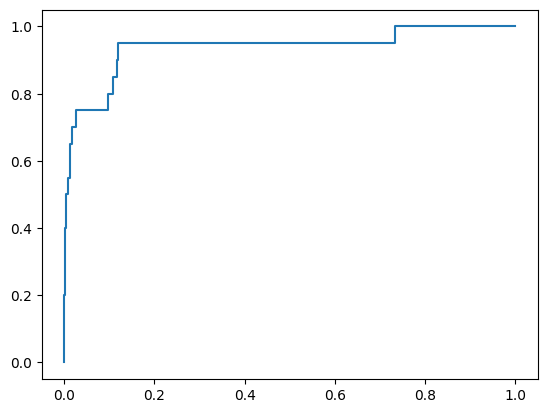

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fpr, tpr, thresholds = roc_curve(out_label_list, [pred[1].item() for pred in preds_probability])

# ROC curve
plt.plot(fpr, tpr)
plt.show()

# AUC
auc = np.trapz(tpr, fpr)